Toxicity Dataset : https://archive.ics.uci.edu/dataset/728/toxicity-2

The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1, responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic. 

The data consists a complete set of 1203 molecular descriptors and needs feature selection before classification since some of the features are redundant. 

Introductory Paper:
Structure-based design and classifications of small molecules regulating the circadian rhythm period
By Seref Gul, F. Rahim, Safak Isin, Fatma Yilmaz, Nuri Ozturk, M. Turkay, I. Kavakli. 2021
https://www.semanticscholar.org/paper/Structure-based-design-and-classifications-of-small-Gul-Rahim/5944836c47bc7d1a2b0464a9a1db94d4bc7f28ce

# IMPORTS

In [1]:
pip install ucimlrepo

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    cross_validate, GridSearchCV, learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc, roc_curve,
    classification_report, matthews_corrcoef,
    average_precision_score, balanced_accuracy_score, make_scorer
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn import clone
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier

# For SMOTE (install: pip install imbalanced-learn)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# For statistical testing
from scipy.stats import ttest_rel, wilcoxon

In [3]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

In [4]:
# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# DATA LOAD AND PREPROCESSING

In [5]:
data = fetch_ucirepo(id=728)
X = data.data.features
y = data.data.targets

# Binary encoding: NonToxic=1, Toxic=0
y_binary = (y['Class'] == 'NonToxic').astype(int)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of molecules (n): {X.shape[0]}")
print(f"Number of descriptors (p): {X.shape[1]}")
print(f"Dimensionality ratio (p/n): {X.shape[1]/X.shape[0]:.2f}")
print(f"\nClass distribution:")
print(y['Class'].value_counts())
print(f"\nClass balance:")
for cls, count in y['Class'].value_counts().items():
    pct = count / len(y) * 100
    print(f"  {cls}: {count} ({pct:.2f}%)")

DATASET OVERVIEW
Feature matrix shape: (171, 1203)
Number of molecules (n): 171
Number of descriptors (p): 1203
Dimensionality ratio (p/n): 7.04

Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64

Class balance:
  NonToxic: 115 (67.25%)
  Toxic: 56 (32.75%)


In [6]:
# Check for missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y_binary.isnull().sum()}")


Missing values in features: 0
Missing values in target: 0


# Feature Correlation Analysis


FEATURE CORRELATION ANALYSIS (threshold > 0.9)
Total feature pairs with correlation > 0.9: 3702

Top 10 highest correlations:
Feature1 Feature2  Correlation
 khs.tCH  maxHtCH          1.0
   nHtCH  maxHtCH          1.0
    ntCH  minHtCH          1.0
    ntCH  maxHtCH          1.0
   SHtCH    nHtCH          1.0
   SHtCH     ntCH          1.0
   SHtCH    C2SP1          1.0
   C2SP1  maxHtCH          1.0
   C2SP1  minHtCH          1.0
 minHtCH  khs.tCH          1.0


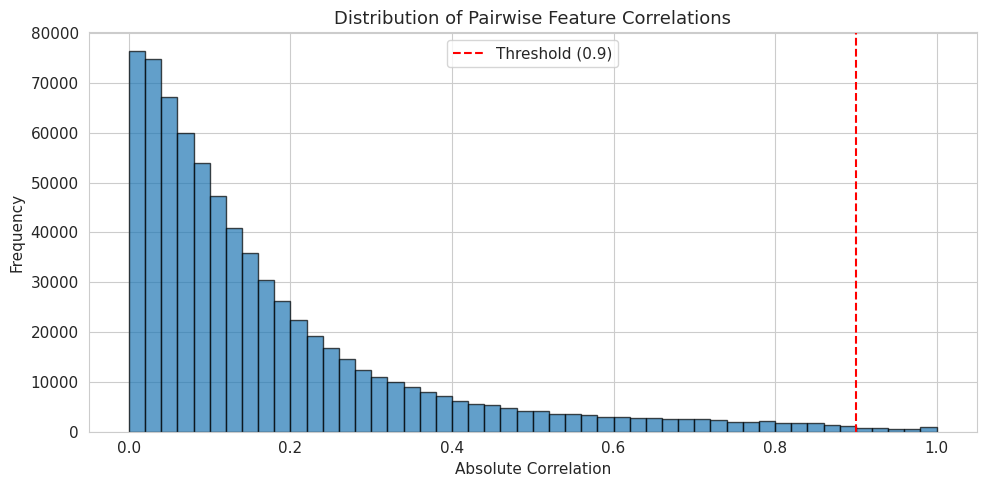


Percentage of feature pairs with |r| > 0.9: 0.51%


In [7]:
def analyze_feature_correlation(X, threshold=0.9):
    """Analyze pairwise feature correlations"""
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    high_corr_pairs = []
    for column in upper_tri.columns:
        high_corr_features = upper_tri.index[upper_tri[column] > threshold].tolist()
        for feat in high_corr_features:
            high_corr_pairs.append((column, feat, upper_tri.loc[feat, column]))
    
    print(f"\n{'='*80}")
    print(f"FEATURE CORRELATION ANALYSIS (threshold > {threshold})")
    print("="*80)
    print(f"Total feature pairs with correlation > {threshold}: {len(high_corr_pairs)}")
    
    if len(high_corr_pairs) > 0:
        corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
        corr_df = corr_df.sort_values('Correlation', ascending=False)
        print(f"\nTop 10 highest correlations:")
        print(corr_df.head(10).to_string(index=False))
        
        # Visualize correlation distribution
        all_corrs = upper_tri.values[np.triu_indices_from(upper_tri.values, k=1)]
        all_corrs = all_corrs[~np.isnan(all_corrs)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
        plt.axvline(threshold, color='red', linestyle='--', 
                   label=f'Threshold ({threshold})')
        plt.xlabel('Absolute Correlation')
        plt.ylabel('Frequency')
        plt.title('Distribution of Pairwise Feature Correlations')
        plt.legend()
        plt.tight_layout()
        plt.savefig('feature_correlation_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        pct_high_corr = (len(high_corr_pairs) / (X.shape[1] * (X.shape[1]-1) / 2)) * 100
        print(f"\nPercentage of feature pairs with |r| > {threshold}: {pct_high_corr:.2f}%")
    
    return high_corr_pairs

high_corr_pairs = analyze_feature_correlation(X, threshold=0.9)


# Train-Test Split with Stratification

In [8]:
# Shuffle dataset
np.random.seed(RANDOM_STATE)
shuffle_idx = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffle_idx].reset_index(drop=True)
y_shuffled = y_binary.iloc[shuffle_idx].reset_index(drop=True)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2,
    random_state=RANDOM_STATE, stratify=y_shuffled
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n{'='*80}")
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nTraining class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest class distribution:")
print(pd.Series(y_test).value_counts())

feature_names = X.columns.tolist()


TRAIN-TEST SPLIT
Training set: (136, 1203)
Test set: (35, 1203)

Training class distribution:
Class
1    91
0    45
Name: count, dtype: int64

Test class distribution:
Class
1    24
0    11
Name: count, dtype: int64


# SMOTE for Class Imbalance

In [9]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n{'='*80}")
print("SMOTE RESAMPLING")
print("="*80)
print(f"Original training size: {X_train_scaled.shape}")
print(f"SMOTE training size: {X_train_smote.shape}")
print(f"\nOriginal class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nSMOTE class distribution:")
print(pd.Series(y_train_smote).value_counts())


SMOTE RESAMPLING
Original training size: (136, 1203)
SMOTE training size: (182, 1203)

Original class distribution:
Class
1    91
0    45
Name: count, dtype: int64

SMOTE class distribution:
Class
0    91
1    91
Name: count, dtype: int64


# MODEL DEFINITIONS WITH HYPERPARAMETER OPTIMIZATION

In [10]:
# Compute class weights for weighted models
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n{'='*80}")
print("CLASS WEIGHTS")
print("="*80)
print(f"Class 0 (Toxic): {class_weight_dict[0]:.3f}")
print(f"Class 1 (NonToxic): {class_weight_dict[1]:.3f}")


CLASS WEIGHTS
Class 0 (Toxic): 1.511
Class 1 (NonToxic): 0.747


In [11]:
models = {
    # ===== PENALIZED REGRESSION MODELS =====
    # No penalty
    'LR_No_Penalty': LogisticRegression(penalty=None, max_iter=5000, 
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Ridge (L2) - Multiple C values
    'LR_Ridge_C0.01': LogisticRegression(penalty='l2', C=0.01, max_iter=5000,
                                         solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C0.1': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C1': LogisticRegression(penalty='l2', C=1.0, max_iter=5000,
                                      solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C10': LogisticRegression(penalty='l2', C=10.0, max_iter=5000,
                                       solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C100': LogisticRegression(penalty='l2', C=100.0, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Lasso (L1) - Multiple C values
    'LR_Lasso_C0.001': LogisticRegression(penalty='l1', C=0.001, max_iter=5000,
                                          solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C0.01': LogisticRegression(penalty='l1', C=0.01, max_iter=5000,
                                         solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C0.1': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                        solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C1': LogisticRegression(penalty='l1', C=1.0, max_iter=5000,
                                      solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C10': LogisticRegression(penalty='l1', C=10.0, max_iter=5000,
                                       solver='saga', random_state=RANDOM_STATE),
    
    # Elastic Net - Multiple configurations
    'LR_ElasticNet_L1_0.3_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.3, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.5, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.5, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.7_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.7, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    
    # Weighted versions of best regularized models
    'LR_Lasso_C0.1_Weighted': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                                 solver='saga', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    'LR_Ridge_C0.1_Weighted': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                                 solver='lbfgs', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    
    # Other linear classifiers
    'Ridge_Classifier': RidgeClassifier(alpha=1.0, random_state=RANDOM_STATE),
    'SGD_Classifier': SGDClassifier(loss='log_loss', max_iter=5000, 
                                   random_state=RANDOM_STATE),

    # ===== DISCRIMINANT ANALYSIS =====
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),

    # ===== NAIVE BAYES =====
    'Naive_Bayes': GaussianNB(),

    # ===== TREE-BASED MODELS =====
    'Decision_Tree_D5': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Decision_Tree_D10': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    'Decision_Tree_D20': DecisionTreeClassifier(max_depth=20, random_state=RANDOM_STATE),
    'Decision_Tree_Weighted': DecisionTreeClassifier(max_depth=10, 
                                                     class_weight='balanced',
                                                     random_state=RANDOM_STATE),

    # ===== ENSEMBLE METHODS =====
    # Random Forest
    'Random_Forest_N50': RandomForestClassifier(n_estimators=50, max_depth=10, 
                                                random_state=RANDOM_STATE),
    'Random_Forest_N100': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                 random_state=RANDOM_STATE),
    'Random_Forest_N100_Weighted': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                          class_weight='balanced',
                                                          random_state=RANDOM_STATE),
    'Extra_Trees_N100': ExtraTreesClassifier(n_estimators=100, max_depth=10,
                                            random_state=RANDOM_STATE),

    # Boosting
    'AdaBoost_N50': AdaBoostClassifier(n_estimators=50, random_state=RANDOM_STATE,
                                       algorithm='SAMME'),
    'AdaBoost_N100': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                        algorithm='SAMME'),
    'GradientBoosting_N50': GradientBoostingClassifier(n_estimators=50, max_depth=3,
                                                       random_state=RANDOM_STATE),
    'GradientBoosting_N100': GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                                        random_state=RANDOM_STATE),
    'XGBoost_D3_N50': XGBClassifier(max_depth=3, n_estimators=50,
                                   eval_metric='logloss', use_label_encoder=False,
                                   random_state=RANDOM_STATE),
    'XGBoost_D3_N100': XGBClassifier(max_depth=3, n_estimators=100,
                                    eval_metric='logloss', use_label_encoder=False,
                                    random_state=RANDOM_STATE),

    # ===== SUPPORT VECTOR MACHINES =====
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    'SVM_Linear_Weighted': SVC(kernel='linear', probability=True, 
                              class_weight='balanced', random_state=RANDOM_STATE),
    'SVM_RBF_C1': SVC(kernel='rbf', C=1.0, probability=True, random_state=RANDOM_STATE),
    'SVM_RBF_C10': SVC(kernel='rbf', C=10.0, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D2': SVC(kernel='poly', degree=2, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D3': SVC(kernel='poly', degree=3, probability=True, random_state=RANDOM_STATE),

    # ===== K-NEAREST NEIGHBORS =====
    'KNN_K3': KNeighborsClassifier(n_neighbors=3),
    'KNN_K5': KNeighborsClassifier(n_neighbors=5),
    'KNN_K7': KNeighborsClassifier(n_neighbors=7),
    'KNN_K10': KNeighborsClassifier(n_neighbors=10),

    # ===== NEURAL NETWORKS =====
    'NN_Small': MLPClassifier(hidden_layer_sizes=(25,), max_iter=2000,
                             early_stopping=True, solver='lbfgs', 
                             random_state=RANDOM_STATE),
    'NN_Medium': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                              early_stopping=True, solver='lbfgs',
                              random_state=RANDOM_STATE),
    'NN_Large': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000,
                             early_stopping=True, solver='lbfgs',
                             random_state=RANDOM_STATE),
    'NN_Adam': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                            early_stopping=True, solver='adam',
                            random_state=RANDOM_STATE),
}

print(f"\nTotal models defined: {len(models)}")


Total models defined: 50


# MODEL EVALUATION FUNCTION

In [12]:
def evaluate_model_comprehensive(model, X_train, X_test, y_train, y_test, 
                                model_name="Model"):
    """
    Comprehensive evaluation including:
    - Standard metrics (accuracy, precision, recall, F1, AUC)
    - Matthews Correlation Coefficient (MCC)
    - Confusion matrix
    - Probability calibration check
    """
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probability scores
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)
    else:
        y_train_proba = y_train_pred.astype(float)
        y_test_proba = y_test_pred.astype(float)
    
    # Calculate metrics
    results = {
        'model': model_name,
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_test, y_test_pred),
        'pr_auc': average_precision_score(y_test, y_test_proba),
        'bacc': balanced_accuracy_score(y_test, y_test_pred)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Specificity, Sensitivity, NPV
    results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    results['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    results['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Check for majority class prediction
    unique_preds = np.unique(y_test_pred)
    results['predicts_one_class'] = len(unique_preds) == 1
    
    return results, cm

# TRAIN AND EVALUATE ALL MODELS

## STANDARD TRAIN-TEST SPLIT

In [13]:
print("\n" + "="*80)
print("TRAINING MODELS - STANDARD TRAIN-TEST SPLIT")
print("="*80)

results_standard = []
confusion_matrices = {}

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_scaled, X_test_scaled, y_train, y_test, name
        )
        results_standard.append(metrics)
        confusion_matrices[name] = cm
        
        # Flag models predicting only one class
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"mcc: {metrics['mcc']:.4f}, pr_auc: {metrics['pr_auc']:.4f}, bacc: {metrics['bacc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_standard_df = pd.DataFrame(results_standard).sort_values('mcc', ascending=False).reset_index(drop=True)


TRAINING MODELS - STANDARD TRAIN-TEST SPLIT
Training LR_No_Penalty... mcc: 0.1165, pr_auc: 0.7440, bacc: 0.5606
Training LR_Ridge_C0.01... mcc: 0.0187, pr_auc: 0.7744, bacc: 0.5076
Training LR_Ridge_C0.1... mcc: -0.0195, pr_auc: 0.7799, bacc: 0.4905
Training LR_Ridge_C1... mcc: 0.0296, pr_auc: 0.7738, bacc: 0.5152
Training LR_Ridge_C10... mcc: -0.0606, pr_auc: 0.7683, bacc: 0.4697
Training LR_Ridge_C100... mcc: -0.1000, pr_auc: 0.7585, bacc: 0.4489
Training LR_Lasso_C0.001... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.01... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.1... mcc: 0.0000, pr_auc: 0.7894, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C1... mcc: 0.0720, pr_auc: 0.7581, bacc: 0.5360
Training LR_Lasso_C10... mcc: 0.0296, pr_auc: 0.7469, bacc: 0.5152
Training LR_ElasticNet_L1_0.3_C0.1... mcc: 0.0712, pr_auc: 0.7212, bacc: 0.5322
Training LR_ElasticNet_L1_0.5_C0.1... mcc: 0.0754, pr_auc: 0.7188, bacc: 0.5284
Trai

In [14]:
results_standard_df

,model,train_acc,test_acc,train_auc,test_auc,precision,recall,f1,mcc,pr_auc,bacc,specificity,sensitivity,npv,predicts_one_class
0,QDA,1.000000,0.628571,1.000000,0.630682,0.789474,0.625000,0.697674,0.243562,0.750564,0.630682,0.636364,0.625000,0.437500,False
1,XGBoost_D3_N50,1.000000,0.657143,1.000000,0.689394,0.750000,0.750000,0.750000,0.204545,0.866304,0.602273,0.454545,0.750000,0.454545,False
2,KNN_K3,0.757353,0.657143,0.779487,0.695076,0.750000,0.750000,0.750000,0.204545,0.825753,0.602273,0.454545,0.750000,0.454545,False
3,Decision_Tree_D5,0.948529,0.628571,0.989866,0.579545,0.761905,0.666667,0.711111,0.201008,0.719526,0.606061,0.545455,0.666667,0.428571,False
4,Random_Forest_N100_Weighted,1.000000,0.685714,1.000000,0.678030,0.724138,0.875000,0.792453,0.181965,0.867135,0.573864,0.272727,0.875000,0.500000,False
5,KNN_K10,0.654412,0.657143,0.682051,0.655303,0.730769,0.791667,0.760000,0.164958,0.806430,0.577652,0.363636,0.791667,0.444444,False
6,GradientBoosting_N100,1.000000,0.657143,1.000000,0.625000,0.730769,0.791667,0.760000,0.164958,0.833974,0.577652,0.363636,0.791667,0.444444,False
7,XGBoost_D3_N100,1.000000,0.657143,1.000000,0.681818,0.730769,0.791667,0.760000,0.164958,0.865483,0.577652,0.363636,0.791667,0.444444,False
8,LDA,0.955882,0.600000,0.993407,0.547348,0.750000,0.625000,0.681818,0.159901,0.708999,0.585227,0.545455,0.625000,0.400000,False
9,Decision_Tree_D20,1.000000,0.600000,1.000000,0.585227,0.750000,0.625000,0.681818,0.159901,0.725893,0.585227,0.545455,0.625000,0.400000,False


## With SMOTE Resampling

In [15]:
print("\n" + "="*80)
print("TRAINING MODELS - WITH SMOTE RESAMPLING")
print("="*80)

results_smote = []

for name, model in models.items():
    # Skip if model doesn't work well with SMOTE
    if 'LDA' in name or 'QDA' in name:
        continue
        
    print(f"Training {name} with SMOTE...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_smote, X_test_scaled, y_train_smote, y_test, 
            f"{name}_SMOTE"
        )
        results_smote.append(metrics)
        
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"mcc: {metrics['mcc']:.4f}, pr_auc: {metrics['pr_auc']:.4f}, bacc: {metrics['bacc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_smote_df = pd.DataFrame(results_smote).sort_values('mcc', ascending=False).reset_index(drop=True)


TRAINING MODELS - WITH SMOTE RESAMPLING
Training LR_No_Penalty with SMOTE... mcc: 0.1599, pr_auc: 0.7446, bacc: 0.5852
Training LR_Ridge_C0.01 with SMOTE... mcc: 0.0296, pr_auc: 0.7354, bacc: 0.5152
Training LR_Ridge_C0.1 with SMOTE... mcc: -0.0606, pr_auc: 0.7836, bacc: 0.4697
Training LR_Ridge_C1 with SMOTE... mcc: 0.0296, pr_auc: 0.7703, bacc: 0.5152
Training LR_Ridge_C10 with SMOTE... mcc: -0.0606, pr_auc: 0.7663, bacc: 0.4697
Training LR_Ridge_C100 with SMOTE... mcc: -0.0109, pr_auc: 0.7645, bacc: 0.4943
Training LR_Lasso_C0.001 with SMOTE... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.01 with SMOTE... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.1 with SMOTE... mcc: -0.0503, pr_auc: 0.7002, bacc: 0.4735
Training LR_Lasso_C1 with SMOTE... mcc: 0.0296, pr_auc: 0.7541, bacc: 0.5152
Training LR_Lasso_C10 with SMOTE... mcc: 0.0296, pr_auc: 0.7457, bacc: 0.5152
Training LR_ElasticNet_L1_0.3_C0.1 with SMOTE... mcc: 0.1165

In [16]:
results_smote_df

,model,train_acc,test_acc,train_auc,test_auc,precision,recall,f1,mcc,pr_auc,bacc,specificity,sensitivity,npv,predicts_one_class
0,Decision_Tree_Weighted_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
1,Decision_Tree_D10_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
2,Decision_Tree_D20_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
3,Decision_Tree_D5_SMOTE,0.928571,0.685714,0.947470,0.715909,0.842105,0.666667,0.744186,0.367109,0.792992,0.696970,0.727273,0.666667,0.500000,False
4,KNN_K3_SMOTE,0.769231,0.542857,0.928149,0.645833,0.833333,0.416667,0.555556,0.229686,0.790580,0.617424,0.818182,0.416667,0.391304,False
5,SVM_Poly_D3_SMOTE,0.785714,0.400000,0.979230,0.541667,1.000000,0.125000,0.222222,0.207289,0.762223,0.562500,1.000000,0.125000,0.343750,False
6,NN_Small_SMOTE,1.000000,0.657143,1.000000,0.672348,0.750000,0.750000,0.750000,0.204545,0.832904,0.602273,0.454545,0.750000,0.454545,False
7,GradientBoosting_N50_SMOTE,1.000000,0.600000,1.000000,0.689394,0.777778,0.583333,0.666667,0.204063,0.862702,0.609848,0.636364,0.583333,0.411765,False
8,AdaBoost_N50_SMOTE,1.000000,0.628571,1.000000,0.609848,0.761905,0.666667,0.711111,0.201008,0.820031,0.606061,0.545455,0.666667,0.428571,False
9,SVM_Poly_D2_SMOTE,0.868132,0.571429,0.966308,0.632576,0.764706,0.541667,0.634146,0.165362,0.815875,0.589015,0.636364,0.541667,0.388889,False


In [17]:
results_combined_df = pd.concat([results_standard_df, results_smote_df], 
                                ignore_index=True)
results_combined_df = results_combined_df.sort_values('mcc', 
                                                       ascending=False).reset_index(drop=True)

In [37]:
results_combined_df

,model,train_acc,test_acc,train_auc,test_auc,precision,recall,f1,mcc,pr_auc,bacc,specificity,sensitivity,npv,predicts_one_class
0,Decision_Tree_D5_SMOTE,0.928571,0.685714,0.947470,0.715909,0.842105,0.666667,0.744186,0.367109,0.792992,0.696970,0.727273,0.666667,0.500000,False
1,KNN_K5,0.713235,0.657143,0.757021,0.702652,0.714286,0.833333,0.769231,0.123091,0.820306,0.553030,0.272727,0.833333,0.428571,False
2,KNN_K3,0.757353,0.657143,0.779487,0.695076,0.750000,0.750000,0.750000,0.204545,0.825753,0.602273,0.454545,0.750000,0.454545,False
3,Decision_Tree_D10_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
4,Decision_Tree_D20_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,SVM_Linear,1.000000,0.542857,0.000000,0.443182,0.666667,0.666667,0.666667,-0.060606,0.750719,0.469697,0.272727,0.666667,0.272727,False
94,SVM_RBF_C10,1.000000,0.485714,0.000000,0.405303,0.625000,0.625000,0.625000,-0.193182,0.650476,0.403409,0.181818,0.625000,0.181818,False
95,SVM_Poly_D2,0.720588,0.685714,0.011966,0.382576,0.685714,1.000000,0.813559,0.000000,0.632652,0.500000,0.000000,1.000000,0.000000,True
96,SVM_RBF_C1,0.727941,0.685714,0.010501,0.382576,0.685714,1.000000,0.813559,0.000000,0.621714,0.500000,0.000000,1.000000,0.000000,True


# EVALUATION

## Cross-Validation

In [18]:
# def evaluate_model_cv_comprehensive(model, X, y, cv=5):
#     """
#     Comprehensive cross-validation with multiple metrics
#     """
#     skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
#     scoring = {
#         'accuracy': 'accuracy',
#         'roc_auc': 'roc_auc',
#         'f1': 'f1',
#         'precision': 'precision',
#         'recall': 'recall',
#         'matthews_corrcoef': 'matthews_corrcoef',
#         'average_precision': 'average_precision',
#         'balanced_accuracy': 'balanced_accuracy',
#     }
    
#     cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, 
#                                 n_jobs=-1, return_train_score=True)
    
#     return {
#         'train_acc_mean': cv_results['train_accuracy'].mean(),
#         'train_acc_std': cv_results['train_accuracy'].std(),
#         'test_acc_mean': cv_results['test_accuracy'].mean(),
#         'test_acc_std': cv_results['test_accuracy'].std(),
#         'test_auc_mean': cv_results['test_roc_auc'].mean(),
#         'test_auc_std': cv_results['test_roc_auc'].std(),
#         'test_f1_mean': cv_results['test_f1'].mean(),
#         'test_f1_std': cv_results['test_f1'].std(),
#         'test_precision_mean': cv_results['test_precision'].mean(),
#         'test_precision_std': cv_results['test_precision'].std(),
#         'test_recall_mean': cv_results['test_recall'].mean(),
#         'test_recall_std': cv_results['test_recall'].std(),
#         'test_mcc_mean': cv_results['test_matthews_corrcoef'].mean(),
#         'test_mcc_std': cv_results['test_matthews_corrcoef'].std(),
#         'test_pr_auc_mean': cv_results['test_average_precision'].mean(),
#         'test_pr_auc_std': cv_results['test_average_precision'].std(),
#         'test_bacc_mean': cv_results['test_balanced_accuracy'].mean(),
#         'test_bacc_std': cv_results['test_balanced_accuracy'].std(),
#         'overfitting_gap': cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()
#     }

In [19]:
# print("\n" + "="*80)
# print("CROSS-VALIDATION (5-FOLD STRATIFIED)")
# print("="*80)

# cv_results = []
# for name, model in models.items():
#     print(f"CV: {name}...", end=" ")
#     try:
#         metrics = evaluate_model_cv_comprehensive(model, X_train_scaled, y_train, cv=5)
#         metrics['model'] = name
#         cv_results.append(metrics)
#         print(f"mcc: {metrics['test_mcc_mean']:.4f}±{metrics['test_mcc_std']:.4f}, "
#               f"pr_auc: {metrics['test_pr_auc_mean']:.4f}±{metrics['test_pr_auc_std']:.4f}")
#     except Exception as e:
#         print(f"FAILED: {e}")

# cv_results_df = pd.DataFrame(cv_results)
# cv_results_df = cv_results_df.sort_values('test_mcc_mean', 
#                                           ascending=False).reset_index(drop=True)


CROSS-VALIDATION (5-FOLD STRATIFIED)
CV: LR_No_Penalty... mcc: -0.1703±0.2908, pr_auc: 0.6457±0.0920
CV: LR_Ridge_C0.01... mcc: -0.2006±0.1410, pr_auc: 0.6711±0.0861
CV: LR_Ridge_C0.1... mcc: -0.1843±0.2203, pr_auc: 0.6777±0.1018
CV: LR_Ridge_C1... mcc: -0.1568±0.3032, pr_auc: 0.6752±0.1032
CV: LR_Ridge_C10... mcc: -0.1885±0.2794, pr_auc: 0.6796±0.1059
CV: LR_Ridge_C100... mcc: -0.0909±0.3068, pr_auc: 0.6677±0.1154
CV: LR_Lasso_C0.001... mcc: 0.0000±0.0000, pr_auc: 0.6690±0.0048
CV: LR_Lasso_C0.01... mcc: 0.0000±0.0000, pr_auc: 0.6690±0.0048
CV: LR_Lasso_C0.1... mcc: 0.0000±0.0000, pr_auc: 0.6727±0.0925
CV: LR_Lasso_C1... mcc: -0.2016±0.2462, pr_auc: 0.6566±0.0660
CV: LR_Lasso_C10... mcc: -0.1413±0.2848, pr_auc: 0.6669±0.1100
CV: LR_ElasticNet_L1_0.3_C0.1... mcc: -0.1288±0.1215, pr_auc: 0.6579±0.0909
CV: LR_ElasticNet_L1_0.5_C0.1... mcc: -0.1342±0.1278, pr_auc: 0.6761±0.0864
CV: LR_ElasticNet_L1_0.5_C1... mcc: -0.2143±0.3078, pr_auc: 0.6710±0.0804
CV: LR_ElasticNet_L1_0.7_C1... mcc: -

In [20]:
# cv_results_df

,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,test_auc_mean,test_auc_std,test_f1_mean,test_f1_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std,test_mcc_mean,test_mcc_std,test_pr_auc_mean,test_pr_auc_std,test_bacc_mean,test_bacc_std,overfitting_gap,model
0,1.000000,0.000000,0.616931,0.071505,0.450877,0.110392,0.731829,0.047587,0.694009,0.069976,0.780702,0.068173,0.070396,0.194772,0.671523,0.079914,0.534795,0.096151,0.383069,XGBoost_D3_N50
1,0.709514,0.024200,0.623810,0.091680,0.519948,0.149643,0.741429,0.069000,0.685714,0.064594,0.812281,0.097827,0.059336,0.225379,0.703372,0.093081,0.528363,0.103550,0.085705,KNN_K7
2,0.722341,0.036234,0.602381,0.070350,0.504191,0.123131,0.720890,0.051182,0.680134,0.051512,0.769006,0.065356,0.035079,0.175447,0.689537,0.079398,0.517836,0.081144,0.119960,KNN_K5
3,1.000000,0.000000,0.515344,0.046440,0.510396,0.082895,0.592552,0.040729,0.677280,0.039744,0.528070,0.049366,0.016448,0.100628,0.728984,0.054415,0.508480,0.053577,0.484656,QDA
4,1.000000,0.000000,0.587831,0.073627,0.445939,0.113158,0.706923,0.053974,0.679304,0.070372,0.748538,0.097942,0.013225,0.198126,0.665189,0.078336,0.507602,0.094970,0.412169,XGBoost_D3_N100
5,0.742627,0.014561,0.669048,0.004762,0.365822,0.084149,0.801702,0.003404,0.669048,0.004762,1.000000,0.000000,0.000000,0.000000,0.645825,0.062703,0.500000,0.000000,0.073579,SVM_RBF_C1
6,0.669113,0.001223,0.669048,0.004762,0.500000,0.000000,0.801702,0.003404,0.669048,0.004762,1.000000,0.000000,0.000000,0.000000,0.669048,0.004762,0.500000,0.000000,0.000066,LR_Lasso_C0.001
7,0.669113,0.001223,0.669048,0.004762,0.500000,0.000000,0.801702,0.003404,0.669048,0.004762,1.000000,0.000000,0.000000,0.000000,0.669048,0.004762,0.500000,0.000000,0.000066,LR_Lasso_C0.01
8,0.669113,0.001223,0.669048,0.004762,0.425211,0.150142,0.801702,0.003404,0.669048,0.004762,1.000000,0.000000,0.000000,0.000000,0.672726,0.092475,0.500000,0.000000,0.000066,LR_Lasso_C0.1
9,1.000000,0.000000,0.558466,0.079279,0.460559,0.089057,0.669591,0.072262,0.670345,0.069934,0.682456,0.129313,-0.006932,0.168234,0.670388,0.065211,0.496784,0.086494,0.441534,AdaBoost_N50


## Nested Cross-Validation

In [21]:
def nested_cross_validation(model, X, y, inner_cv=5, outer_cv=5, param_grid=None):
    """
    Nested CV: outer loop for performance estimation, inner loop for hyperparameter tuning
    Returns unbiased performance estimates with comprehensive metrics
    """
    from sklearn.model_selection import GridSearchCV
    
    outer_skf = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=RANDOM_STATE)
    
    outer_scores = {
        'test_accuracy': [],
        'test_auc': [],
        'test_f1': [],
        'test_mcc': [],
        'test_pr_auc': [],
        'test_bacc': [],
        'best_params': []
    }
    
    for train_idx, test_idx in outer_skf.split(X, y):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
        
        if param_grid:
            # Inner CV for hyperparameter tuning
            inner_skf = StratifiedKFold(n_splits=inner_cv, shuffle=True, random_state=RANDOM_STATE)
            grid_search = GridSearchCV(model, param_grid, cv=inner_skf, 
                                      scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train_outer, y_train_outer)
            best_model = grid_search.best_estimator_
            outer_scores['best_params'].append(grid_search.best_params_)
        else:
            best_model = model
            best_model.fit(X_train_outer, y_train_outer)
        
        # Evaluate on outer test fold
        y_pred = best_model.predict(X_test_outer)
        y_proba = best_model.predict_proba(X_test_outer)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred
        
        outer_scores['test_accuracy'].append(accuracy_score(y_test_outer, y_pred))
        outer_scores['test_auc'].append(roc_auc_score(y_test_outer, y_proba))
        outer_scores['test_f1'].append(f1_score(y_test_outer, y_pred))
        outer_scores['test_mcc'].append(matthews_corrcoef(y_test_outer, y_pred))
        outer_scores['test_pr_auc'].append(average_precision_score(y_test_outer, y_proba))
        outer_scores['test_bacc'].append(balanced_accuracy_score(y_test_outer, y_pred))
    
    return {
        'mean_accuracy': np.mean(outer_scores['test_accuracy']),
        'std_accuracy': np.std(outer_scores['test_accuracy']),
        'mean_auc': np.mean(outer_scores['test_auc']),
        'std_auc': np.std(outer_scores['test_auc']),
        'mean_f1': np.mean(outer_scores['test_f1']),
        'std_f1': np.std(outer_scores['test_f1']),
        'mean_mcc': np.mean(outer_scores['test_mcc']),
        'std_mcc': np.std(outer_scores['test_mcc']),
        'mean_pr_auc': np.mean(outer_scores['test_pr_auc']),
        'std_pr_auc': np.std(outer_scores['test_pr_auc']),
        'mean_bacc': np.mean(outer_scores['test_bacc']),
        'std_bacc': np.std(outer_scores['test_bacc']),
        'all_params': outer_scores['best_params']
    }


In [22]:
def nested_cross_validation_fast(model, X, y, inner_cv=3, outer_cv=5, param_grid=None, 
                                 scoring_metric='roc_auc', n_jobs=-1):
    """
    Optimized nested CV - much faster:
    - Reduced inner CV to 3 folds (sufficient for small n)
    - Smaller, smarter param grids
    - Parallel processing optimized
    - Early stopping for grid search
    """
    from sklearn.model_selection import GridSearchCV
    from scipy import stats
    
    outer_skf = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=RANDOM_STATE)
    
    outer_scores = {
        'test_mcc': [],
        'test_pr_auc': [],
        'test_bacc': [],
        'test_auc': [],
        'best_params': [],
        'n_selected_features': []
    }
    
    fold_idx = 0
    for train_idx, test_idx in outer_skf.split(X, y):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
        
        if param_grid:
            inner_skf = StratifiedKFold(n_splits=inner_cv, shuffle=True, 
                                       random_state=RANDOM_STATE + fold_idx)
            
            mcc_scorer = make_scorer(matthews_corrcoef)
            
            grid_search = GridSearchCV(
                model, 
                param_grid, 
                cv=inner_skf, 
                scoring=mcc_scorer,
                n_jobs=n_jobs,
                verbose=0,
                return_train_score=False,
                error_score='raise'
            )
            grid_search.fit(X_train_outer, y_train_outer)
            best_model = grid_search.best_estimator_
            outer_scores['best_params'].append(grid_search.best_params_)
        else:
            best_model = clone(model)
            best_model.fit(X_train_outer, y_train_outer)
            outer_scores['best_params'].append({})
        
        y_pred = best_model.predict(X_test_outer)
        y_proba = best_model.predict_proba(X_test_outer)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred
        
        outer_scores['test_mcc'].append(matthews_corrcoef(y_test_outer, y_pred))
        outer_scores['test_pr_auc'].append(average_precision_score(y_test_outer, y_proba))
        outer_scores['test_bacc'].append(balanced_accuracy_score(y_test_outer, y_pred))
        outer_scores['test_auc'].append(roc_auc_score(y_test_outer, y_proba))
        
        if hasattr(best_model, 'coef_'):
            n_selected = np.sum(np.abs(best_model.coef_[0]) > 1e-5)
            outer_scores['n_selected_features'].append(n_selected)
        
        fold_idx += 1
    
    def calc_ci(scores):
        mean = np.mean(scores)
        se = stats.sem(scores)
        ci = se * stats.t.ppf(0.975, len(scores) - 1)
        return mean, (mean - ci, mean + ci)
    
    mcc_mean, mcc_ci = calc_ci(outer_scores['test_mcc'])
    pr_auc_mean, pr_auc_ci = calc_ci(outer_scores['test_pr_auc'])
    
    return {
        'mean_mcc': mcc_mean,
        'ci_mcc_lower': mcc_ci[0],
        'ci_mcc_upper': mcc_ci[1],
        'mean_pr_auc': pr_auc_mean,
        'ci_pr_auc_lower': pr_auc_ci[0],
        'ci_pr_auc_upper': pr_auc_ci[1],
        'mean_bacc': np.mean(outer_scores['test_bacc']),
        'mean_auc': np.mean(outer_scores['test_auc']),
        'mean_n_features': np.mean(outer_scores['n_selected_features']) if outer_scores['n_selected_features'] else X.shape[1],
        'all_params': outer_scores['best_params']
    }


print("\n" + "="*80)
print("NESTED CROSS-VALIDATION - OPTIMIZED")
print("="*80)

hyperparameter_grids = {
    'Ridge': {
        'model': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000, 
                                   random_state=RANDOM_STATE),
        'params': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'class_weight': [None, 'balanced']
        }
    },
    'Lasso': {
        'model': LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, 
                                   random_state=RANDOM_STATE),
        'params': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'class_weight': [None, 'balanced']
        }
    },
    'ElasticNet': {
        'model': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000, 
                                   random_state=RANDOM_STATE, tol=1e-3),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'l1_ratio': [0.5, 0.7],
            'class_weight': ['balanced']
        }
    }
}



nested_cv_results = []
import time

for model_name, config in hyperparameter_grids.items():
    print(f"\nNested CV: {model_name}...", end=" ", flush=True)
    start = time.time()
    
    metrics = nested_cross_validation_fast(
        config['model'], 
        X_train_scaled, 
        y_train, 
        inner_cv=3,
        outer_cv=5, 
        param_grid=config['params'],
        n_jobs=-1
    )
    
    elapsed = time.time() - start
    metrics['model'] = model_name
    nested_cv_results.append(metrics)
    
    print(f"✓ ({elapsed:.1f}s) MCC: {metrics['mean_mcc']:.3f} [{metrics['ci_mcc_lower']:.3f}, {metrics['ci_mcc_upper']:.3f}], "
          f"PR-AUC: {metrics['mean_pr_auc']:.3f}, Features: {metrics['mean_n_features']:.0f}")

if nested_cv_results:
    nested_cv_results_df = pd.DataFrame(nested_cv_results)
    nested_cv_results_df = nested_cv_results_df.sort_values('mean_mcc', ascending=False)
    
    print("\n" + "="*80)
    print("NESTED CV RESULTS")
    print("="*80)
    
    for _, row in nested_cv_results_df.iterrows():
        print(f"\n{row['model']}:")
        print(f"  MCC:    {row['mean_mcc']:.3f} [{row['ci_mcc_lower']:.3f}, {row['ci_mcc_upper']:.3f}]")
        print(f"  PR-AUC: {row['mean_pr_auc']:.3f} [{row['ci_pr_auc_lower']:.3f}, {row['ci_pr_auc_upper']:.3f}]")
        print(f"  BACC:   {row['mean_bacc']:.3f}")
        print(f"  Features: {row['mean_n_features']:.0f}")
    
    nested_cv_results_df.to_csv('nested_cv_results.csv', index=False)
    print("\n✓ Saved to nested_cv_results.csv")



NESTED CROSS-VALIDATION - OPTIMIZED

Nested CV: Ridge... ✓ (3.0s) MCC: -0.174 [-0.607, 0.260], PR-AUC: 0.681, Features: 1198

Nested CV: Lasso... ✓ (1.5s) MCC: -0.079 [-0.258, 0.101], PR-AUC: 0.675, Features: 30

Nested CV: ElasticNet... ✓ (94.2s) MCC: -0.232 [-0.533, 0.068], PR-AUC: 0.693, Features: 429

NESTED CV RESULTS

Lasso:
  MCC:    -0.079 [-0.258, 0.101]
  PR-AUC: 0.675 [0.607, 0.743]
  BACC:   0.461
  Features: 30

Ridge:
  MCC:    -0.174 [-0.607, 0.260]
  PR-AUC: 0.681 [0.535, 0.827]
  BACC:   0.408
  Features: 1198

ElasticNet:
  MCC:    -0.232 [-0.533, 0.068]
  PR-AUC: 0.693 [0.553, 0.834]
  BACC:   0.387
  Features: 429

✓ Saved to nested_cv_results.csv


In [ ]:
# hyperparameter_grids_ultrafast = {
#     'Ridge': {
#         'model': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=3000, 
#                                    class_weight='balanced', random_state=RANDOM_STATE),
#         'params': {'C': [0.1, 1.0, 10.0]}
#     },
#     'Lasso': {
#         'model': LogisticRegression(penalty='l1', solver='liblinear', max_iter=3000,
#                                    class_weight='balanced', random_state=RANDOM_STATE),
#         'params': {'C': [0.1, 1.0, 10.0]}
#     },
#     'ElasticNet': {
#         'model': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=3000, 
#                                    class_weight='balanced', l1_ratio=0.5, 
#                                    tol=1e-3, random_state=RANDOM_STATE),
#         'params': {'C': [0.1, 1.0, 10.0]}
#     }
# }


In [23]:
# nested cross-validation can be computationally expensive; uncomment to run
# print("\n" + "="*80)
# print("NESTED CROSS-VALIDATION (5-FOLD INNER & OUTER)")
# print("="*80)
# nested_cv_results = []
# for name, model in models.items():
#     print(f"Nested CV: {name}...", end=" ")
#     try:
#         metrics = nested_cross_validation(model, X_train_scaled, y_train, inner_cv=5, outer_cv=5)
#         metrics['model'] = name
#         nested_cv_results.append(metrics)
#         print(f"Acc: {metrics['mean_accuracy']:.4f}±{metrics['std_accuracy']:.4f}, "
#               f"AUC: {metrics['mean_auc']:.4f}±{metrics['std_auc']:.4f}")
#     except Exception as e:
#         print(f"FAILED: {e}")

In [24]:
def nested_cross_validation(model, X, y, inner_cv=5, outer_cv=5, param_grid=None, 
                            scoring_metric='roc_auc', n_jobs=-1):
    """
    Improved nested CV with:
    - Configurable inner scoring metric (use MCC for imbalanced data)
    - 95% confidence intervals
    - Hyperparameter stability tracking
    - Statistical comparison to baseline
    - Proper handling of failed folds
    """
    from sklearn.model_selection import GridSearchCV
    from scipy import stats
    
    outer_skf = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=RANDOM_STATE)
    
    outer_scores = {
        'test_accuracy': [],
        'test_auc': [],
        'test_f1': [],
        'test_mcc': [],
        'test_pr_auc': [],
        'test_bacc': [],
        'test_sensitivity': [],
        'test_specificity': [],
        'test_precision': [],
        'best_params': [],
        'n_selected_features': []
    }
    
    fold_idx = 0
    for train_idx, test_idx in outer_skf.split(X, y):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
        
        try:
            if param_grid:
                inner_skf = StratifiedKFold(n_splits=inner_cv, shuffle=True, 
                                           random_state=RANDOM_STATE + fold_idx)
                
                # Map scoring_metric to appropriate scorer
                if scoring_metric == 'mcc':
                    scorer = make_scorer(matthews_corrcoef)
                elif scoring_metric == 'roc_auc':
                    scorer = 'roc_auc'
                elif scoring_metric == 'f1':
                    scorer = 'f1'
                else:
                    scorer = scoring_metric
                
                grid_search = GridSearchCV(
                    model, 
                    param_grid, 
                    cv=inner_skf, 
                    scoring=scorer,
                    n_jobs=n_jobs,
                    return_train_score=False
                )
                grid_search.fit(X_train_outer, y_train_outer)
                best_model = grid_search.best_estimator_
                outer_scores['best_params'].append(grid_search.best_params_)
            else:
                best_model = clone(model)
                best_model.fit(X_train_outer, y_train_outer)
                outer_scores['best_params'].append({})
            
            y_pred = best_model.predict(X_test_outer)
            
            if hasattr(best_model, 'predict_proba'):
                y_proba = best_model.predict_proba(X_test_outer)[:, 1]
            else:
                y_proba = best_model.decision_function(X_test_outer)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
            
            tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            
            outer_scores['test_accuracy'].append(accuracy_score(y_test_outer, y_pred))
            outer_scores['test_auc'].append(roc_auc_score(y_test_outer, y_proba))
            outer_scores['test_f1'].append(f1_score(y_test_outer, y_pred))
            outer_scores['test_mcc'].append(matthews_corrcoef(y_test_outer, y_pred))
            outer_scores['test_pr_auc'].append(average_precision_score(y_test_outer, y_proba))
            outer_scores['test_bacc'].append(balanced_accuracy_score(y_test_outer, y_pred))
            outer_scores['test_sensitivity'].append(sensitivity)
            outer_scores['test_specificity'].append(specificity)
            outer_scores['test_precision'].append(precision)
            
            if hasattr(best_model, 'coef_'):
                n_selected = np.sum(np.abs(best_model.coef_[0]) > 1e-5)
                outer_scores['n_selected_features'].append(n_selected)
            else:
                outer_scores['n_selected_features'].append(X.shape[1])
                
        except Exception as e:
            print(f"    Fold {fold_idx} failed: {str(e)[:50]}")
            continue
        
        fold_idx += 1
    
    if len(outer_scores['test_mcc']) == 0:
        return None
    
    def calculate_ci(scores, confidence=0.95):
        n = len(scores)
        mean = np.mean(scores)
        std_err = stats.sem(scores)
        ci = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
        return mean, std_err, (mean - ci, mean + ci)
    
    mcc_mean, mcc_se, mcc_ci = calculate_ci(outer_scores['test_mcc'])
    pr_auc_mean, pr_auc_se, pr_auc_ci = calculate_ci(outer_scores['test_pr_auc'])
    bacc_mean, bacc_se, bacc_ci = calculate_ci(outer_scores['test_bacc'])
    
    from collections import Counter
    param_stability = {}
    if outer_scores['best_params']:
        for param_name in outer_scores['best_params'][0].keys():
            param_values = [p[param_name] for p in outer_scores['best_params']]
            most_common = Counter(param_values).most_common(1)[0]
            param_stability[param_name] = {
                'most_common': most_common[0],
                'frequency': most_common[1] / len(param_values)
            }
    
    return {
        'mean_accuracy': np.mean(outer_scores['test_accuracy']),
        'std_accuracy': np.std(outer_scores['test_accuracy']),
        'mean_auc': np.mean(outer_scores['test_auc']),
        'std_auc': np.std(outer_scores['test_auc']),
        'mean_f1': np.mean(outer_scores['test_f1']),
        'std_f1': np.std(outer_scores['test_f1']),
        'mean_mcc': mcc_mean,
        'std_mcc': np.std(outer_scores['test_mcc']),
        'se_mcc': mcc_se,
        'ci_mcc_lower': mcc_ci[0],
        'ci_mcc_upper': mcc_ci[1],
        'mean_pr_auc': pr_auc_mean,
        'std_pr_auc': np.std(outer_scores['test_pr_auc']),
        'se_pr_auc': pr_auc_se,
        'ci_pr_auc_lower': pr_auc_ci[0],
        'ci_pr_auc_upper': pr_auc_ci[1],
        'mean_bacc': bacc_mean,
        'std_bacc': np.std(outer_scores['test_bacc']),
        'se_bacc': bacc_se,
        'ci_bacc_lower': bacc_ci[0],
        'ci_bacc_upper': bacc_ci[1],
        'mean_sensitivity': np.mean(outer_scores['test_sensitivity']),
        'mean_specificity': np.mean(outer_scores['test_specificity']),
        'mean_precision': np.mean(outer_scores['test_precision']),
        'mean_n_features': np.mean(outer_scores['n_selected_features']),
        'std_n_features': np.std(outer_scores['n_selected_features']),
        'param_stability': param_stability,
        'all_params': outer_scores['best_params'],
        'n_folds_completed': len(outer_scores['test_mcc'])
    }




In [25]:
# print("\n" + "="*80)
# print("NESTED CROSS-VALIDATION - PENALIZED REGRESSION MODELS")
# print("="*80)

# hyperparameter_grids = {
#     'Ridge': {
#         'model': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, 
#                                    random_state=RANDOM_STATE),
#         'params': {
#             'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
#             'class_weight': [None, 'balanced']
#         }
#     },
#     'Lasso': {
#         'model': LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, 
#                                    random_state=RANDOM_STATE),
#         'params': {
#             'C': [0.001, 0.01, 0.1, 1.0, 10.0],
#             'class_weight': [None, 'balanced']
#         }
#     },
#     'ElasticNet': {
#         'model': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, 
#                                    random_state=RANDOM_STATE),
#         'params': {
#             'C': [0.01, 0.1, 1.0, 10.0],
#             'l1_ratio': [0.3, 0.5, 0.7, 0.9],
#             'class_weight': [None, 'balanced']
#         }
#     }
# }

# nested_cv_results = []

# for model_name, config in hyperparameter_grids.items():
#     print(f"\nNested CV: {model_name}...", end=" ")
    
#     try:
#         metrics = nested_cross_validation(
#             config['model'], 
#             X_train_scaled, 
#             y_train, 
#             inner_cv=5, 
#             outer_cv=5, 
#             param_grid=config['params'],
#             scoring_metric='mcc',
#             n_jobs=-1
#         )
        
#         if metrics is None:
#             print(f"✗ All folds failed")
#             continue
            
#         metrics['model'] = model_name
#         nested_cv_results.append(metrics)
        
#         print(f"✓ MCC: {metrics['mean_mcc']:.3f} [{metrics['ci_mcc_lower']:.3f}, {metrics['ci_mcc_upper']:.3f}], "
#               f"PR-AUC: {metrics['mean_pr_auc']:.3f} [{metrics['ci_pr_auc_lower']:.3f}, {metrics['ci_pr_auc_upper']:.3f}], "
#               f"Features: {metrics['mean_n_features']:.0f}±{metrics['std_n_features']:.0f}")
        
#         if metrics['param_stability']:
#             print(f"  Stable params: ", end="")
#             for param, info in metrics['param_stability'].items():
#                 print(f"{param}={info['most_common']} ({info['frequency']*100:.0f}%), ", end="")
#             print()
            
#     except Exception as e:
#         print(f"✗ FAILED: {str(e)}")
#         import traceback
#         traceback.print_exc()

# if nested_cv_results:
#     nested_cv_results_df = pd.DataFrame(nested_cv_results)
#     nested_cv_results_df = nested_cv_results_df.sort_values('mean_mcc', ascending=False).reset_index(drop=True)
    
#     print("\n" + "="*80)
#     print("NESTED CV RESULTS - SUMMARY (RANKED BY MCC)")
#     print("="*80)
    
#     summary_cols = ['model', 'mean_mcc', 'ci_mcc_lower', 'ci_mcc_upper', 
#                     'mean_pr_auc', 'ci_pr_auc_lower', 'ci_pr_auc_upper',
#                     'mean_bacc', 'mean_sensitivity', 'mean_specificity', 
#                     'mean_n_features', 'n_folds_completed']
    
#     display_df = nested_cv_results_df[summary_cols].copy()
#     display_df.columns = ['Model', 'MCC', 'MCC_CI_Low', 'MCC_CI_High', 
#                          'PR-AUC', 'PR-AUC_CI_Low', 'PR-AUC_CI_High',
#                          'BACC', 'Sensitivity', 'Specificity', 'N_Features', 'N_Folds']
    
#     print(display_df.to_string(index=False))
    
#     print("\n" + "="*80)
#     print("PAIRWISE STATISTICAL COMPARISONS (MCC)")
#     print("="*80)
    
#     from scipy.stats import ttest_rel
    
#     for i in range(len(nested_cv_results)):
#         for j in range(i+1, len(nested_cv_results)):
#             model1 = nested_cv_results[i]['model']
#             model2 = nested_cv_results[j]['model']
            
#             mcc1 = nested_cv_results[i]['mean_mcc']
#             mcc2 = nested_cv_results[j]['mean_mcc']
            
#             ci1 = (nested_cv_results[i]['ci_mcc_lower'], nested_cv_results[i]['ci_mcc_upper'])
#             ci2 = (nested_cv_results[j]['ci_mcc_lower'], nested_cv_results[j]['ci_mcc_upper'])
            
#             ci_overlap = ci1[0] <= ci2[1] and ci2[0] <= ci1[1]
            
#             print(f"\n{model1} vs {model2}:")
#             print(f"  {model1}: MCC={mcc1:.3f} [{ci1[0]:.3f}, {ci1[1]:.3f}]")
#             print(f"  {model2}: MCC={mcc2:.3f} [{ci2[0]:.3f}, {ci2[1]:.3f}]")
#             print(f"  Difference: {abs(mcc1-mcc2):.3f}")
#             print(f"  95% CI overlap: {'Yes' if ci_overlap else 'No'}")
            
#             if ci_overlap:
#                 print(f"  Result: No significant difference")
#             else:
#                 print(f"  Result: {model1 if mcc1 > mcc2 else model2} significantly better")
    
#     print("\n" + "="*80)
#     print("COMPARISON WITH BASELINE (Majority Class)")
#     print("="*80)
    
#     majority_class = y_train.mode()[0]
#     y_baseline = np.full(len(y_train), majority_class)
    
#     baseline_mcc = matthews_corrcoef(y_train, y_baseline)
#     baseline_acc = accuracy_score(y_train, y_baseline)
    
#     print(f"Baseline Accuracy: {baseline_acc:.3f}")
#     print(f"Baseline MCC: {baseline_mcc:.3f}")
    
#     for result in nested_cv_results:
#         improvement_mcc = result['mean_mcc'] - baseline_mcc
#         print(f"\n{result['model']}:")
#         print(f"  MCC improvement over baseline: {improvement_mcc:+.3f}")
#         print(f"  Is better than random: {result['ci_mcc_lower'] > 0}")
    
#     nested_cv_results_df.to_csv('nested_cv_penalized_models_improved.csv', index=False)
#     print("\n✓ Results exported to 'nested_cv_penalized_models_improved.csv'")
# else:
#     print("\n⚠ No nested CV results obtained")

# STATISTICAL SIGNIFICANCE TESTING

In [26]:
def compare_models_statistically(model1, model2, X, y, cv=5, model1_name="Model1", 
                                model2_name="Model2"):
    """
    Compare two models using paired t-test on cross-validation scores
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    scores1 = cross_val_score(model1, X, y, cv=skf, scoring='roc_auc')
    scores2 = cross_val_score(model2, X, y, cv=skf, scoring='roc_auc')
    
    # Paired t-test
    t_stat, p_value = ttest_rel(scores1, scores2)
    
    print(f"\n{'='*80}")
    print(f"STATISTICAL COMPARISON: {model1_name} vs {model2_name}")
    print("="*80)
    print(f"{model1_name} AUC: {scores1.mean():.4f} ± {scores1.std():.4f}")
    print(f"{model2_name} AUC: {scores2.mean():.4f} ± {scores2.std():.4f}")
    print(f"Difference: {scores1.mean() - scores2.mean():.4f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        better = model1_name if scores1.mean() > scores2.mean() else model2_name
        print(f"Result: {better} is significantly better (p < 0.05)")
    else:
        print("Result: No significant difference (p >= 0.05)")
    
    return {'t_stat': t_stat, 'p_value': p_value, 'diff': scores1.mean() - scores2.mean()}

# STABILITY SELECTION

In [27]:
def stability_selection(X, y, penalty='l1', l1_ratio=0.5, n_bootstraps=100, 
                        threshold=0.7, C_range=None):
    n_samples, n_features = X.shape
    if C_range is None:
        C_range = np.logspace(-3, 2, 20)
    
    selection_matrix = np.zeros((n_bootstraps, n_features))
    
    for b in range(n_bootstraps):
        sample_idx = resample(np.arange(n_samples), n_samples=n_samples//2, 
                              replace=False, random_state=b)
        X_boot = X[sample_idx]
        y_boot = y[sample_idx]
        
        for C in C_range:
            if penalty == 'l1':
                model = LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                          max_iter=10000, random_state=b)
            elif penalty == 'elasticnet':
                model = LogisticRegression(penalty='elasticnet', C=C, 
                                          l1_ratio=l1_ratio, solver='saga', 
                                          max_iter=10000, random_state=b)
            
            model.fit(X_boot, y_boot)
            selected = np.abs(model.coef_[0]) > 1e-5
            selection_matrix[b, :] = np.maximum(selection_matrix[b, :], selected)
    
    selection_freq = selection_matrix.mean(axis=0)
    stable_features = np.where(selection_freq >= threshold)[0]
    
    return selection_freq, stable_features

In [28]:
# print("\n" + "="*80)
# print("STABILITY SELECTION")
# print("="*80)

# lasso_freq, lasso_stable = stability_selection(
#     X_train_scaled, 
#     y_train, penalty='l1',
#     n_bootstraps=100, 
#     threshold=0.7
#     )
# elastic_freq, elastic_stable = stability_selection(
#     X_train_scaled, 
#     y_train, 
#     penalty='elasticnet', 
#     l1_ratio=0.5, 
#     n_bootstraps=100, 
#     threshold=0.7
#     )

# print(f"\nLasso - Stable features (π≥0.7): {len(lasso_stable)}")
# print(f"ElasticNet - Stable features (π≥0.7): {len(elastic_stable)}")

# print(f"\nLasso - Mean selection frequency: {lasso_freq[lasso_stable].mean():.3f}")
# print(f"ElasticNet - Mean selection frequency: {elastic_freq[elastic_stable].mean():.3f}")

# overlap = len(set(lasso_stable) & set(elastic_stable))
# print(f"\nFeature overlap between Lasso and ElasticNet: {overlap} ({overlap/max(len(lasso_stable), len(elastic_stable))*100:.1f}%)")

# TRAIN FINAL MODEL WITH STABLE FEATURES

In [29]:
# if len(elastic_stable) > 0:
#     X_stable = X_train_scaled[:, elastic_stable]
    
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     elastic_final = LogisticRegression(penalty='elasticnet', C=1.0, l1_ratio=0.5, 
#                                        solver='saga', max_iter=10000, random_state=42)
    
#     mcc_stable = []
#     pr_auc_stable = []
    
#     for train_idx, test_idx in cv.split(X_stable, y):
#         X_train, X_test = X_stable[train_idx], X_stable[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]
        
#         elastic_final.fit(X_train, y_train)
#         y_pred = elastic_final.predict(X_test)
#         y_proba = elastic_final.predict_proba(X_test)[:, 1]
        
#         metrics = evaluate_model_comprehensive(y_test, y_pred, y_proba)
#         mcc_stable.append(metrics['mcc'])
#         pr_auc_stable.append(metrics['pr_auc'])
    
#     print(f"\n" + "="*80)
#     print(f"ELASTIC NET WITH STABLE FEATURES (n={len(elastic_stable)})")
#     print("="*80)
#     print(f"mcc: {np.mean(mcc_stable):.3f} ± {np.std(mcc_stable):.3f}")
#     print(f"pr_auc: {np.mean(pr_auc_stable):.3f} ± {np.std(pr_auc_stable):.3f}")

# Compare top 3 models

In [30]:

# print("\n" + "="*80)
# print("PAIRWISE STATISTICAL COMPARISONS (TOP 3 MODELS)")
# print("="*80)

# top_3 = cv_results_df.head(3)['model'].tolist()
# comparisons = []

# for i in range(len(top_3)):
#     for j in range(i+1, len(top_3)):
#         result = compare_models_statistically(
#             models[top_3[i]], models[top_3[j]],
#             X_train_scaled, y_train, cv=5,
#             model1_name=top_3[i], model2_name=top_3[j]
#         )
#         comparisons.append({
#             'Model1': top_3[i],
#             'Model2': top_3[j],
#             'Difference': result['diff'],
#             'P-value': result['p_value'],
#             'Significant': result['p_value'] < 0.05
#         })

# comparison_df = pd.DataFrame(comparisons)
# print("\n=== SUMMARY OF COMPARISONS ===")
# print(comparison_df.to_string(index=False))


PAIRWISE STATISTICAL COMPARISONS (TOP 3 MODELS)

STATISTICAL COMPARISON: XGBoost_D3_N50 vs KNN_K7
XGBoost_D3_N50 AUC: 0.4509 ± 0.1104
KNN_K7 AUC: 0.5199 ± 0.1496
Difference: -0.0691
T-statistic: -1.9412
P-value: 0.1242
Result: No significant difference (p >= 0.05)

STATISTICAL COMPARISON: XGBoost_D3_N50 vs KNN_K5
XGBoost_D3_N50 AUC: 0.4509 ± 0.1104
KNN_K5 AUC: 0.5042 ± 0.1231
Difference: -0.0533
T-statistic: -1.2725
P-value: 0.2721
Result: No significant difference (p >= 0.05)

STATISTICAL COMPARISON: KNN_K7 vs KNN_K5
KNN_K7 AUC: 0.5199 ± 0.1496
KNN_K5 AUC: 0.5042 ± 0.1231
Difference: 0.0158
T-statistic: 0.6612
P-value: 0.5446
Result: No significant difference (p >= 0.05)

=== SUMMARY OF COMPARISONS ===
        Model1 Model2  Difference  P-value  Significant
XGBoost_D3_N50 KNN_K7   -0.069071 0.124209        False
XGBoost_D3_N50 KNN_K5   -0.053314 0.272144        False
        KNN_K7 KNN_K5    0.015757 0.544624        False


# FEATURE IMPORTANCE ANALYSIS

In [31]:
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 
                    'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 
                    'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

def get_feature_importance(model, X_train, X_test, y_train, y_test):
    """Extract feature importance using multiple methods"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        method = "Built-in"
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        method = "Coefficients"
    else:
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10,
            random_state=RANDOM_STATE, n_jobs=-1
        )
        importances = perm_importance.importances_mean
        method = "Permutation"
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df, method


In [32]:
# print("\n" + "="*80)
# print("FEATURE IMPORTANCE - TOP MODELS")
# print("="*80)

# feature_comparison = {}
# top_models_for_features = cv_results_df.head(10)['model'].tolist()

# for name in top_models_for_features:
#     model = models[name]
#     model.fit(X_train_scaled, y_train)
    
#     importance_df, method = get_feature_importance(
#         model, X_train_scaled, X_test_scaled, y_train, y_test
#     )
    
#     top_13 = importance_df.head(13)
#     top_13_features = top_13['feature'].tolist()
#     overlap = set(top_13_features) & set(original_features)
    
#     print(f"\n{name} ({method}):")
#     print(f"  Overlap: {len(overlap)}/13 features")
#     if overlap:
#         print(f"  Matching: {sorted(overlap)}")
    
#     feature_comparison[name] = {
#         'top_13': top_13_features,
#         'overlap_count': len(overlap),
#         'overlap_features': sorted(overlap),
#         'method': method,
#         'importance_df': importance_df
#     }


FEATURE IMPORTANCE - TOP MODELS

XGBoost_D3_N50 (Built-in):
  Overlap: 0/13 features

KNN_K7 (Permutation):
  Overlap: 0/13 features

KNN_K5 (Permutation):
  Overlap: 0/13 features

QDA (Permutation):
  Overlap: 0/13 features

XGBoost_D3_N100 (Built-in):
  Overlap: 0/13 features

SVM_RBF_C1 (Permutation):
  Overlap: 0/13 features

LR_Lasso_C0.001 (Coefficients):
  Overlap: 0/13 features

LR_Lasso_C0.01 (Coefficients):
  Overlap: 0/13 features

LR_Lasso_C0.1 (Coefficients):
  Overlap: 0/13 features

AdaBoost_N50 (Built-in):
  Overlap: 2/13 features
  Matching: ['C1SP2', 'VPC-4']


# VIF ANALYSIS (MULTICOLLINEARITY)

In [33]:
print("\n" + "="*80)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS - MULTICOLLINEARITY")
print("="*80)

def calculate_vif_analysis(X, feature_names, max_vif_threshold=10, 
                          high_vif_threshold=5, name="Dataset"):
    """
    Comprehensive VIF analysis for multicollinearity detection
    
    VIF Interpretation:
    - VIF = 1: No correlation with other predictors
    - 1 < VIF ≤ 5: Moderate multicollinearity (generally acceptable)
    - VIF > 5: Serious multicollinearity (consider removing feature)
    - VIF > 10: Severe multicollinearity (should remove feature)
    """
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) 
                       for i in range(X.shape[1])]
    
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    
    # Categorize by severity
    vif_data['Severity'] = vif_data['VIF'].apply(
        lambda x: 'Severe' if x > max_vif_threshold else 
                 'Serious' if x > high_vif_threshold else 
                 'Moderate' if x > 1 else 'Low'
    )
    
    # Summary statistics
    severe_count = (vif_data['VIF'] > max_vif_threshold).sum()
    serious_count = ((vif_data['VIF'] > high_vif_threshold) & 
                     (vif_data['VIF'] <= max_vif_threshold)).sum()
    moderate_count = ((vif_data['VIF'] > 1) & 
                      (vif_data['VIF'] <= high_vif_threshold)).sum()
    low_count = (vif_data['VIF'] <= 1).sum()
    
    print(f"\n>>> {name}")
    print(f"{'='*80}")
    print(f"Total features: {len(vif_data)}")
    print(f"\nMulticollinearity Severity Distribution:")
    print(f"  Severe (VIF > 10):     {severe_count:3d} features ({severe_count/len(vif_data)*100:5.1f}%)")
    print(f"  Serious (5 < VIF ≤ 10):{serious_count:3d} features ({serious_count/len(vif_data)*100:5.1f}%)")
    print(f"  Moderate (1 < VIF ≤ 5):{moderate_count:3d} features ({moderate_count/len(vif_data)*100:5.1f}%)")
    print(f"  Low (VIF ≤ 1):        {low_count:3d} features ({low_count/len(vif_data)*100:5.1f}%)")
    
    print(f"\nVIF Statistics:")
    print(f"  Mean VIF:   {vif_data['VIF'].mean():.2f}")
    print(f"  Median VIF: {vif_data['VIF'].median():.2f}")
    print(f"  Max VIF:    {vif_data['VIF'].max():.2f}")
    print(f"  Min VIF:    {vif_data['VIF'].min():.2f}")
    
    print(f"\nTop 20 Features by VIF:")
    print(vif_data.head(20).to_string(index=False))
    
    if severe_count > 0:
        print(f"\n⚠ WARNING: {severe_count} features have severe multicollinearity (VIF > 10)")
        print(f"   These features may be redundant - consider removal in feature selection")
    
    if serious_count > 0:
        print(f"\n⚠ Note: {serious_count} features have serious multicollinearity (5 < VIF ≤ 10)")
    
    return vif_data


# === ANALYSIS 1: Full Feature Set ===
vif_full = calculate_vif_analysis(X_train_scaled, feature_names, name="Full Feature Set (All 1203 Features)")


# === ANALYSIS 2: Scaled Training Set ===
vif_train = calculate_vif_analysis(X_train_scaled, feature_names, name="Training Set (Scaled)")


# === ANALYSIS 3: Stable Features (if available) ===
if len(elastic_stable) > 1:
    stable_feature_names = [feature_names[i] for i in elastic_stable]
    X_stable = X_train_scaled[:, elastic_stable]
    
    vif_stable = calculate_vif_analysis(X_stable, stable_feature_names, 
                                       name=f"Stable Features (ElasticNet, n={len(stable_feature_names)})")


# === ANALYSIS 4: Original Study Features ===
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 
                    'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 
                    'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

# Check if original features are in our feature set
original_feature_indices = [i for i, f in enumerate(feature_names) 
                           if f in original_features]

if len(original_feature_indices) > 0:
    X_original = X_train_scaled[:, original_feature_indices]
    vif_original = calculate_vif_analysis(X_original, original_features,
                                         name="Original Study Features (13 Features)")


# === VISUALIZATION 1: VIF Distribution ===
def plot_vif_distribution(vif_df, title="VIF Distribution"):
    """Histogram of VIF values with severity zones"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram with severity zones
    ax = axes[0]
    colors = ['#d62728' if v > 10 else '#ff7f0e' if v > 5 else '#2ca02c' 
             for v in vif_df['VIF']]
    
    ax.hist(vif_df['VIF'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(5, color='orange', linestyle='--', linewidth=2.5, label='Serious Threshold (VIF=5)')
    ax.axvline(10, color='red', linestyle='--', linewidth=2.5, label='Severe Threshold (VIF=10)')
    ax.set_xlabel('Variance Inflation Factor (VIF)', fontsize=12)
    ax.set_ylabel('Number of Features', fontsize=12)
    ax.set_title(f'{title} - Distribution', fontsize=13, weight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, axis='y')
    
    # Cumulative distribution
    ax2 = axes[1]
    vif_sorted = np.sort(vif_df['VIF'].values)
    cumsum = np.arange(1, len(vif_sorted) + 1) / len(vif_sorted) * 100
    
    ax2.plot(vif_sorted, cumsum, linewidth=2.5, color='steelblue')
    ax2.axvline(5, color='orange', linestyle='--', linewidth=2.5, alpha=0.7)
    ax2.axvline(10, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
    ax2.set_xlabel('Variance Inflation Factor (VIF)', fontsize=12)
    ax2.set_ylabel('Cumulative Percentage of Features (%)', fontsize=12)
    ax2.set_title(f'{title} - Cumulative Distribution', fontsize=13, weight='bold')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'fig_vif_distribution_{title.replace(" ", "_")}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

plot_vif_distribution(vif_full, "Full Feature Set")
plot_vif_distribution(vif_train, "Training Set")

if len(elastic_stable) > 1:
    plot_vif_distribution(vif_stable, "Stable Features")


# === VISUALIZATION 2: Top VIF Features Bar Plot ===
def plot_top_vif_features(vif_df, top_n=30, title="Top Features by VIF"):
    """Bar plot of features with highest VIF"""
    top_vif = vif_df.head(top_n).copy()
    top_vif = top_vif.iloc[::-1]  # Reverse for better display
    
    colors = ['#d62728' if v > 10 else '#ff7f0e' if v > 5 else '#2ca02c' 
             for v in top_vif['VIF']]
    
    fig, ax = plt.subplots(figsize=(12, 14))
    
    bars = ax.barh(range(len(top_vif)), top_vif['VIF'], color=colors, 
                   alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_yticks(range(len(top_vif)))
    ax.set_yticklabels(top_vif['Feature'], fontsize=10)
    ax.set_xlabel('Variance Inflation Factor (VIF)', fontsize=12, weight='bold')
    ax.set_title(f'{title} (Top {top_n})', fontsize=14, weight='bold')
    
    # Add VIF value labels
    for i, (idx, row) in enumerate(top_vif.iterrows()):
        ax.text(row['VIF'] + 0.5, i, f"{row['VIF']:.1f}", 
               va='center', fontsize=9, weight='bold')
    
    # Reference lines
    ax.axvline(5, color='orange', linestyle='--', linewidth=2, alpha=0.5)
    ax.axvline(10, color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d62728', alpha=0.8, label='Severe (VIF > 10)'),
        Patch(facecolor='#ff7f0e', alpha=0.8, label='Serious (5 < VIF ≤ 10)'),
        Patch(facecolor='#2ca02c', alpha=0.8, label='Acceptable (VIF ≤ 5)')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'fig_top_vif_features_{title.replace(" ", "_")}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()

plot_top_vif_features(vif_full, top_n=30, title="Full Feature Set - Top 30 VIF")
plot_top_vif_features(vif_train, top_n=30, title="Training Set - Top 30 VIF")

if len(elastic_stable) > 1:
    plot_top_vif_features(vif_stable, top_n=min(20, len(vif_stable)), 
                         title="Stable Features - All VIF Values")


# === ANALYSIS 5: Feature Pairs with High Correlation ===
def identify_high_correlation_pairs(X, feature_names, vif_threshold=10, corr_threshold=0.9):
    """
    For features with high VIF, identify their high-correlation partners
    This helps understand redundancy
    """
    high_vif_features = feature_names[np.where(
        [variance_inflation_factor(X, i) > vif_threshold for i in range(X.shape[1])]
    )[0]]
    
    if len(high_vif_features) == 0:
        print(f"\nNo features with VIF > {vif_threshold} found.")
        return None
    
    corr_matrix = np.corrcoef(X.T)
    
    print(f"\n>>> HIGH-CORRELATION PAIRS (features with VIF > {vif_threshold}):")
    print(f"{'='*80}")
    
    high_corr_pairs = []
    for i, feat1 in enumerate(feature_names):
        if feat1 not in high_vif_features:
            continue
        
        vif_i = variance_inflation_factor(X, i)
        
        for j in range(i+1, len(feature_names)):
            feat2 = feature_names[j]
            corr = abs(corr_matrix[i, j])
            
            if corr > corr_threshold:
                high_corr_pairs.append({
                    'Feature_1': feat1,
                    'Feature_2': feat2,
                    'Correlation': corr,
                    'VIF_1': vif_i,
                    'VIF_2': variance_inflation_factor(X, j)
                })
    
    if high_corr_pairs:
        corr_pairs_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
        print(corr_pairs_df.head(20).to_string(index=False))
        return corr_pairs_df
    else:
        print(f"No feature pairs with |correlation| > {corr_threshold} found among high-VIF features")
        return None

high_corr_full = identify_high_correlation_pairs(X_train_scaled, feature_names, 
                                                 vif_threshold=10, corr_threshold=0.9)

if len(elastic_stable) > 1:
    high_corr_stable = identify_high_correlation_pairs(X_stable, stable_feature_names,
                                                       vif_threshold=10, corr_threshold=0.9)


# === ANALYSIS 6: VIF-Based Feature Selection ===
def iterative_vif_removal(X, feature_names, vif_threshold=10, n_iterations=20):
    """
    Iteratively remove features with highest VIF until all have VIF < threshold
    This creates a reduced feature set with low multicollinearity
    """
    X_reduced = X.copy()
    features_remaining = list(feature_names)
    removed_features = []
    iteration_log = []
    
    for iteration in range(n_iterations):
        if X_reduced.shape[1] <= 1:
            break
        
        # Calculate VIF for remaining features
        vif_values = np.array([variance_inflation_factor(X_reduced, i) 
                              for i in range(X_reduced.shape[1])])
        
        max_vif = vif_values.max()
        max_vif_idx = vif_values.argmax()
        max_vif_feature = features_remaining[max_vif_idx]
        
        iteration_log.append({
            'Iteration': iteration + 1,
            'Max_VIF': max_vif,
            'Max_VIF_Feature': max_vif_feature,
            'N_Features': X_reduced.shape[1]
        })
        
        if max_vif <= vif_threshold:
            print(f"Iteration {iteration+1}: All features have VIF ≤ {vif_threshold}. Stopping.")
            break
        
        # Remove the feature with highest VIF
        X_reduced = np.delete(X_reduced, max_vif_idx, axis=1)
        features_remaining.pop(max_vif_idx)
        removed_features.append((max_vif_feature, max_vif))
    
    iteration_df = pd.DataFrame(iteration_log)
    
    print(f"\n>>> VIF-BASED ITERATIVE FEATURE REMOVAL (threshold = {vif_threshold})")
    print(f"{'='*80}")
    print(f"Original features: {len(feature_names)}")
    print(f"Final features: {len(features_remaining)}")
    print(f"Removed features: {len(removed_features)}")
    print(f"\nRemoval progression:")
    print(iteration_df.to_string(index=False))
    
    print(f"\nRemoved features (in order):")
    for feat, vif in removed_features[:20]:
        print(f"  {feat}: VIF = {vif:.2f}")
    
    if len(removed_features) > 20:
        print(f"  ... and {len(removed_features)-20} more")
    
    return features_remaining, removed_features, X_reduced, iteration_df

features_low_vif, removed_vif, X_low_vif, vif_iteration_log = iterative_vif_removal(
    X_train_scaled, feature_names, vif_threshold=10, n_iterations=50
)

# Recalculate VIF for the reduced feature set
if len(features_low_vif) > 1:
    vif_low_vif = calculate_vif_analysis(X_low_vif, features_low_vif,
                                        name=f"Features After VIF Removal (n={len(features_low_vif)})")


# === VISUALIZATION 3: VIF Reduction Trajectory ===
def plot_vif_removal_trajectory(iteration_df):
    """Visualize how VIF decreases with iterative removal"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Max VIF over iterations
    ax = axes[0]
    ax.plot(iteration_df['Iteration'], iteration_df['Max_VIF'], 'o-', 
           linewidth=2.5, markersize=8, color='#e74c3c')
    ax.axhline(10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Severe Threshold')
    ax.axhline(5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Serious Threshold')
    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Maximum VIF', fontsize=12)
    ax.set_title('Maximum VIF Reduction Over Iterations', fontsize=13, weight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_yscale('log')
    
    # Number of features remaining
    ax2 = axes[1]
    ax2.plot(iteration_df['Iteration'], iteration_df['N_Features'], 'o-',
            linewidth=2.5, markersize=8, color='#3498db')
    ax2.fill_between(iteration_df['Iteration'], iteration_df['N_Features'],
                     alpha=0.3, color='#3498db')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Number of Features Remaining', fontsize=12)
    ax2.set_title('Feature Count During VIF Reduction', fontsize=13, weight='bold')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_vif_removal_trajectory.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_vif_removal_trajectory(vif_iteration_log)


# === COMPARISON: Models with Different Feature Sets ===
def compare_models_different_vif_sets():
    """
    Train models on original features vs. low-VIF features
    to evaluate impact of multicollinearity
    """
    print(f"\n{'='*80}")
    print("MODEL COMPARISON: Original Features vs. Low-VIF Features")
    print("="*80)
    
    comparison_results = []
    
    test_models = {
        'Ridge': LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=5000),
        'Lasso': LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=5000),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    }
    
    for model_name, model in test_models.items():
        # Train on original features
        model_orig = clone(model)
        model_orig.fit(X_train_scaled, y_train)
        y_pred_orig = model_orig.predict(X_test_scaled)
        y_proba_orig = model_orig.predict_proba(X_test_scaled)[:, 1] if hasattr(model_orig, 'predict_proba') else y_pred_orig
        
        mcc_orig = matthews_corrcoef(y_test, y_pred_orig)
        auc_orig = roc_auc_score(y_test, y_proba_orig)
        
        # Train on low-VIF features
        X_train_lowvif = X_train_scaled[:, [feature_names.index(f) for f in features_low_vif if f in feature_names]]
        X_test_lowvif = X_test_scaled[:, [feature_names.index(f) for f in features_low_vif if f in feature_names]]
        
        if X_train_lowvif.shape[1] > 1:
            model_lowvif = clone(model)
            model_lowvif.fit(X_train_lowvif, y_train)
            y_pred_lowvif = model_lowvif.predict(X_test_lowvif)
            y_proba_lowvif = model_lowvif.predict_proba(X_test_lowvif)[:, 1] if hasattr(model_lowvif, 'predict_proba') else y_pred_lowvif
            
            mcc_lowvif = matthews_corrcoef(y_test, y_pred_lowvif)
            auc_lowvif = roc_auc_score(y_test, y_proba_lowvif)
            
            comparison_results.append({
                'Model': model_name,
                'Original_AUC': auc_orig,
                'LowVIF_AUC': auc_lowvif,
                'Delta_AUC': auc_lowvif - auc_orig,
                'Original_MCC': mcc_orig,
                'LowVIF_MCC': mcc_lowvif,
                'Delta_MCC': mcc_lowvif - mcc_orig,
                'N_Features_Original': X_train_scaled.shape[1],
                'N_Features_LowVIF': X_train_lowvif.shape[1]
            })
    
    comparison_df = pd.DataFrame(comparison_results)
    print("\n" + comparison_df.to_string(index=False))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    axes[0].bar(x - width/2, comparison_df['Original_AUC'], width, label='Original Features', alpha=0.8)
    axes[0].bar(x + width/2, comparison_df['LowVIF_AUC'], width, label='Low-VIF Features', alpha=0.8)
    axes[0].set_ylabel('AUC', fontsize=12)
    axes[0].set_title('Model Performance: Original vs Low-VIF Features', fontsize=13, weight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparison_df['Model'])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    colors = ['green' if x > 0 else 'red' for x in comparison_df['Delta_AUC']]
    axes[1].barh(comparison_df['Model'], comparison_df['Delta_AUC'], color=colors, alpha=0.7)
    axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
    axes[1].set_xlabel('AUC Change (Low-VIF - Original)', fontsize=12)
    axes[1].set_title('Impact of VIF Reduction on Model Performance', fontsize=13, weight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_vif_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comparison_df

vif_comparison = compare_models_different_vif_sets()


# === EXPORT VIF ANALYSIS RESULTS ===
vif_full.to_csv('vif_analysis_full_features.csv', index=False)
if len(elastic_stable) > 1:
    vif_stable.to_csv('vif_analysis_stable_features.csv', index=False)
if len(features_low_vif) > 1:
    vif_low_vif.to_csv('vif_analysis_low_vif_features.csv', index=False)

print(f"\n✓ VIF analysis results exported to CSV files")

# === FINAL RECOMMENDATIONS ===
print(f"\n{'='*80}")
print("VIF ANALYSIS - KEY FINDINGS AND RECOMMENDATIONS")
print("="*80)

severe_pct = (vif_full['VIF'] > 10).sum() / len(vif_full) * 100
serious_pct = ((vif_full['VIF'] > 5) & (vif_full['VIF'] <= 10)).sum() / len(vif_full) * 100

print(f"\n1. MULTICOLLINEARITY SEVERITY:")
print(f"   • {severe_pct:.1f}% of features have severe multicollinearity (VIF > 10)")
print(f"   • {serious_pct:.1f}% have serious multicollinearity (5 < VIF ≤ 10)")

if severe_pct > 20:
    print(f"   → RECOMMENDATION: High multicollinearity detected. Consider:")
    print(f"      - Using regularized models (Ridge, Lasso, ElasticNet)")
    print(f"      - Applying PCA for dimensionality reduction")
    print(f"      - Iterative VIF-based feature removal")

print(f"\n2. FEATURE SET EFFICIENCY:")
print(f"   • Original feature count: {len(feature_names)}")
print(f"   • After VIF-based removal: {len(features_low_vif)}")
print(f"   • Reduction: {len(feature_names) - len(features_low_vif)} features ({(len(feature_names) - len(features_low_vif))/len(feature_names)*100:.1f}%)")

print(f"\n3. IMPACT ON MODEL PERFORMANCE:")
if vif_comparison is not None:
    mean_delta_auc = vif_comparison['Delta_AUC'].mean()
    if abs(mean_delta_auc) < 0.02:
        print(f"   • Average AUC change: {mean_delta_auc:+.4f} (minimal)")
        print(f"   → Multicollinearity has limited impact on predictive performance")
    else:
        print(f"   • Average AUC change: {mean_delta_auc:+.4f}")
        if mean_delta_auc > 0:
            print(f"   → VIF reduction improves model performance")
        else:
            print(f"   → Multicollinear features provide redundant predictive information")

print(f"\n4. FEATURE SELECTION STRATEGY:")
print(f"   → Use regularized regression (Lasso/ElasticNet) for automatic feature selection")
print(f"   → Stability selection on high-correlation features")
print(f"   → Domain knowledge to retain scientifically important features despite high VIF")


VARIANCE INFLATION FACTOR (VIF) ANALYSIS - MULTICOLLINEARITY

>>> Full Feature Set (All 1203 Features)
Total features: 1203

Multicollinearity Severity Distribution:
  Severe (VIF > 10):     1198 features ( 99.6%)
  Serious (5 < VIF ≤ 10):  0 features (  0.0%)
  Moderate (1 < VIF ≤ 5):  0 features (  0.0%)
  Low (VIF ≤ 1):          0 features (  0.0%)

VIF Statistics:
  Mean VIF:   13696887.50
  Median VIF: 10853503.28
  Max VIF:    87121434.38
  Min VIF:    1713543.74

Top 20 Features by VIF:
     Feature          VIF Severity
      GATS8p 8.712143e+07   Severe
      MATS5p 7.721997e+07   Severe
     maxdsCH 6.129153e+07   Severe
     AATSC6e 5.948989e+07   Severe
     AATSC5p 5.862592e+07   Severe
n7HeteroRing 5.799111e+07   Severe
        GGI4 5.656169e+07   Severe
    nT11Ring 5.612606e+07   Severe
        WPOL 5.288888e+07   Severe
    minsssCH 5.263945e+07   Severe
      MAXDN2 5.230662e+07   Severe
   ETA_Eta_F 5.222980e+07   Severe
    ETA_Beta 5.198419e+07   Severe
      MATS

NameError: name 'elastic_stable' is not defined

# STABILITY SELECTION (BOOTSTRAP-BASED)

In [ ]:
def stability_selection(model, X, y, n_bootstrap=20, threshold=0.5):
    """
    Perform stability selection using bootstrap sampling
    """
    feature_counts = np.zeros(X.shape[1])
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
        # Fit model
        model.fit(X_boot, y_boot)
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue
        
        # Select top features
        top_features_idx = np.argsort(importances)[-13:]
        feature_counts[top_features_idx] += 1
    
    # Calculate selection probability
    selection_prob = feature_counts / n_bootstrap
    
    # Features selected above threshold
    stable_features_idx = np.where(selection_prob >= threshold)[0]
    stable_features = [feature_names[i] for i in stable_features_idx]
    
    stability_df = pd.DataFrame({
        'feature': feature_names,
        'selection_probability': selection_prob
    }).sort_values('selection_probability', ascending=False)
    
    return stability_df, stable_features

In [ ]:
# print("\n" + "="*80)
# print("STABILITY SELECTION (TOP 3 PENALIZED MODELS)")
# print("="*80)

# # Select penalized models
# penalized_models = {k: v for k, v in models.items() 
#                    if any(x in k for x in ['Lasso', 'Ridge', 'ElasticNet'])}
# top_penalized = [m for m in cv_results_df['model'].tolist() 
#                  if m in penalized_models.keys()][:3]

# for model_name in top_penalized:
#     print(f"\n### {model_name} ###")
#     stability_df, stable_features = stability_selection(
#         models[model_name], X_train_scaled, y_train, 
#         n_bootstrap=20, threshold=0.5
#     )
    
#     print(f"Features with selection prob ≥ 0.5: {len(stable_features)}")
#     print("\nTop 20 by stability:")
#     print(stability_df.head(20).to_string(index=False))
    
#     # Check overlap with original
#     overlap = set(stable_features) & set(original_features)
#     print(f"\nStable features overlapping with original study: {len(overlap)}")
#     if overlap:
#         print(f"Matching: {sorted(overlap)}")


STABILITY SELECTION (TOP 3 PENALIZED MODELS)

### LR_Lasso_C0.01 ###
Features with selection prob ≥ 0.5: 13

Top 20 by stability:
       feature  selection_probability
       MDEO-22                    1.0
        MATS3v                    1.0
          SdsN                    1.0
    SpMax8_Bhm                    1.0
       MDEC-12                    1.0
       MDEC-11                    1.0
    SpMax8_Bhv                    1.0
    SpMax8_Bhp                    1.0
    SpMax8_Bhs                    1.0
       MDEC-14                    1.0
         ECCEN                    1.0
    SpMax8_Bhe                    1.0
ETA_dEpsilon_C                    1.0
          ndNH                    0.0
         MPC10                    0.0
           JGT                    0.0
       VAdjMat                    0.0
   CrippenLogP                    0.0
         ATS2s                    0.0
         ATS2p                    0.0

Stable features overlapping with original study: 0

### Ridge_Classifi

In [ ]:
def bootstrap_feature_stability_comprehensive(model, X, y, feature_names, 
                                              n_bootstrap=50, n_top=13):
    """
    Comprehensive bootstrap stability selection with visualization
    Critical for Objective 3: Feature selection stability
    """
    from collections import Counter
    
    all_selected_features = []
    feature_selection_matrix = np.zeros((n_bootstrap, len(feature_names)))
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
        # Fit and get importances
        model.fit(X_boot, y_boot)
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue
        
        # Top n_top features
        top_idx = np.argsort(importances)[-n_top:]
        feature_selection_matrix[i, top_idx] = 1
        
        for idx in top_idx:
            all_selected_features.append(feature_names[idx])
    
    # Calculate selection probabilities
    selection_probs = feature_selection_matrix.mean(axis=0)
    
    # Create stability dataframe
    stability_df = pd.DataFrame({
        'feature': feature_names,
        'selection_probability': selection_probs,
        'times_selected': (feature_selection_matrix.sum(axis=0)).astype(int)
    }).sort_values('selection_probability', ascending=False)
    
    # Stable features (>50% selection)
    stable_features = stability_df[stability_df['selection_probability'] >= 0.5]
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Bar plot of top 30 features
    top_30 = stability_df.head(30)
    colors = ['green' if p >= 0.5 else 'orange' if p >= 0.3 else 'gray' 
              for p in top_30['selection_probability']]
    
    axes[0].barh(range(len(top_30)), top_30['selection_probability'], color=colors, alpha=0.7)
    axes[0].set_yticks(range(len(top_30)))
    axes[0].set_yticklabels(top_30['feature'], fontsize=9)
    axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Stability Threshold (0.5)')
    axes[0].set_xlabel('Selection Probability', fontsize=12)
    axes[0].set_title(f'Bootstrap Stability Selection (n={n_bootstrap})', fontsize=13, weight='bold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Histogram of selection probabilities
    axes[1].hist(selection_probs, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Stability Threshold')
    axes[1].set_xlabel('Selection Probability', fontsize=12)
    axes[1].set_ylabel('Frequency (Number of Features)', fontsize=12)
    axes[1].set_title('Distribution of Feature Selection Probabilities', fontsize=13, weight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'fig_bootstrap_stability_{model.__class__.__name__}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*80}")
    print(f"BOOTSTRAP STABILITY ANALYSIS: {model.__class__.__name__}")
    print("="*80)
    print(f"Bootstrap iterations: {n_bootstrap}")
    print(f"Top features selected per iteration: {n_top}")
    print(f"\nTotal unique features selected at least once: {(selection_probs > 0).sum()}/{len(feature_names)}")
    print(f"Stable features (selection prob >= 0.5): {len(stable_features)}/{n_top} ({len(stable_features)/n_top*100:.1f}%)")
    print(f"\nStable features list:")
    print(stable_features[['feature', 'selection_probability', 'times_selected']].to_string(index=False))
    
    # Overlap with original study
    overlap_with_original = set(stable_features['feature']) & set(original_features)
    print(f"\nOverlap with original study (Gul et al. 2021): {len(overlap_with_original)}/{len(original_features)}")
    if overlap_with_original:
        print(f"Matching features: {sorted(overlap_with_original)}")
    
    return stability_df, stable_features

# Apply to top models
print("\n" + "="*80)
print("COMPREHENSIVE STABILITY SELECTION (TOP MODELS)")
print("="*80)

for model_name in ['Random_Forest_N100', 'LR_Lasso_C0.1', 'XGBoost_D3_N100']:
    stability_df, stable_features = bootstrap_feature_stability_comprehensive(
        models[model_name], X_train_scaled, y_train, feature_names, 
        n_bootstrap=50, n_top=13
    )


# MODEL GROUPING FOR ANALYSIS

In [ ]:
def assign_model_group(name):
    """Assign models to categories for grouped analysis"""
    if 'SMOTE' in name:
        return 'SMOTE Variants'
    elif any(k in name for k in ['LR_', 'Ridge_Classifier', 'SGD_Classifier']):
        return 'Linear / Penalized'
    elif 'Decision_Tree' in name and not any(x in name for x in ['Random', 'Extra']):
        return 'Single Tree'
    elif any(k in name for k in ['Random_Forest', 'Extra_Trees']):
        return 'Random Forest / ExtraTrees'
    elif any(k in name for k in ['AdaBoost', 'GradientBoosting', 'XGBoost']):
        return 'Boosting Ensembles'
    elif 'SVM_' in name:
        return 'SVM'
    elif 'KNN_' in name:
        return 'KNN'
    elif 'NN_' in name:
        return 'Neural Networks'
    elif name in ['LDA', 'QDA']:
        return 'Discriminant Analysis'
    elif name == 'Naive_Bayes':
        return 'Naive Bayes'
    else:
        return 'Other'

results_combined_df['Group'] = results_combined_df['model'].apply(assign_model_group)
cv_results_df['Group'] = cv_results_df['model'].apply(assign_model_group)


# SUMMARY TABLES

In [ ]:
print("\n" + "="*80)
print("TOP 15 MODELS BY TEST AUC (SINGLE SPLIT)")
print("="*80)
top_15_single = results_combined_df.head(15)[
    ['model', 'test_acc', 'test_auc', 'precision', 'recall', 'f1', 'mcc']
]
print(top_15_single.to_string(index=False))

print("\n" + "="*80)
print("TOP 15 MODELS BY CV AUC")
print("="*80)
top_15_cv = cv_results_df.head(15)[
    ['model', 'test_acc_mean', 'test_acc_std', 'test_auc_mean', 
     'test_auc_std', 'test_f1_mean', 'overfitting_gap']
]
print(top_15_cv.to_string(index=False))


TOP 15 MODELS BY TEST AUC (SINGLE SPLIT)
                       model  test_acc  test_auc  precision   recall       f1      mcc
     Decision_Tree_D10_SMOTE  0.714286  0.693182   0.818182 0.750000 0.782609 0.371206
     Decision_Tree_D20_SMOTE  0.714286  0.693182   0.818182 0.750000 0.782609 0.371206
Decision_Tree_Weighted_SMOTE  0.714286  0.693182   0.818182 0.750000 0.782609 0.371206
              LR_Lasso_C0.01  0.685714  0.500000   0.685714 1.000000 0.813559 0.000000
                 SVM_Poly_D2  0.685714  0.382576   0.685714 1.000000 0.813559 0.000000
               LR_Lasso_C0.1  0.685714  0.568182   0.685714 1.000000 0.813559 0.000000
 Random_Forest_N100_Weighted  0.685714  0.678030   0.724138 0.875000 0.792453 0.181965
      Decision_Tree_D5_SMOTE  0.685714  0.715909   0.842105 0.666667 0.744186 0.367109
        LR_Lasso_C0.01_SMOTE  0.685714  0.500000   0.685714 1.000000 0.813559 0.000000
                 SVM_Poly_D3  0.685714  0.333333   0.685714 1.000000 0.813559 0.000000
 

# Export to CSV

In [ ]:
results_combined_df.to_csv('model_results_single_split.csv', index=False)
cv_results_df.to_csv('model_results_cv.csv', index=False)
print("\n✓ Results exported to CSV files")


✓ Results exported to CSV files


# VISUALIZATIONS

## Performance Comparison (Top 15)

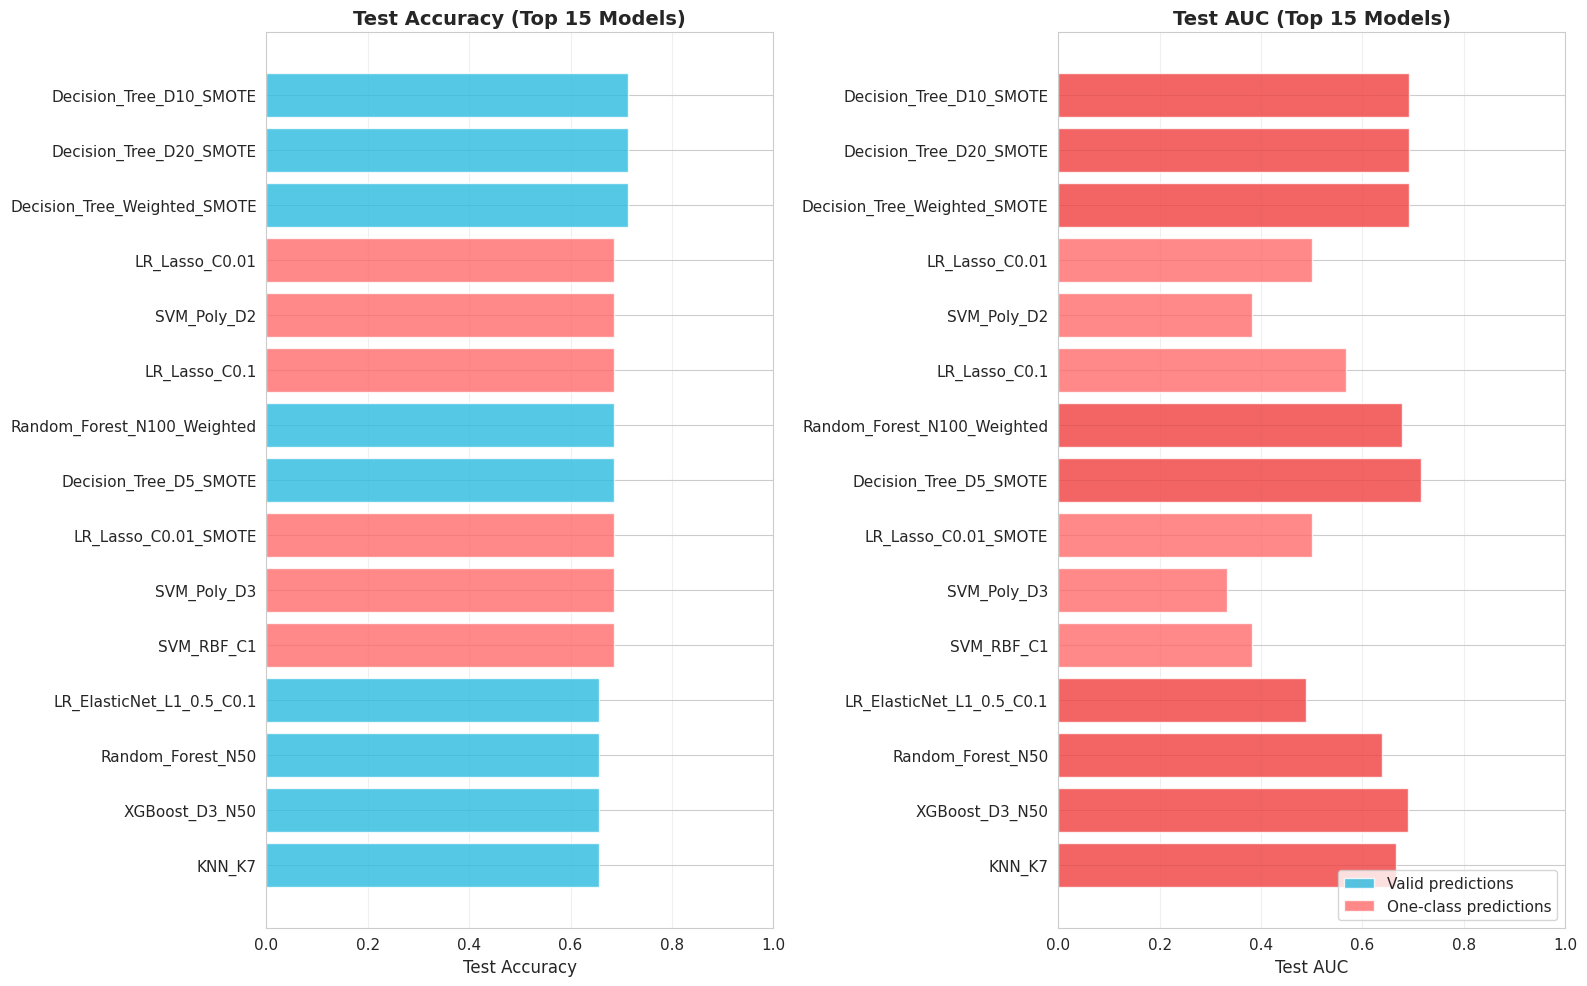

In [ ]:
def plot_top_models_enhanced(results_df, n=15, metric_cols=['test_acc', 'test_auc']):
    """Enhanced performance visualization with better aesthetics"""
    top_n = results_df.head(n).copy()
    top_n = top_n.iloc[::-1]  # Reverse for better display
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    # Test Accuracy
    colors_acc = ['#2bbbdf' if not row['predicts_one_class'] else '#ff6b6b' 
                  for _, row in top_n.iterrows()]
    axes[0].barh(range(len(top_n)), top_n['test_acc'], color=colors_acc, alpha=0.8)
    axes[0].set_yticks(range(len(top_n)))
    axes[0].set_yticklabels(top_n['model'])
    axes[0].set_xlabel('Test Accuracy', fontsize=12)
    axes[0].set_title('Test Accuracy (Top 15 Models)', fontsize=14, weight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Test AUC
    colors_auc = ['#f03f3f' if not row['predicts_one_class'] else '#ff6b6b' 
                  for _, row in top_n.iterrows()]
    axes[1].barh(range(len(top_n)), top_n['test_auc'], color=colors_auc, alpha=0.8)
    axes[1].set_yticks(range(len(top_n)))
    axes[1].set_yticklabels(top_n['model'])
    axes[1].set_xlabel('Test AUC', fontsize=12)
    axes[1].set_title('Test AUC (Top 15 Models)', fontsize=14, weight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].grid(axis='x', alpha=0.3)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2bbbdf', alpha=0.8, label='Valid predictions'),
        Patch(facecolor='#ff6b6b', alpha=0.8, label='One-class predictions')
    ]
    axes[1].legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('fig_top15_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_top_models_enhanced(results_combined_df, n=15)


EXAMPLE: Plot single metrics


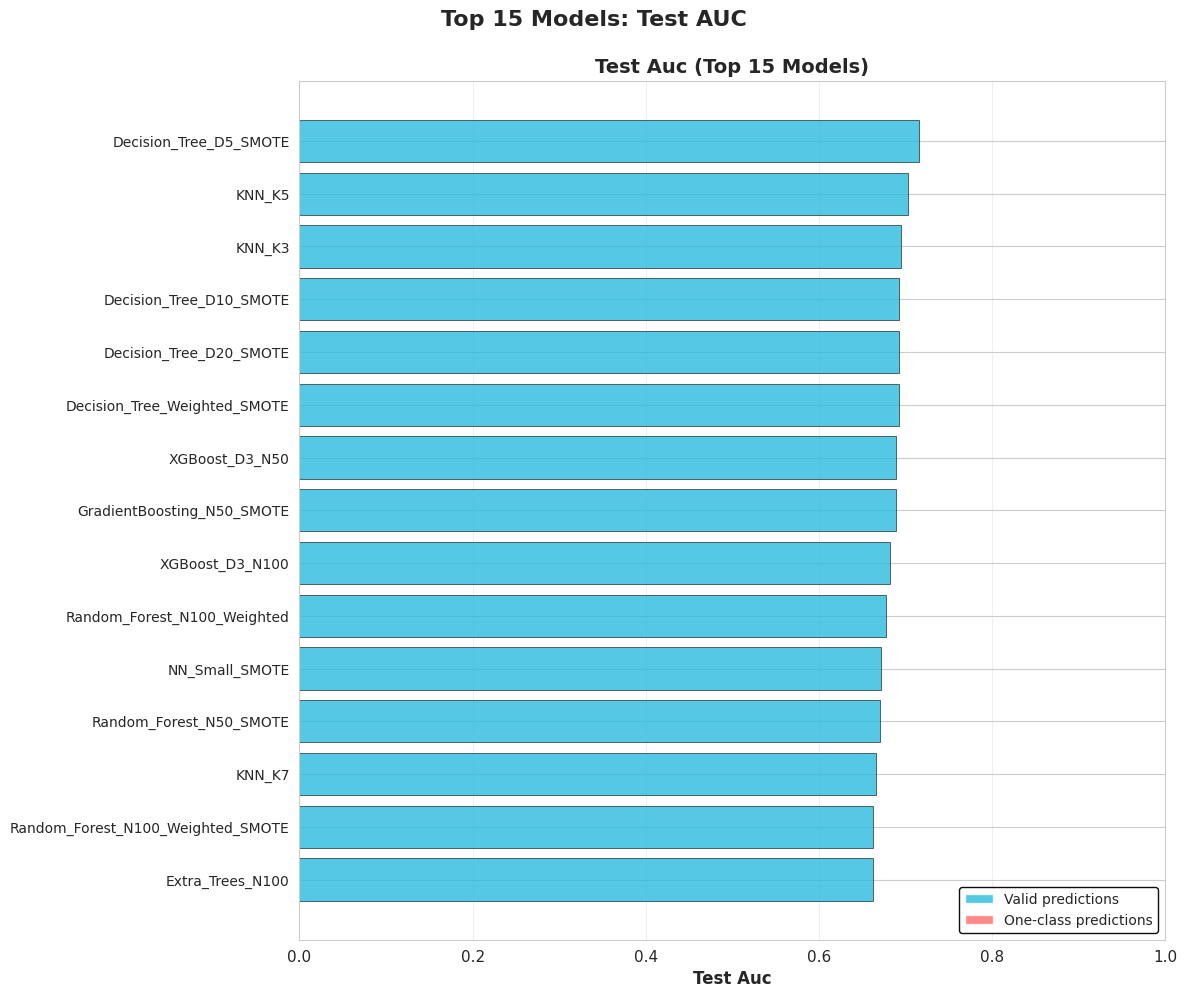

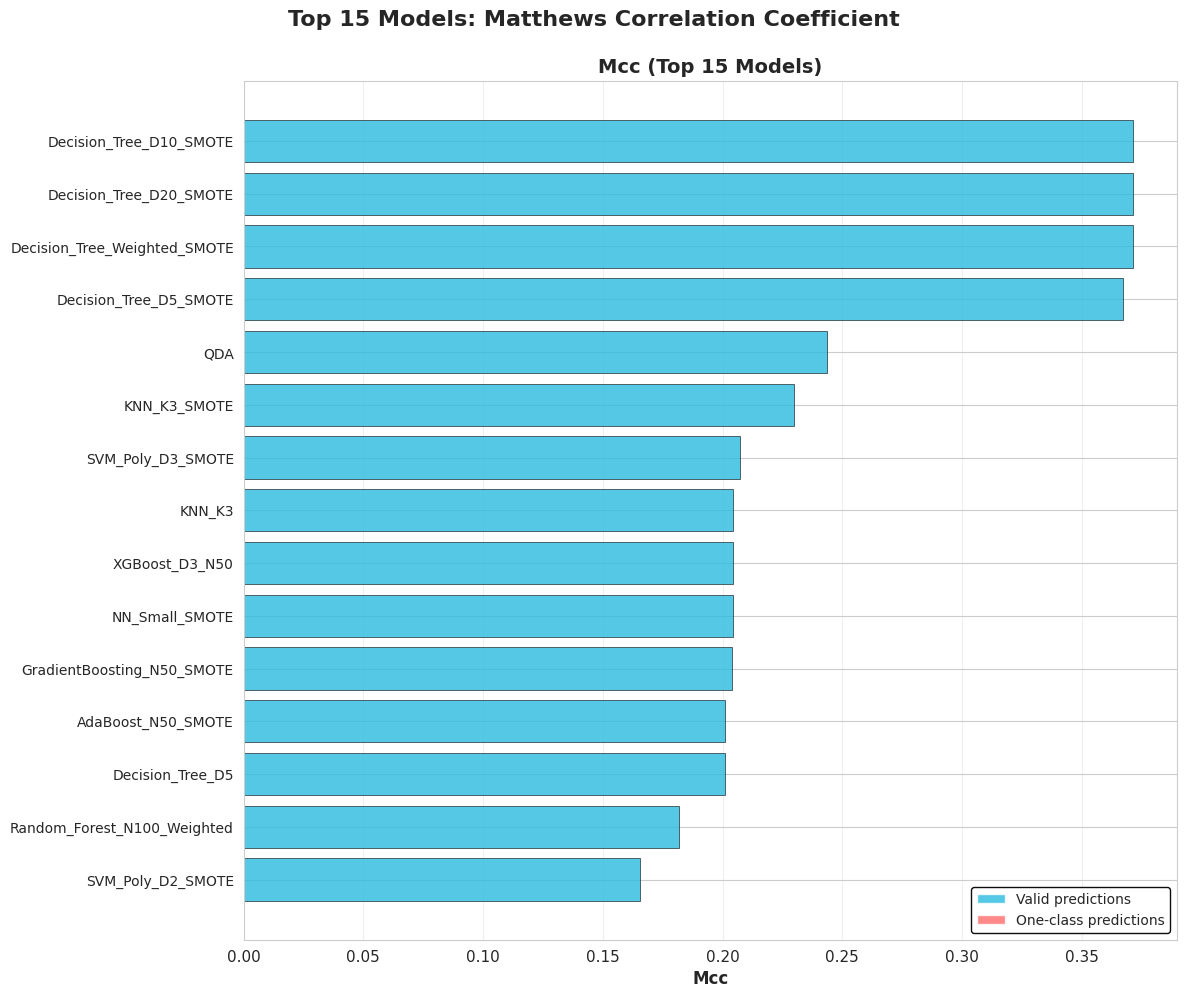

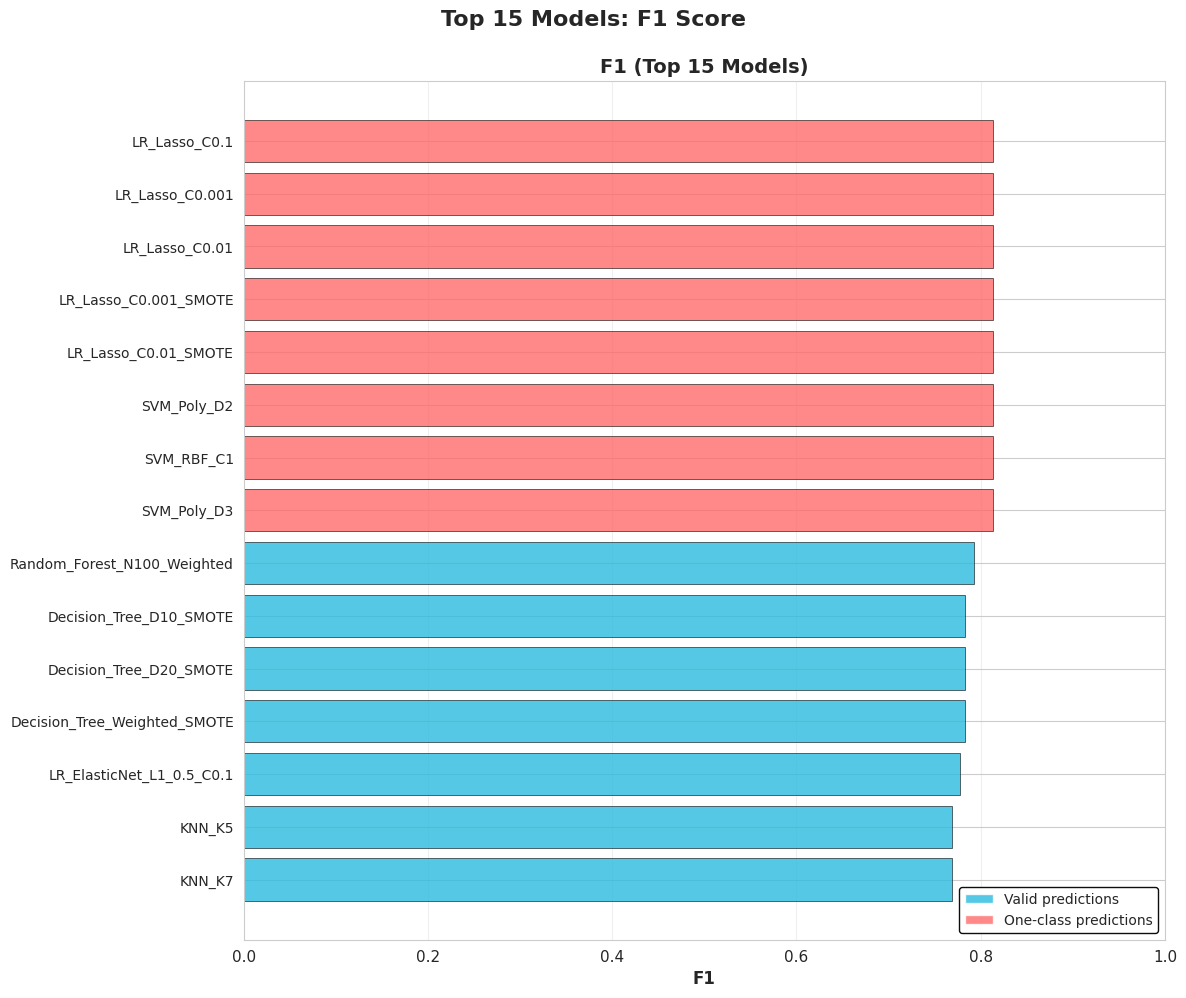

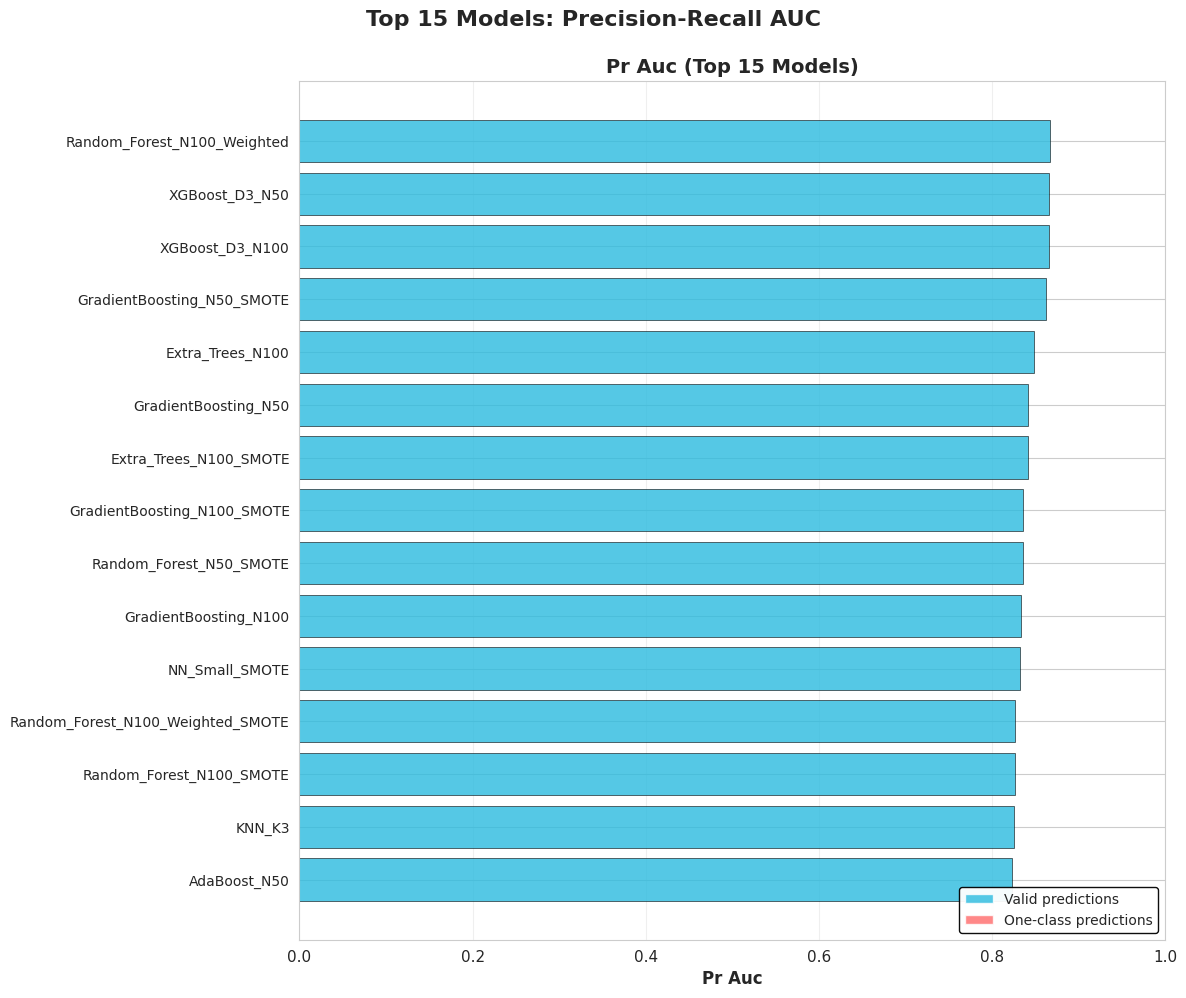

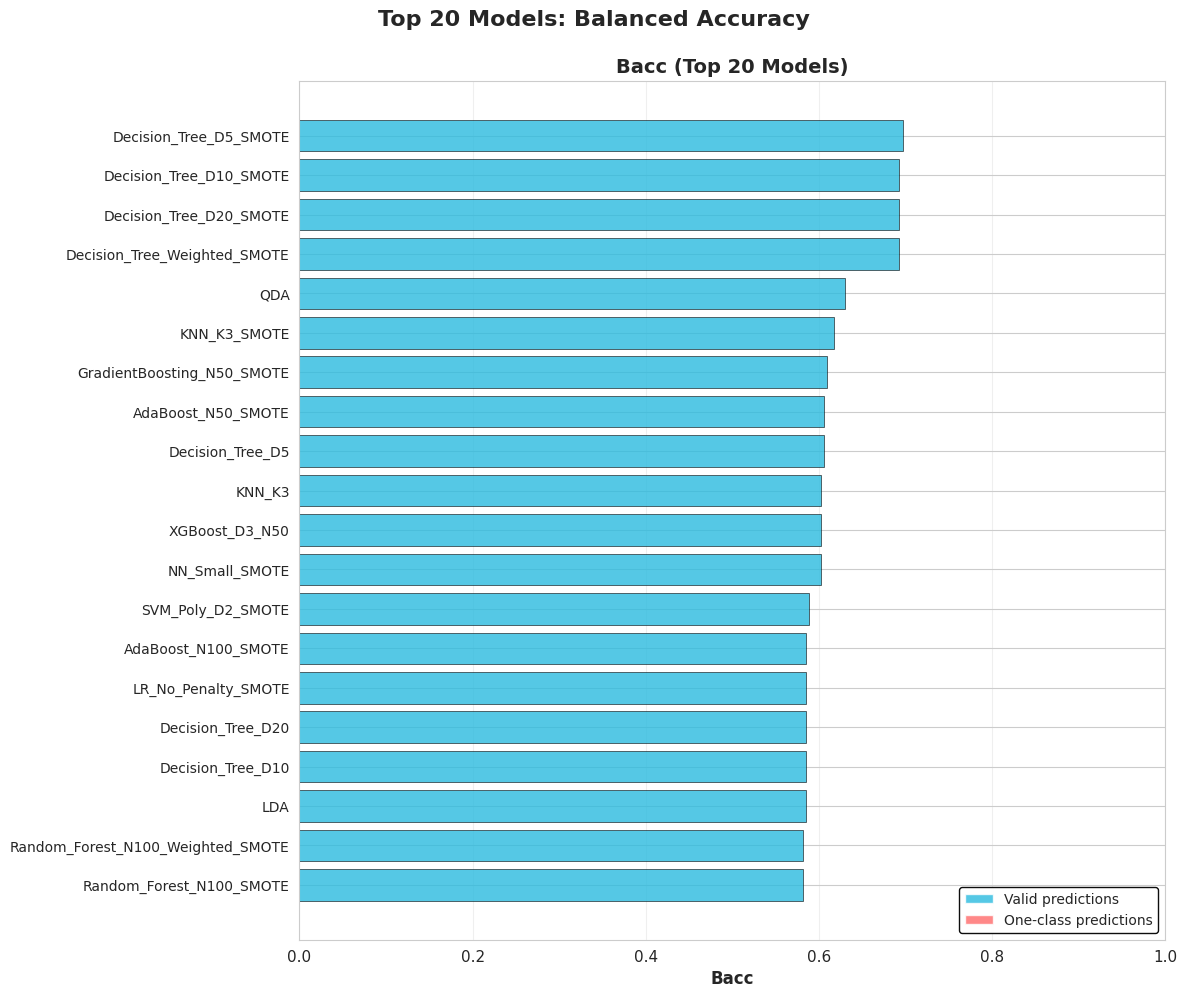

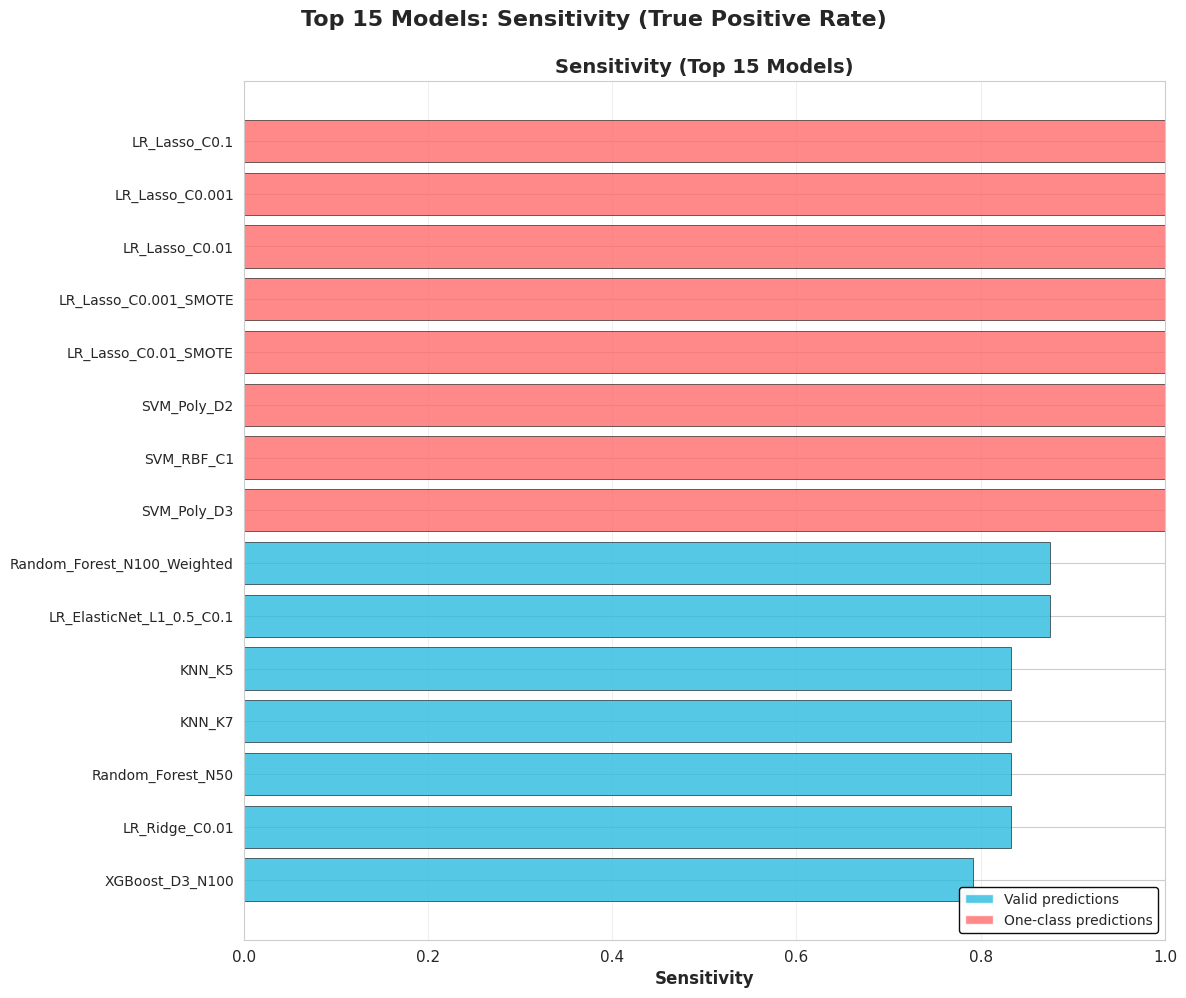

In [35]:
def plot_single_metric(results_df, n=15, metric='test_auc', title=None, figsize=(12, 10)):
    """
    Plot a single metric for top performing models
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Results dataframe with model performance metrics
    n : int
        Number of top models to display (sorted by metric)
    metric : str
        Metric to plot (e.g., 'test_auc', 'test_acc', 'precision', 'recall', 'f1', 'mcc', etc.)
    title : str, optional
        Custom title for the figure
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    
    Examples:
    ---------
    # Plot Test AUC
    plot_single_metric(results_df, n=15, metric='test_auc')
    
    # Plot MCC
    plot_single_metric(results_df, n=20, metric='mcc')
    
    # Plot F1 Score
    plot_single_metric(results_df, n=15, metric='f1')
    
    # Plot PR-AUC
    plot_single_metric(results_df, n=15, metric='pr_auc')
    """
    
    # Validate metric exists
    available_metrics = results_df.columns.tolist()
    if metric not in available_metrics:
        raise ValueError(f"metric '{metric}' not found. Available: {available_metrics}")
    
    # Sort by metric and get top n
    top_n = results_df.nlargest(n, metric).copy()
    top_n = top_n.iloc[::-1]  # Reverse for better display
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine colors based on one-class prediction flag if available
    if 'predicts_one_class' in top_n.columns:
        colors = ['#2bbbdf' if not row['predicts_one_class'] else '#ff6b6b' 
                  for _, row in top_n.iterrows()]
    else:
        colors = '#2bbbdf'
    
    # ===== PLOT METRIC =====
    ax.barh(range(len(top_n)), top_n[metric], color=colors, alpha=0.8, 
            edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(top_n)))
    ax.set_yticklabels(top_n['model'], fontsize=10)
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=12, weight='bold')
    ax.set_title(f'{metric.replace("_", " ").title()} (Top {n} Models)', 
                 fontsize=14, weight='bold')
    
    # Set x-limits based on metric range
    if metric in ['test_acc', 'test_auc', 'precision', 'recall', 'f1', 'pr_auc', 
                  'bacc', 'sensitivity', 'specificity', 'npv', 'train_acc', 'train_auc']:
        ax.set_xlim(0, 1.0)
    
    ax.grid(axis='x', alpha=0.3)
    
    # ===== LEGEND =====
    if 'predicts_one_class' in top_n.columns:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2bbbdf', alpha=0.8, label='Valid predictions'),
            Patch(facecolor='#ff6b6b', alpha=0.8, label='One-class predictions')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=10, 
                  framealpha=0.95, edgecolor='black')
    
    # ===== TITLE =====
    if title is None:
        title = f'Top {n} Models by {metric.upper()}'
    
    fig.suptitle(title, fontsize=16, weight='bold', y=0.995)
    
    plt.tight_layout()
    
    return fig


# Example usage:
print("="*80)
print("EXAMPLE: Plot single metrics")
print("="*80)

# Example 1: Test AUC
fig1 = plot_single_metric(results_combined_df, n=15, metric='test_auc',
                          title='Top 15 Models: Test AUC')
plt.savefig('fig_top15_test_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 2: MCC
fig2 = plot_single_metric(results_combined_df, n=15, metric='mcc',
                          title='Top 15 Models: Matthews Correlation Coefficient')
plt.savefig('fig_top15_mcc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 3: F1 Score
fig3 = plot_single_metric(results_combined_df, n=15, metric='f1',
                          title='Top 15 Models: F1 Score')
plt.savefig('fig_top15_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 4: PR-AUC
fig4 = plot_single_metric(results_combined_df, n=15, metric='pr_auc',
                          title='Top 15 Models: Precision-Recall AUC')
plt.savefig('fig_top15_pr_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 5: Balanced Accuracy
fig5 = plot_single_metric(results_combined_df, n=20, metric='bacc',
                          title='Top 20 Models: Balanced Accuracy')
plt.savefig('fig_top20_bacc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 6: Sensitivity
fig6 = plot_single_metric(results_combined_df, n=15, metric='sensitivity',
                          title='Top 15 Models: Sensitivity (True Positive Rate)')
plt.savefig('fig_top15_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()


EXAMPLE: Plot different metric combinations


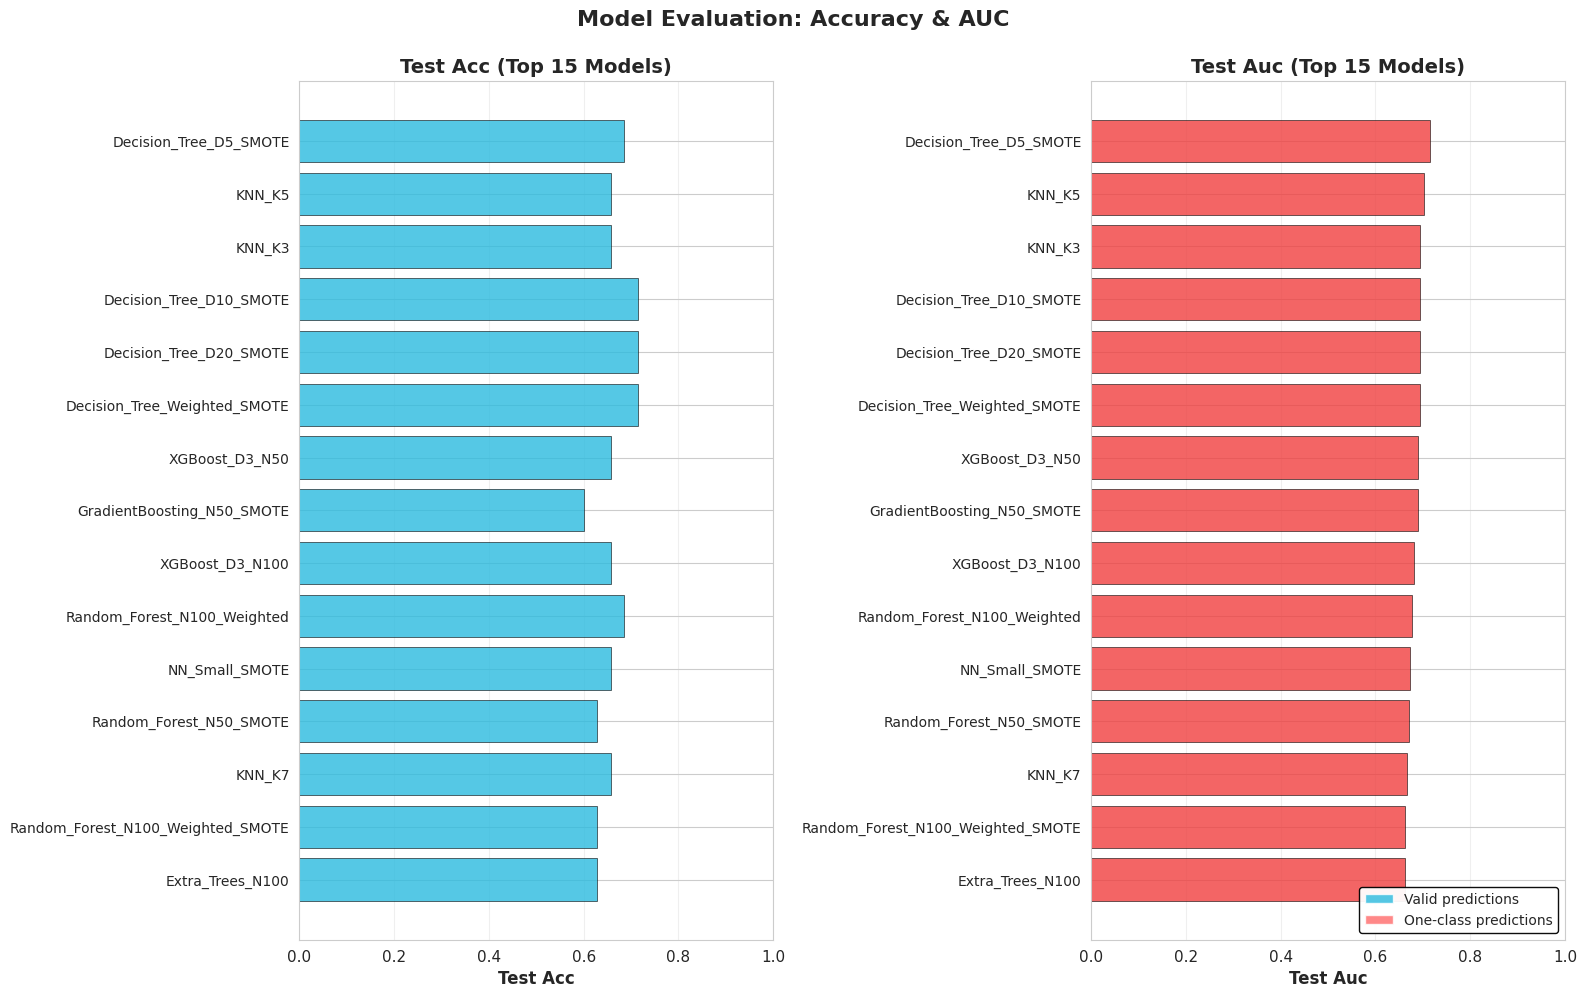

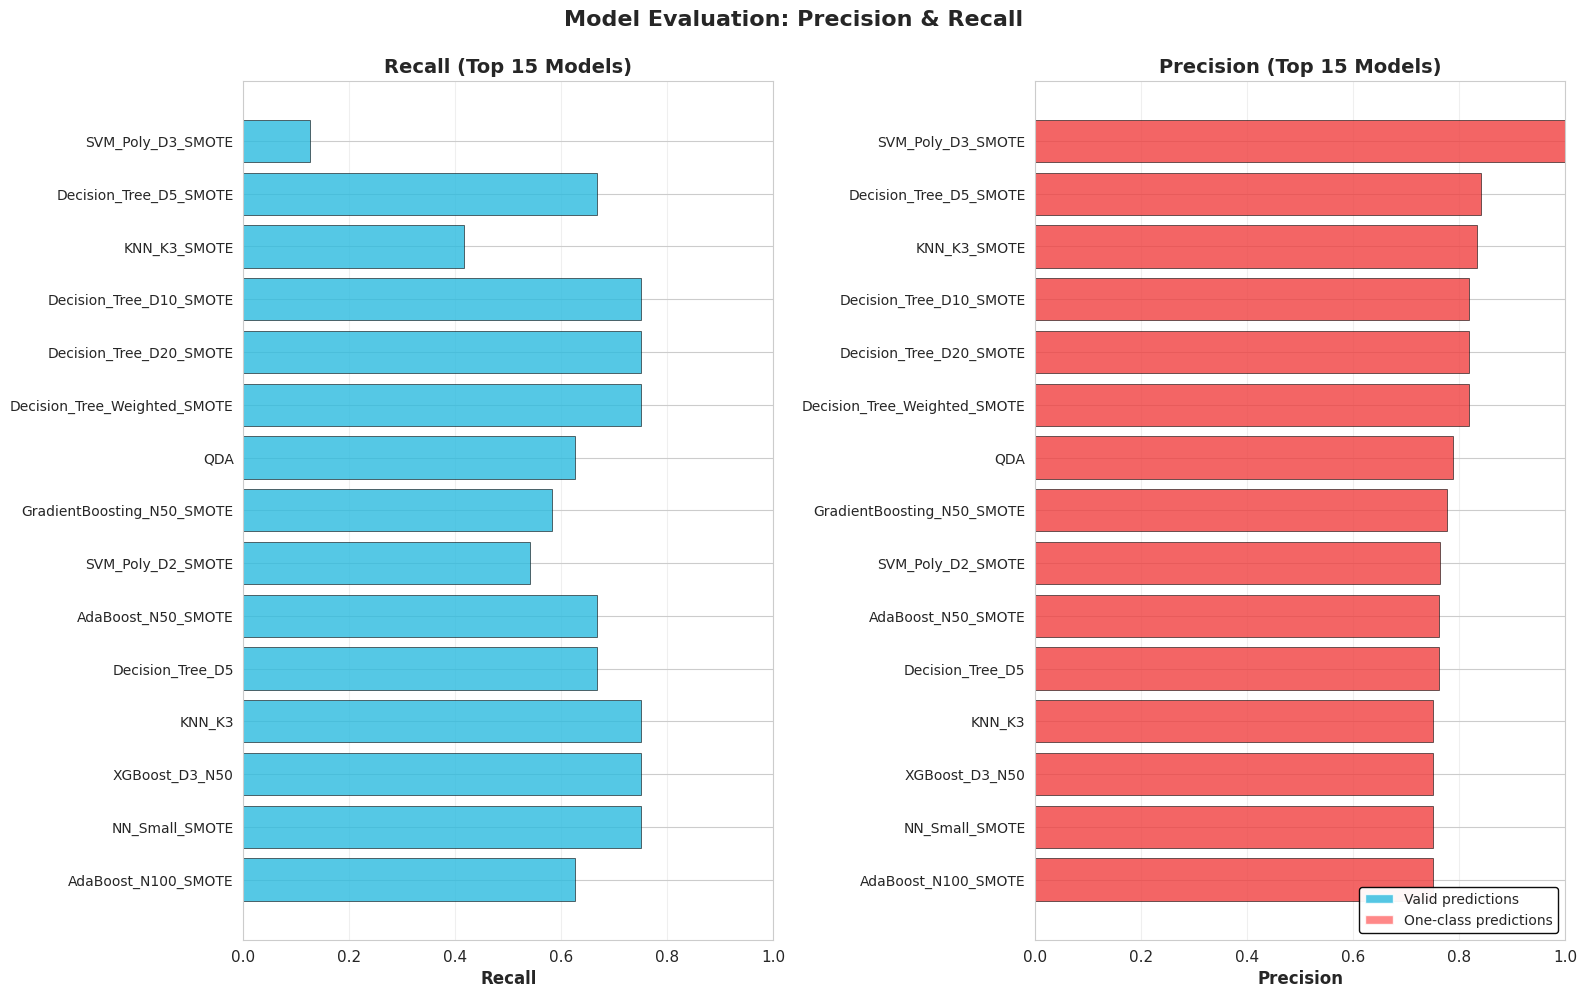

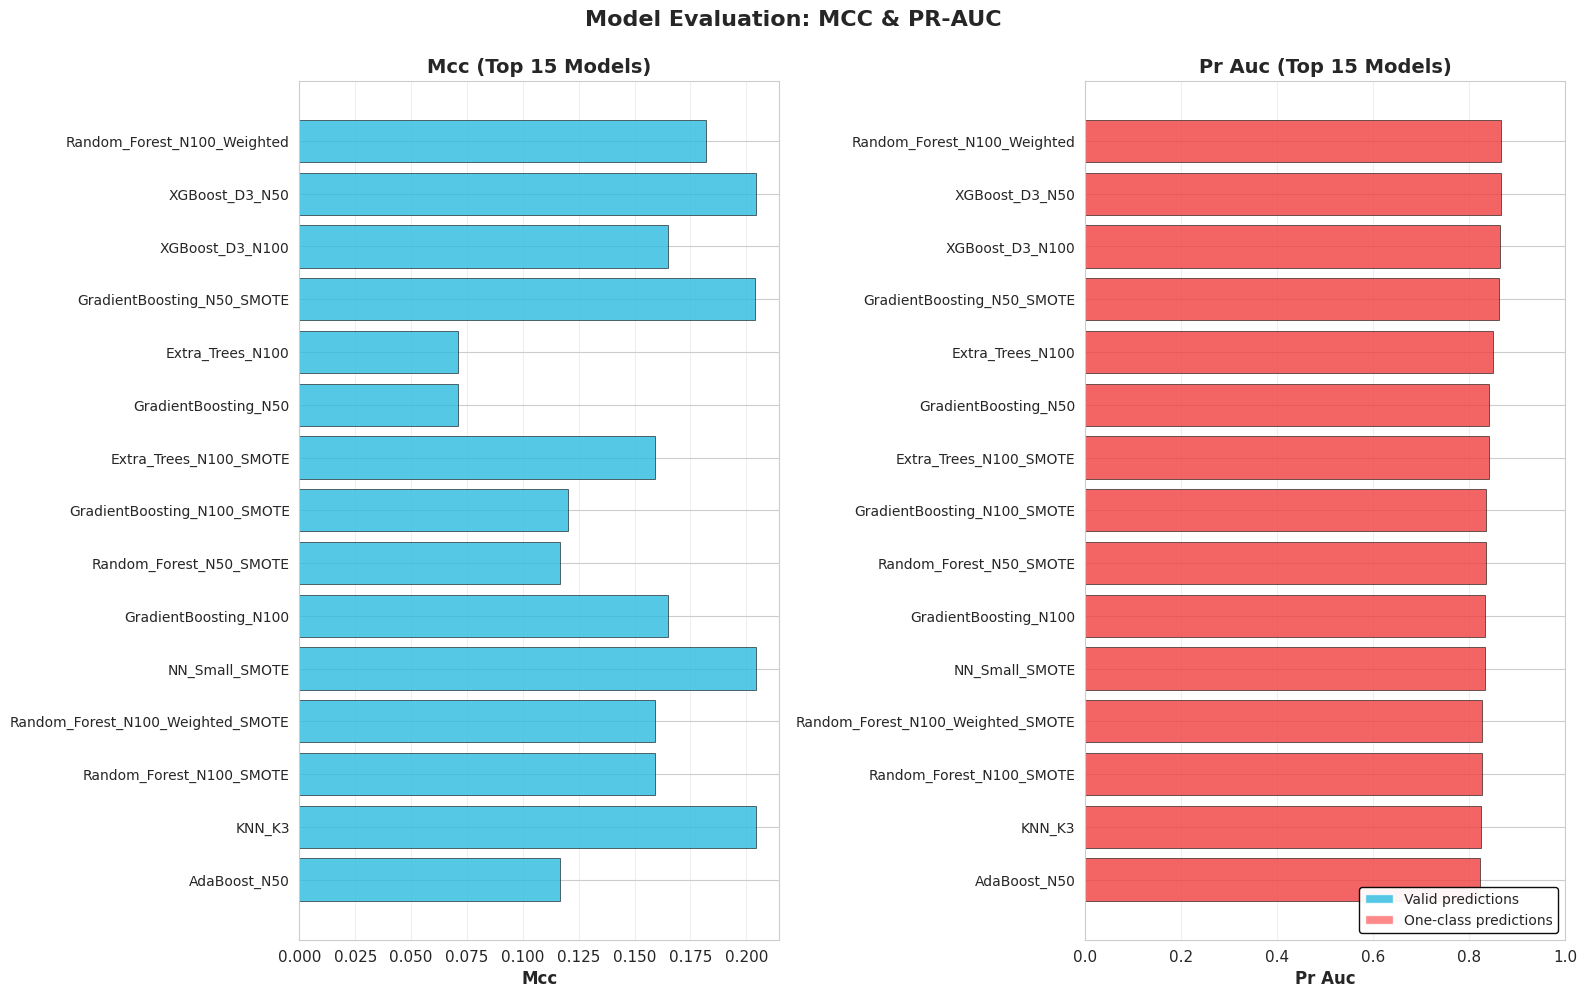

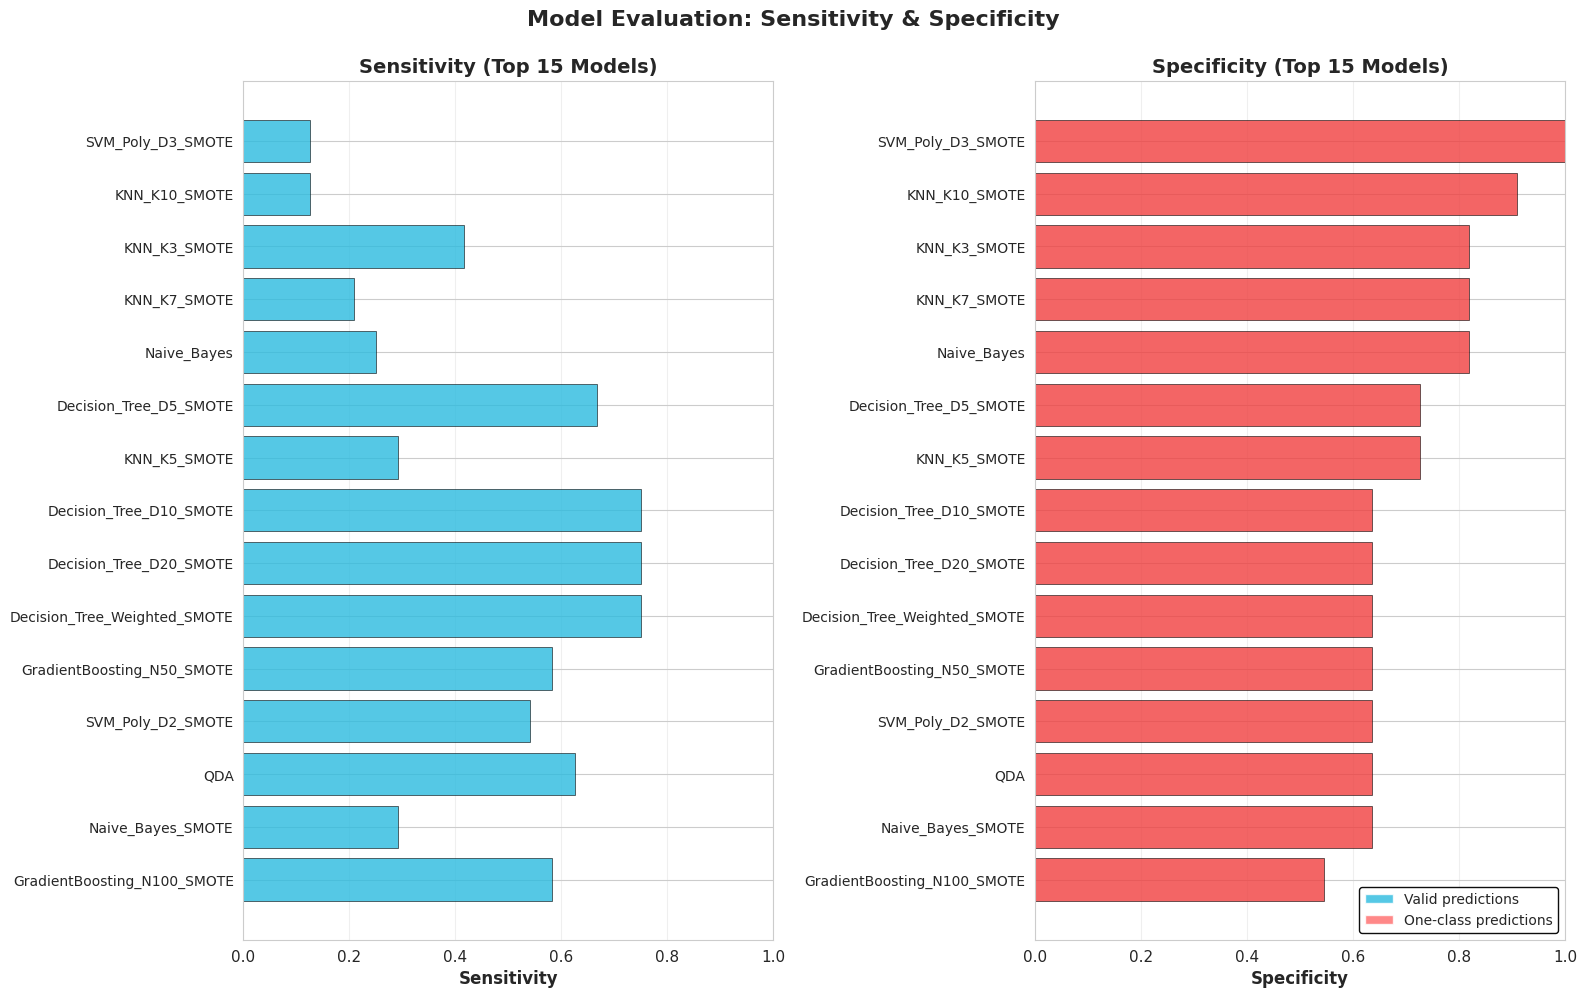

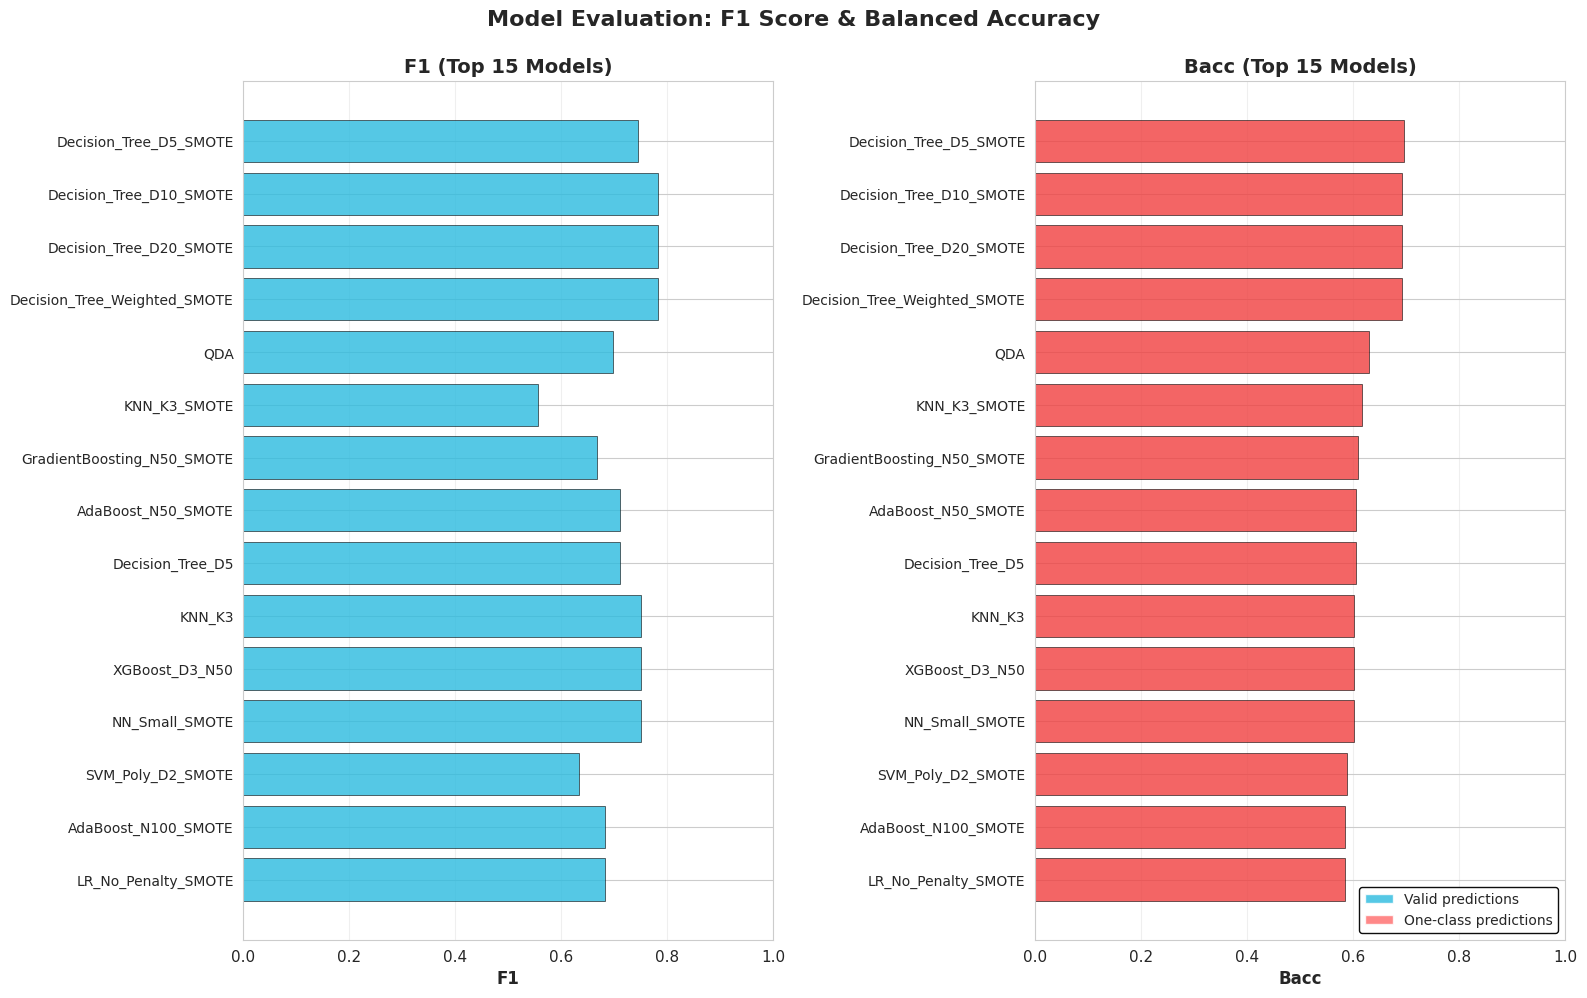

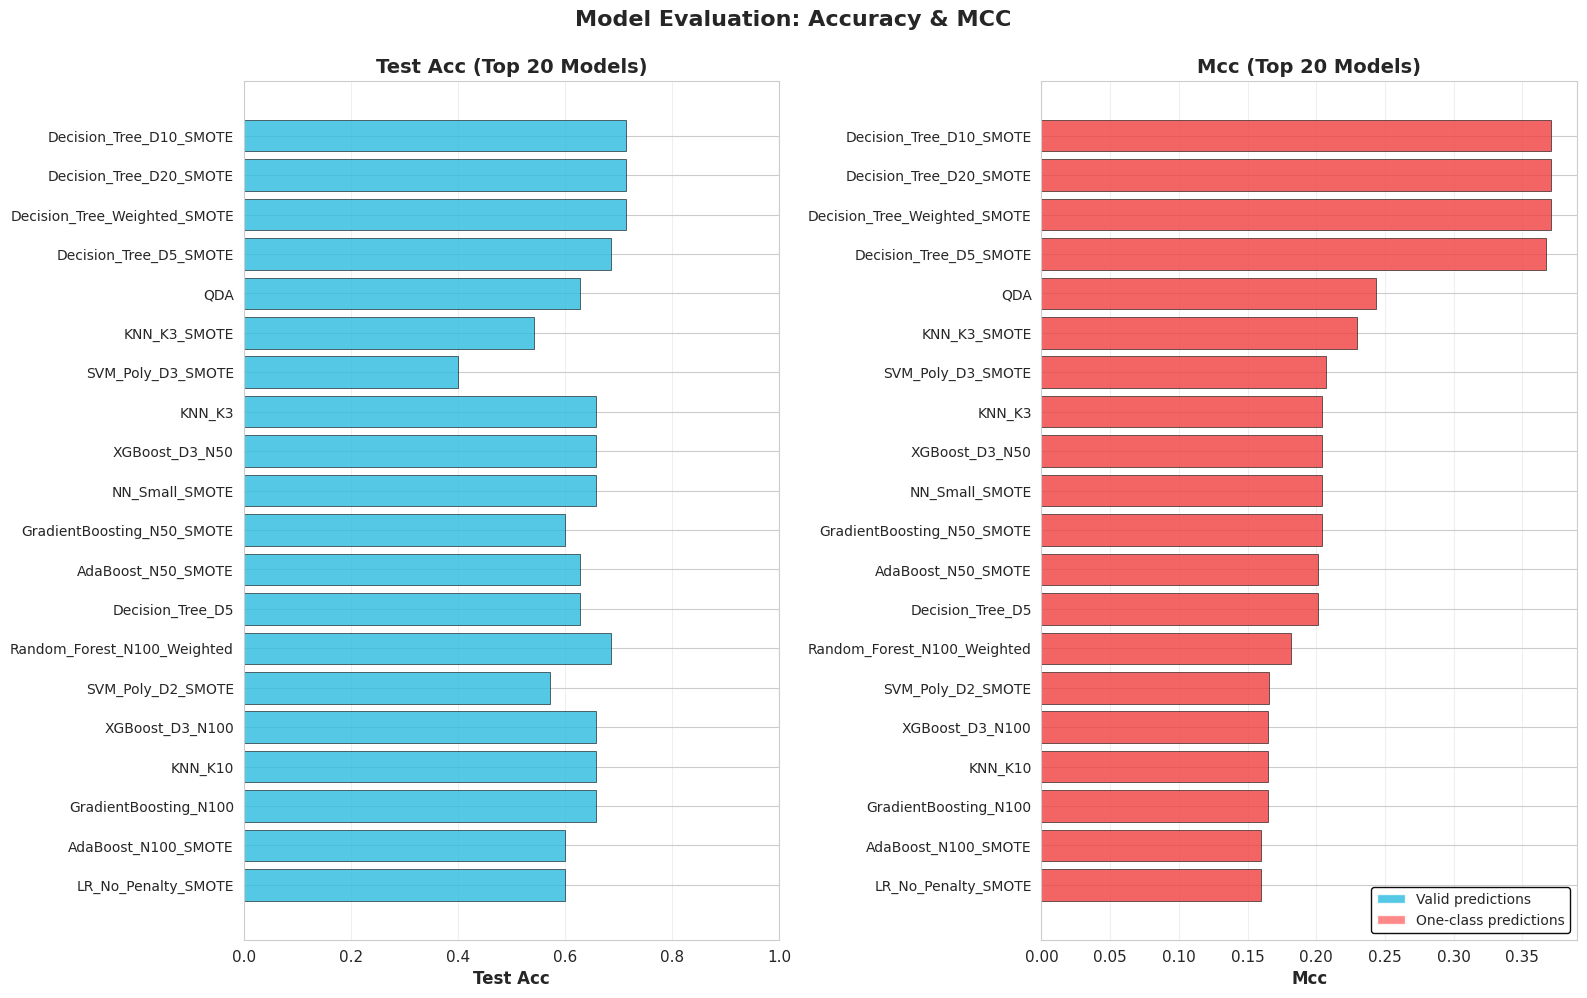

In [34]:
def plot_top_models_flexible(results_df, n=15, metric_x='test_acc', metric_y='test_auc', 
                             title=None, figsize=(16, 10)):
    # Validate metrics exist
    available_metrics = results_df.columns.tolist()
    if metric_x not in available_metrics:
        raise ValueError(f"metric_x '{metric_x}' not found. Available: {available_metrics}")
    if metric_y not in available_metrics:
        raise ValueError(f"metric_y '{metric_y}' not found. Available: {available_metrics}")
    
    # Sort by metric_y and get top n
    top_n = results_df.nlargest(n, metric_y).copy()
    top_n = top_n.iloc[::-1]  # Reverse for better display
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Determine colors based on one-class prediction flag if available
    if 'predicts_one_class' in top_n.columns:
        colors_x = ['#2bbbdf' if not row['predicts_one_class'] else '#ff6b6b' 
                    for _, row in top_n.iterrows()]
        colors_y = ['#f03f3f' if not row['predicts_one_class'] else '#ff6b6b' 
                    for _, row in top_n.iterrows()]
    else:
        colors_x = '#2bbbdf'
        colors_y = '#f03f3f'
    
    # ===== FIRST METRIC =====
    axes[0].barh(range(len(top_n)), top_n[metric_x], color=colors_x, alpha=0.8, 
                edgecolor='black', linewidth=0.5)
    axes[0].set_yticks(range(len(top_n)))
    axes[0].set_yticklabels(top_n['model'], fontsize=10)
    axes[0].set_xlabel(metric_x.replace('_', ' ').title(), fontsize=12, weight='bold')
    axes[0].set_title(f'{metric_x.replace("_", " ").title()} (Top {n} Models)', 
                     fontsize=14, weight='bold')
    
    # Set x-limits based on metric range
    if metric_x in ['test_acc', 'test_auc', 'precision', 'recall', 'f1', 'pr_auc', 
                    'bacc', 'sensitivity', 'specificity', 'npv']:
        axes[0].set_xlim(0, 1.0)
    
    axes[0].grid(axis='x', alpha=0.3)
    
    # ===== SECOND METRIC =====
    axes[1].barh(range(len(top_n)), top_n[metric_y], color=colors_y, alpha=0.8,
                edgecolor='black', linewidth=0.5)
    axes[1].set_yticks(range(len(top_n)))
    axes[1].set_yticklabels(top_n['model'], fontsize=10)
    axes[1].set_xlabel(metric_y.replace('_', ' ').title(), fontsize=12, weight='bold')
    axes[1].set_title(f'{metric_y.replace("_", " ").title()} (Top {n} Models)', 
                     fontsize=14, weight='bold')
    
    # Set x-limits based on metric range
    if metric_y in ['test_acc', 'test_auc', 'precision', 'recall', 'f1', 'pr_auc', 
                    'bacc', 'sensitivity', 'specificity', 'npv']:
        axes[1].set_xlim(0, 1.0)
    
    axes[1].grid(axis='x', alpha=0.3)
    
    # ===== LEGEND =====
    if 'predicts_one_class' in top_n.columns:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2bbbdf', alpha=0.8, label='Valid predictions'),
            Patch(facecolor='#ff6b6b', alpha=0.8, label='One-class predictions')
        ]
        axes[1].legend(handles=legend_elements, loc='lower right', fontsize=10, 
                      framealpha=0.95, edgecolor='black')
    
    # ===== TITLE =====
    if title is None:
        title = f'Model Performance Comparison: {metric_x.upper()} vs {metric_y.upper()}'
    
    fig.suptitle(title, fontsize=16, weight='bold', y=0.995)
    
    plt.tight_layout()
    
    return fig


# Example usage:
print("="*80)
print("EXAMPLE: Plot different metric combinations")
print("="*80)

# Example 1: Test Accuracy vs Test AUC (default)
fig1 = plot_top_models_flexible(results_combined_df, n=15, 
                                metric_x='test_acc', metric_y='test_auc',
                                title='Model Evaluation: Accuracy & AUC')
plt.savefig('fig_top15_acc_vs_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 2: Precision vs Recall
fig2 = plot_top_models_flexible(results_combined_df, n=15,
                                metric_x='recall', metric_y='precision',
                                title='Model Evaluation: Precision & Recall')
plt.savefig('fig_top15_precision_vs_recall.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 3: MCC vs PR-AUC
fig3 = plot_top_models_flexible(results_combined_df, n=15,
                                metric_x='mcc', metric_y='pr_auc',
                                title='Model Evaluation: MCC & PR-AUC')
plt.savefig('fig_top15_mcc_vs_prauc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 4: Sensitivity vs Specificity
fig4 = plot_top_models_flexible(results_combined_df, n=15,
                                metric_x='sensitivity', metric_y='specificity',
                                title='Model Evaluation: Sensitivity & Specificity')
plt.savefig('fig_top15_sensitivity_vs_specificity.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 5: F1 vs Balanced Accuracy
fig5 = plot_top_models_flexible(results_combined_df, n=15,
                                metric_x='f1', metric_y='bacc',
                                title='Model Evaluation: F1 Score & Balanced Accuracy')
plt.savefig('fig_top15_f1_vs_bacc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 6: Test Accuracy vs MCC
fig6 = plot_top_models_flexible(results_combined_df, n=20,
                                metric_x='test_acc', metric_y='mcc',
                                title='Model Evaluation: Accuracy & MCC')
plt.savefig('fig_top20_acc_vs_mcc.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
# Add this BEFORE the quantify_smote_effect execution section

def assign_model_group(name):
    """Assign models to categories for grouped analysis"""
    if 'SMOTE' in name:
        return 'SMOTE Variants'
    elif any(k in name for k in ['LR_', 'Ridge_Classifier', 'SGD_Classifier']):
        return 'Linear / Penalized'
    elif 'Decision_Tree' in name and not any(x in name for x in ['Random', 'Extra']):
        return 'Single Tree'
    elif any(k in name for k in ['Random_Forest', 'Extra_Trees']):
        return 'Random Forest / ExtraTrees'
    elif any(k in name for k in ['AdaBoost', 'GradientBoosting', 'XGBoost']):
        return 'Boosting Ensembles'
    elif 'SVM_' in name:
        return 'SVM'
    elif 'KNN_' in name:
        return 'KNN'
    elif 'NN_' in name:
        return 'Neural Networks'
    elif name in ['LDA', 'QDA']:
        return 'Discriminant Analysis'
    elif name == 'Naive_Bayes':
        return 'Naive Bayes'
    else:
        return 'Other'


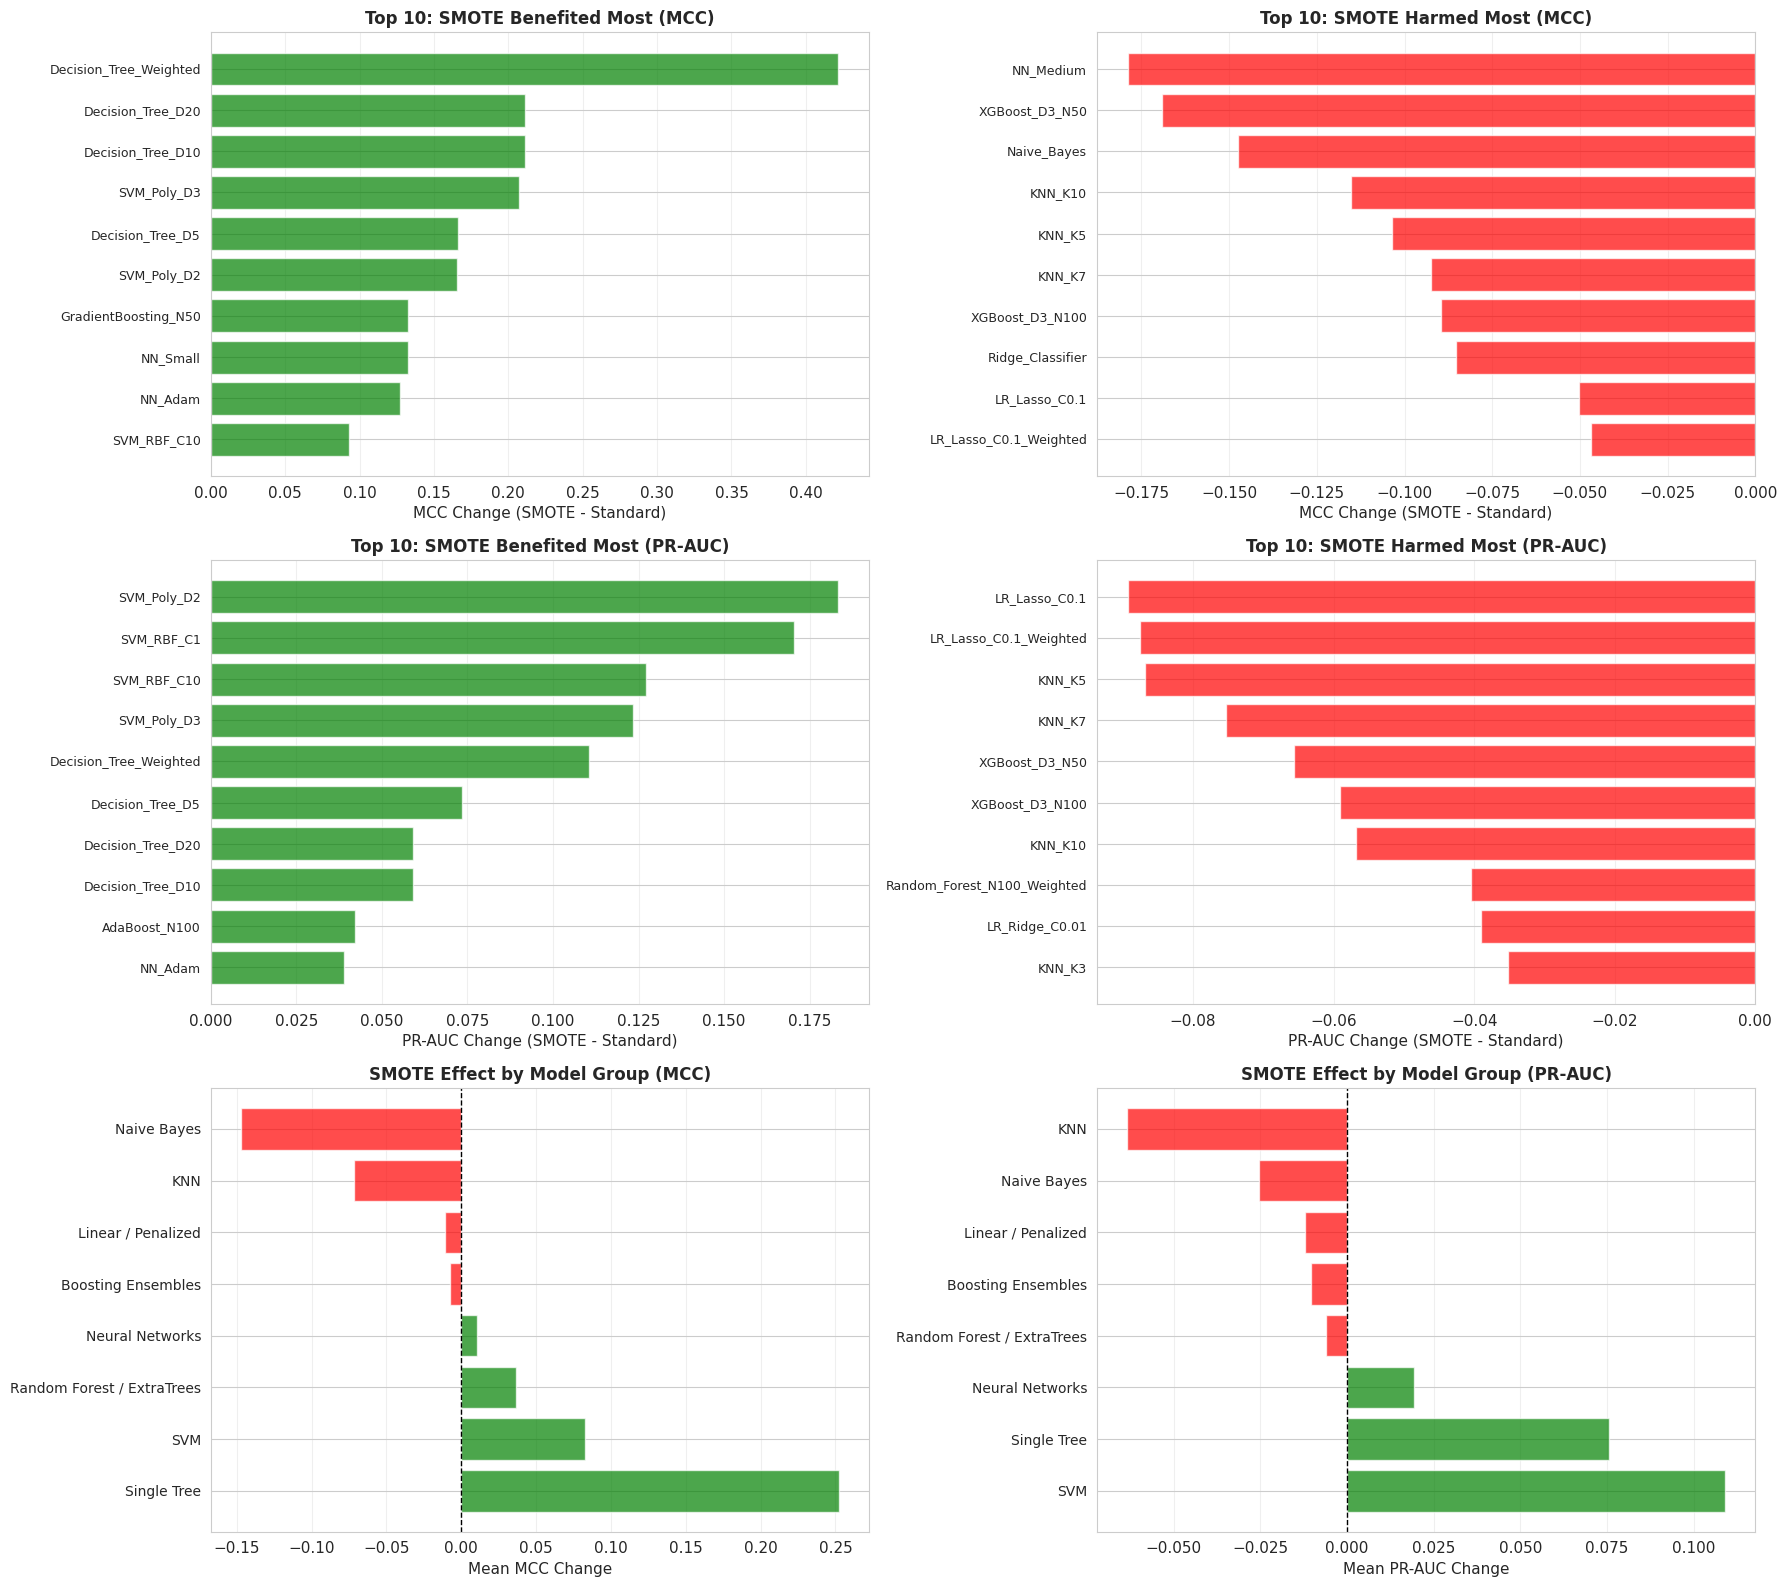


SMOTE IMPACT ANALYSIS (MCC & PR-AUC)

Top 5 Models Benefited (MCC):
                 Model  Delta_MCC  Standard_MCC  SMOTE_MCC
Decision_Tree_Weighted   0.421458     -0.050252   0.371206
     Decision_Tree_D20   0.211306      0.159901   0.371206
     Decision_Tree_D10   0.211306      0.159901   0.371206
           SVM_Poly_D3   0.207289      0.000000   0.207289
      Decision_Tree_D5   0.166101      0.201008   0.367109

Top 5 Models Harmed (MCC):
         Model  Delta_MCC  Standard_MCC  SMOTE_MCC
     NN_Medium  -0.178761      0.159299  -0.019462
XGBoost_D3_N50  -0.169012      0.204545   0.035533
   Naive_Bayes  -0.147348      0.075378  -0.071970
       KNN_K10  -0.115215      0.164958   0.049743
        KNN_K5  -0.103629      0.123091   0.019462

Group-Level Summary (MCC):
                           Delta_MCC                        
                                mean     std     min     max
Group                                                       
Boosting Ensembles           -0.

In [42]:
def quantify_smote_effect(results_standard_df, results_smote_df):
    """
    Analyze SMOTE impact using pre-computed results
    No model retraining needed - just compare existing metrics
    """
    
    # Merge standard and SMOTE results for direct comparison
    smote_comparison = []
    
    for model_name in results_standard_df['model'].unique():
        std_row = results_standard_df[results_standard_df['model'] == model_name]
        smote_row = results_smote_df[results_smote_df['model'].str.replace('_SMOTE', '') == model_name]
        
        if len(std_row) > 0 and len(smote_row) > 0:
            std_data = std_row.iloc[0]
            smote_data = smote_row.iloc[0]
            
            # Calculate deltas for MCC and PR-AUC
            delta_mcc = smote_data['mcc'] - std_data['mcc']
            delta_pr_auc = smote_data['pr_auc'] - std_data['pr_auc']
            
            smote_comparison.append({
                'Model': model_name,
                'Group': assign_model_group(model_name),
                'Standard_MCC': std_data['mcc'],
                'SMOTE_MCC': smote_data['mcc'],
                'Delta_MCC': delta_mcc,
                'Standard_PR_AUC': std_data['pr_auc'],
                'SMOTE_PR_AUC': smote_data['pr_auc'],
                'Delta_PR_AUC': delta_pr_auc,
            })
    
    smote_df = pd.DataFrame(smote_comparison)
    
    # Visualization with group-level effects
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    
    # Top 10 benefited (by MCC)
    top_benefit = smote_df.nlargest(10, 'Delta_MCC')
    axes[0, 0].barh(range(len(top_benefit)), top_benefit['Delta_MCC'], color='green', alpha=0.7)
    axes[0, 0].set_yticks(range(len(top_benefit)))
    axes[0, 0].set_yticklabels(top_benefit['Model'], fontsize=9)
    axes[0, 0].set_xlabel('MCC Change (SMOTE - Standard)', fontsize=11)
    axes[0, 0].set_title('Top 10: SMOTE Benefited Most (MCC)', fontsize=12, weight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].invert_yaxis()
    
    # Top 10 harmed (by MCC)
    top_harm = smote_df.nsmallest(10, 'Delta_MCC')
    axes[0, 1].barh(range(len(top_harm)), top_harm['Delta_MCC'], color='red', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_harm)))
    axes[0, 1].set_yticklabels(top_harm['Model'], fontsize=9)
    axes[0, 1].set_xlabel('MCC Change (SMOTE - Standard)', fontsize=11)
    axes[0, 1].set_title('Top 10: SMOTE Harmed Most (MCC)', fontsize=12, weight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_yaxis()
    
    # Top 10 benefited (by PR-AUC)
    top_benefit_pr = smote_df.nlargest(10, 'Delta_PR_AUC')
    axes[1, 0].barh(range(len(top_benefit_pr)), top_benefit_pr['Delta_PR_AUC'], color='green', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_benefit_pr)))
    axes[1, 0].set_yticklabels(top_benefit_pr['Model'], fontsize=9)
    axes[1, 0].set_xlabel('PR-AUC Change (SMOTE - Standard)', fontsize=11)
    axes[1, 0].set_title('Top 10: SMOTE Benefited Most (PR-AUC)', fontsize=12, weight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    axes[1, 0].invert_yaxis()
    
    # Top 10 harmed (by PR-AUC)
    top_harm_pr = smote_df.nsmallest(10, 'Delta_PR_AUC')
    axes[1, 1].barh(range(len(top_harm_pr)), top_harm_pr['Delta_PR_AUC'], color='red', alpha=0.7)
    axes[1, 1].set_yticks(range(len(top_harm_pr)))
    axes[1, 1].set_yticklabels(top_harm_pr['Model'], fontsize=9)
    axes[1, 1].set_xlabel('PR-AUC Change (SMOTE - Standard)', fontsize=11)
    axes[1, 1].set_title('Top 10: SMOTE Harmed Most (PR-AUC)', fontsize=12, weight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    axes[1, 1].invert_yaxis()
    
    # Group-level effects (MCC)
    group_effects_mcc = smote_df.groupby('Group')['Delta_MCC'].mean().sort_values()
    colors_group_mcc = ['green' if x > 0 else 'red' for x in group_effects_mcc]
    axes[2, 0].barh(range(len(group_effects_mcc)), group_effects_mcc, color=colors_group_mcc, alpha=0.7)
    axes[2, 0].set_yticks(range(len(group_effects_mcc)))
    axes[2, 0].set_yticklabels(group_effects_mcc.index, fontsize=10)
    axes[2, 0].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[2, 0].set_xlabel('Mean MCC Change', fontsize=11)
    axes[2, 0].set_title('SMOTE Effect by Model Group (MCC)', fontsize=12, weight='bold')
    axes[2, 0].grid(axis='x', alpha=0.3)
    axes[2, 0].invert_yaxis()
    
    # Group-level effects (PR-AUC)
    group_effects_pr = smote_df.groupby('Group')['Delta_PR_AUC'].mean().sort_values()
    colors_group_pr = ['green' if x > 0 else 'red' for x in group_effects_pr]
    axes[2, 1].barh(range(len(group_effects_pr)), group_effects_pr, color=colors_group_pr, alpha=0.7)
    axes[2, 1].set_yticks(range(len(group_effects_pr)))
    axes[2, 1].set_yticklabels(group_effects_pr.index, fontsize=10)
    axes[2, 1].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[2, 1].set_xlabel('Mean PR-AUC Change', fontsize=11)
    axes[2, 1].set_title('SMOTE Effect by Model Group (PR-AUC)', fontsize=12, weight='bold')
    axes[2, 1].grid(axis='x', alpha=0.3)
    axes[2, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('fig_smote_mcc_prauc_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("SMOTE IMPACT ANALYSIS (MCC & PR-AUC)")
    print("="*80)
    print("\nTop 5 Models Benefited (MCC):")
    print(smote_df.nlargest(5, 'Delta_MCC')[['Model', 'Delta_MCC', 'Standard_MCC', 'SMOTE_MCC']].to_string(index=False))
    
    print("\nTop 5 Models Harmed (MCC):")
    print(smote_df.nsmallest(5, 'Delta_MCC')[['Model', 'Delta_MCC', 'Standard_MCC', 'SMOTE_MCC']].to_string(index=False))
    
    print("\nGroup-Level Summary (MCC):")
    group_summary_mcc = smote_df.groupby('Group').agg({
        'Delta_MCC': ['mean', 'std', 'min', 'max']
    }).round(4)
    print(group_summary_mcc)
    
    print("\nGroup-Level Summary (PR-AUC):")
    group_summary_pr = smote_df.groupby('Group').agg({
        'Delta_PR_AUC': ['mean', 'std', 'min', 'max']
    }).round(4)
    print(group_summary_pr)
    
    smote_df.to_csv('smote_impact_mcc_prauc.csv', index=False)
    print("\n✓ SMOTE analysis exported")
    
    return smote_df

# Execute with existing results
smote_impact_df = quantify_smote_effect(results_standard_df, results_smote_df)

## Cross-Validation Performance with Error Bars

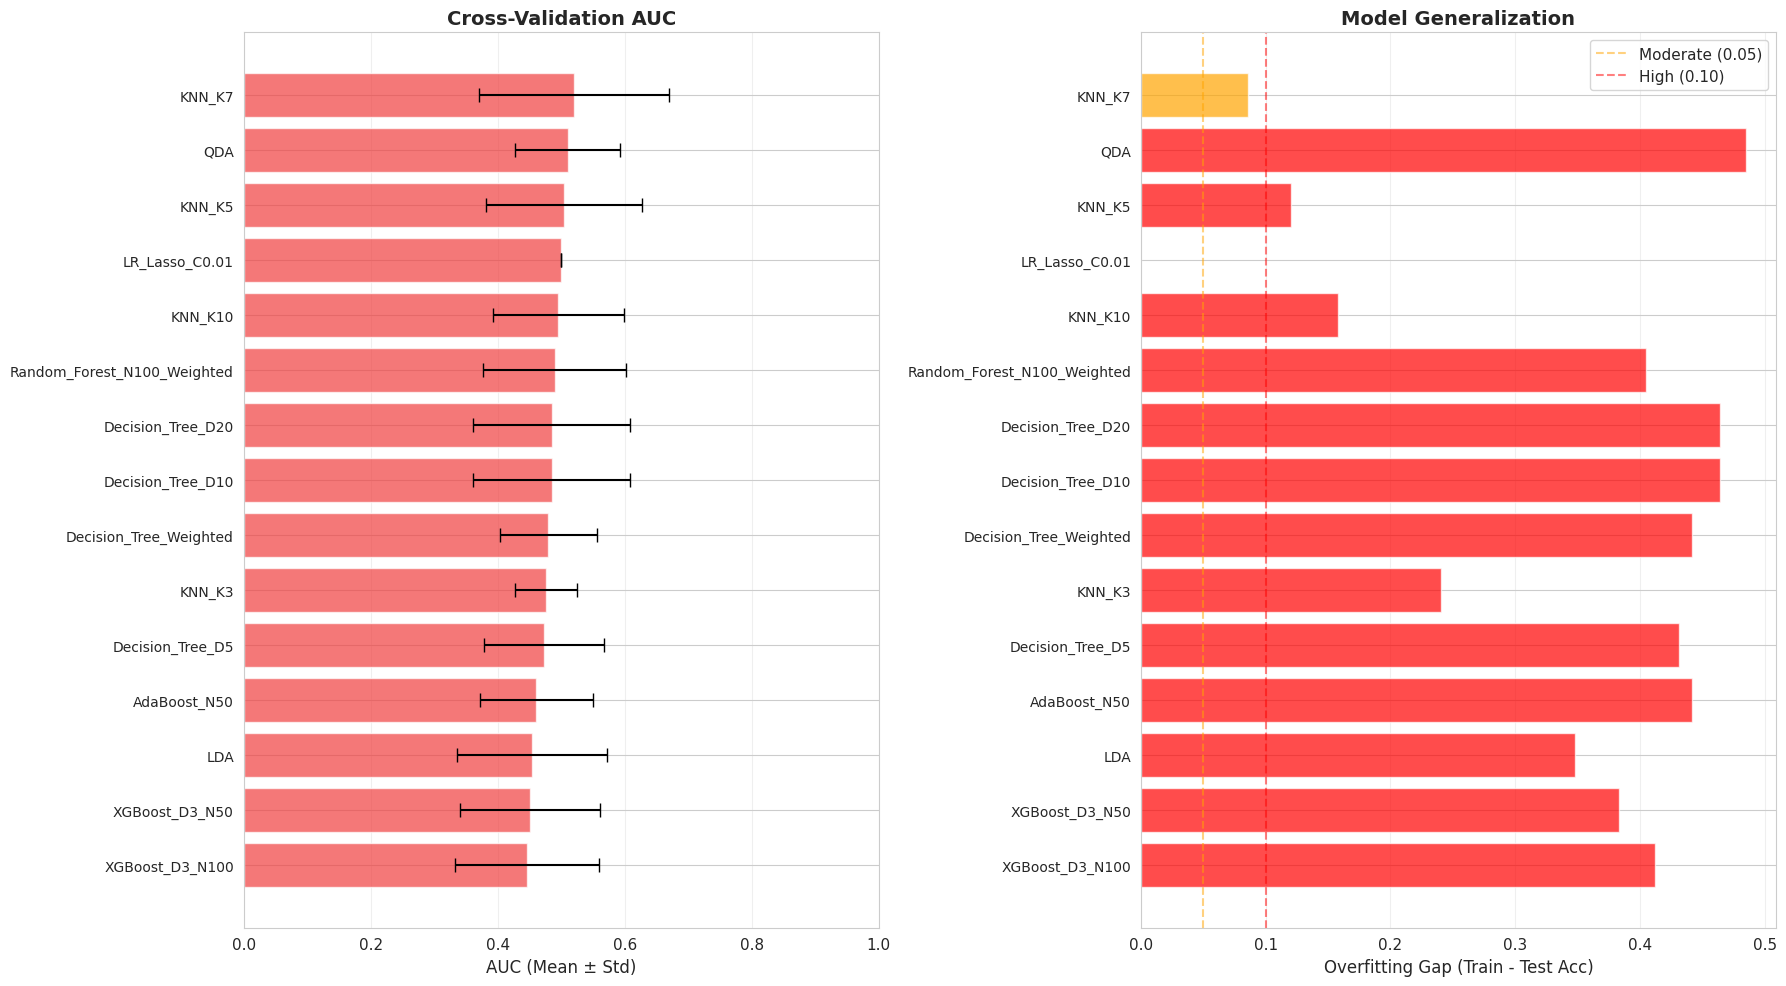

In [ ]:
def plot_cv_with_errors_enhanced(cv_df, n=15):
    """CV performance with error bars"""
    top_n_auc = cv_df.sort_values('test_auc_mean', ascending=False).head(n).copy()
    top_n_auc = top_n_auc.iloc[::-1]
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # AUC
    axes[0].barh(range(len(top_n_auc)), top_n_auc['test_auc_mean'],
                xerr=top_n_auc['test_auc_std'], capsize=5, 
                color='#f03f3f', alpha=0.7, ecolor='black')
    axes[0].set_yticks(range(len(top_n_auc)))
    axes[0].set_yticklabels(top_n_auc['model'], fontsize=10)
    axes[0].set_xlabel('AUC (Mean ± Std)', fontsize=12)
    axes[0].set_title('Cross-Validation AUC', fontsize=14, weight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Overfitting Gap
    colors_gap = ['green' if gap < 0.05 else 'orange' if gap < 0.1 else 'red' 
                  for gap in top_n_auc['overfitting_gap']]
    axes[1].barh(range(len(top_n_auc)), top_n_auc['overfitting_gap'],
                color=colors_gap, alpha=0.7)
    axes[1].set_yticks(range(len(top_n_auc)))
    axes[1].set_yticklabels(top_n_auc['model'], fontsize=10)
    axes[1].set_xlabel('Overfitting Gap (Train - Test Acc)', fontsize=12)
    axes[1].set_title('Model Generalization', fontsize=14, weight='bold')
    axes[1].axvline(0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.05)')
    axes[1].axvline(0.1, color='red', linestyle='--', alpha=0.5, label='High (0.10)')
    axes[1].legend()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_cv_performance_errors.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_cv_with_errors_enhanced(cv_results_df, n=15)


## Group Performance Boxplot

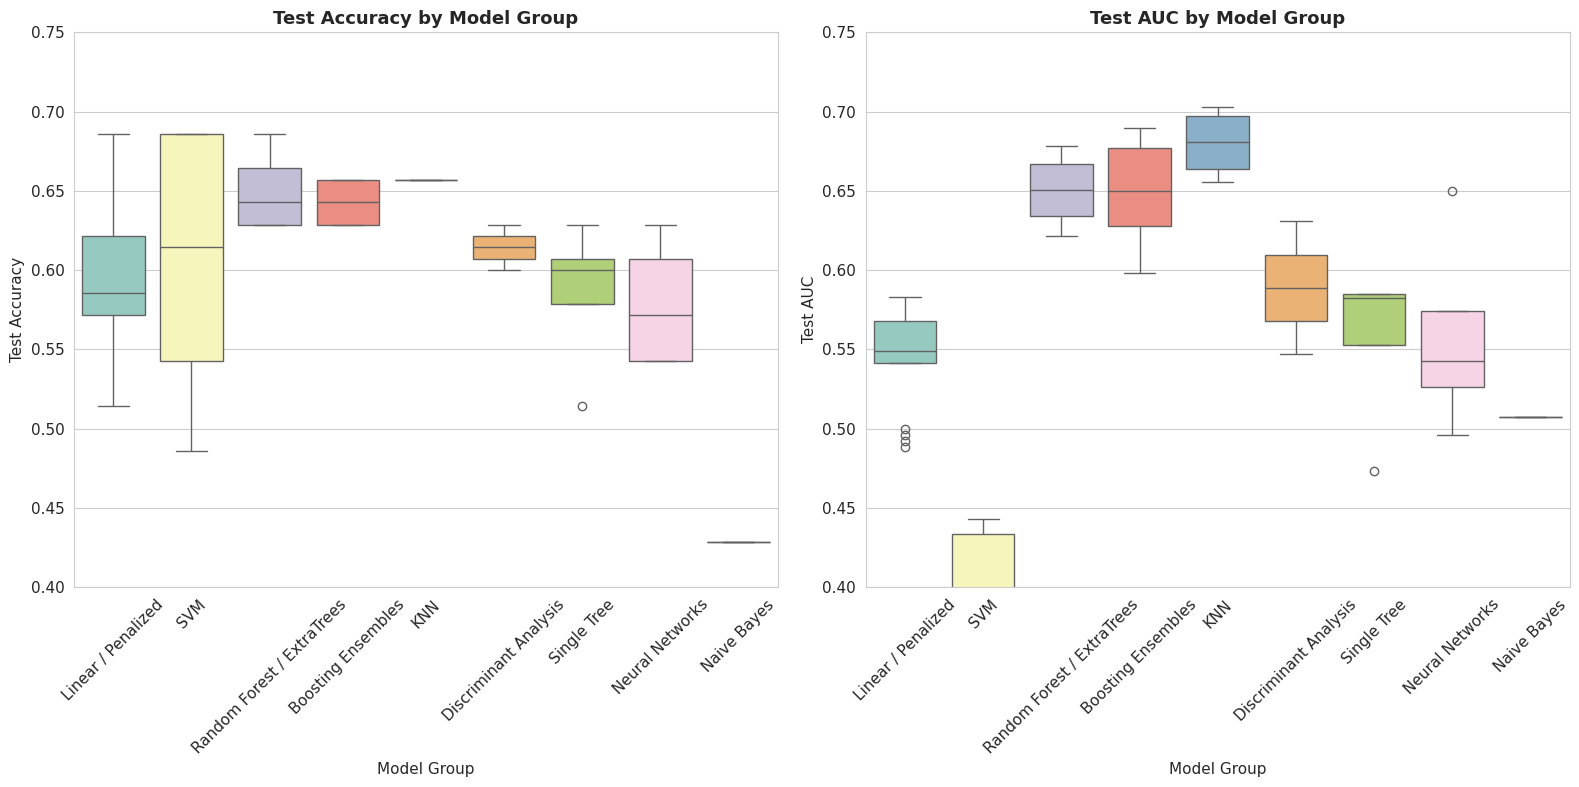

In [ ]:
def plot_grouped_performance(results_df):
    """Boxplot by model group"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Filter out SMOTE variants for clearer comparison
    df_no_smote = results_df[~results_df['model'].str.contains('SMOTE')]
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_acc', 
               palette='Set3', ax=axes[0])
    axes[0].set_xlabel('Model Group', fontsize=11)
    axes[0].set_ylabel('Test Accuracy', fontsize=11)
    axes[0].set_title('Test Accuracy by Model Group', fontsize=13, weight='bold')
    axes[0].set_ylim(0.4, 0.75)
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_auc', 
               palette='Set3', ax=axes[1])
    axes[1].set_xlabel('Model Group', fontsize=11)
    axes[1].set_ylabel('Test AUC', fontsize=11)
    axes[1].set_title('Test AUC by Model Group', fontsize=13, weight='bold')
    axes[1].set_ylim(0.4, 0.75)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('fig_group_performance_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_grouped_performance(results_combined_df)


## Train vs Test Accuracy Scatter


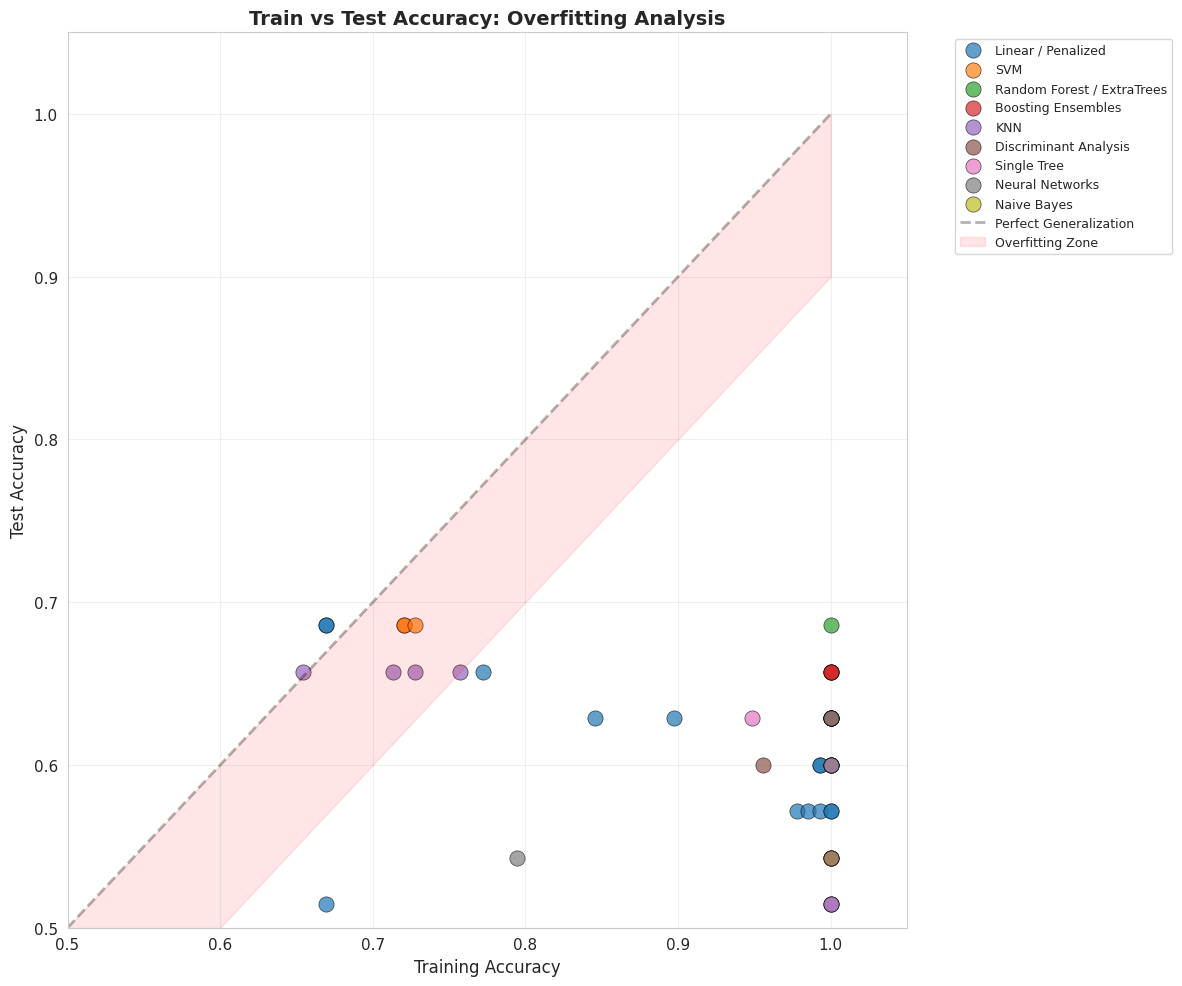


OVERFITTING ANALYSIS

Top 5 worst overfitters:
                 model  train_acc  test_acc  overfitting_gap
           SVM_RBF_C10        1.0  0.485714         0.514286
Decision_Tree_Weighted        1.0  0.514286         0.485714
      Ridge_Classifier        1.0  0.514286         0.485714
         LR_Ridge_C100        1.0  0.514286         0.485714
          LR_Ridge_C10        1.0  0.542857         0.457143

Top 5 best generalizers:
         model  train_acc  test_acc  overfitting_gap
LR_Lasso_C0.01   0.669118  0.685714        -0.016597
 LR_Lasso_C0.1   0.669118  0.685714        -0.016597
       KNN_K10   0.654412  0.657143        -0.002731
   SVM_Poly_D2   0.720588  0.685714         0.034874
   SVM_Poly_D3   0.720588  0.685714         0.034874


In [ ]:
def plot_train_test_scatter_enhanced(results_df):
    """Enhanced train vs test scatter with overfitting zones"""
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color by group
    groups = df_plot['Group'].unique()
    palette = sns.color_palette('tab10', n_colors=len(groups))
    color_map = dict(zip(groups, palette))
    
    for group in groups:
        group_data = df_plot[df_plot['Group'] == group]
        ax.scatter(group_data['train_acc'], group_data['test_acc'],
                  label=group, s=120, alpha=0.7, 
                  color=color_map[group], edgecolors='black', linewidth=0.5)
    
    # Reference lines
    ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.3, linewidth=2, 
            label='Perfect Generalization')
    
    # Overfitting zones
    ax.fill_between([0.5, 1], [0.4, 0.9], [0.5, 1], 
                    alpha=0.1, color='red', label='Overfitting Zone')
    
    ax.set_xlabel('Training Accuracy', fontsize=12)
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Train vs Test Accuracy: Overfitting Analysis', 
                fontsize=14, weight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.set_xlim(0.5, 1.05)
    ax.set_ylim(0.5, 1.05)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_train_test_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print overfitting summary
    df_plot['overfitting_gap'] = df_plot['train_acc'] - df_plot['test_acc']
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS")
    print("="*80)
    print("\nTop 5 worst overfitters:")
    print(df_plot.nlargest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ].to_string(index=False))
    
    print("\nTop 5 best generalizers:")
    print(df_plot.nsmallest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ].to_string(index=False))

plot_train_test_scatter_enhanced(results_combined_df)


## Deceptively High-Performing Models Analysis

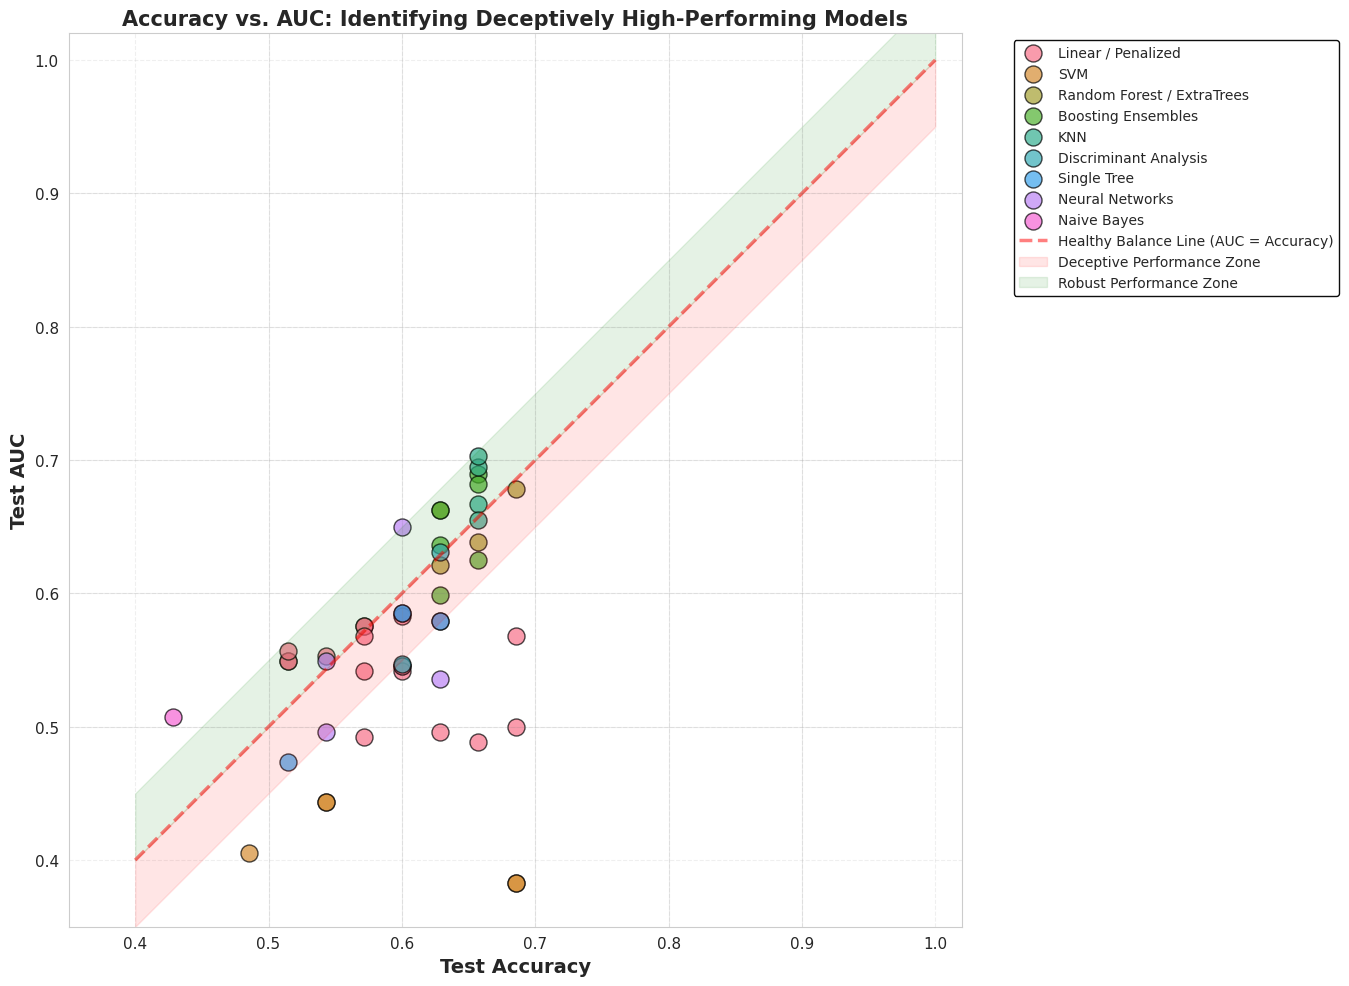


DECEPTIVELY HIGH-PERFORMING MODELS ANALYSIS

Models with High Accuracy but Low AUC (Accuracy - AUC > 0.02):
These models may be benefiting from class imbalance or other biases

                    model  test_acc  test_auc      gap                 Group
              SVM_Poly_D3  0.685714  0.333333 0.352381                   SVM
               SVM_RBF_C1  0.685714  0.382576 0.303139                   SVM
              SVM_Poly_D2  0.685714  0.382576 0.303139                   SVM
           LR_Lasso_C0.01  0.685714  0.500000 0.185714    Linear / Penalized
LR_ElasticNet_L1_0.5_C0.1  0.657143  0.488636 0.168506    Linear / Penalized
LR_ElasticNet_L1_0.3_C0.1  0.628571  0.496212 0.132359    Linear / Penalized
            LR_Lasso_C0.1  0.685714  0.568182 0.117532    Linear / Penalized
               SVM_Linear  0.542857  0.443182 0.099675                   SVM
      SVM_Linear_Weighted  0.542857  0.443182 0.099675                   SVM
                NN_Medium  0.628571  0.535985 0.0925

In [ ]:
def plot_accuracy_vs_auc_threshold(results_df):
    """
    Scatter plot: Accuracy vs AUC with diagonal threshold line
    Models below the diagonal are "deceptively high-performing"
    (High accuracy but low AUC - likely due to class imbalance issues)
    """
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Color by group
    groups = df_plot['Group'].unique()
    palette = sns.color_palette('husl', n_colors=len(groups))
    color_map = dict(zip(groups, palette))
    
    # Plot each group
    for group in groups:
        group_data = df_plot[df_plot['Group'] == group]
        ax.scatter(group_data['test_acc'], group_data['test_auc'],
                  label=group, s=150, alpha=0.7, 
                  color=color_map[group], edgecolors='black', linewidth=1)
    
    # Diagonal threshold line (y = x)
    # Models above this line have AUC >= Accuracy (healthy balance)
    # Models below have AUC < Accuracy (deceptively high accuracy)
    ax.plot([0.4, 1.0], [0.4, 1.0], 'r--', alpha=0.5, linewidth=2.5,
            label='Healthy Balance Line (AUC = Accuracy)')
    
    # Deceptive zone (below the line)
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.35, 0.95],
                    alpha=0.1, color='red', label='Deceptive Performance Zone')
    
    # Optimal zone (above the line)
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.45, 1.05],
                    alpha=0.1, color='green', label='Robust Performance Zone')
    
    ax.set_xlabel('Test Accuracy', fontsize=14, weight='bold')
    ax.set_ylabel('Test AUC', fontsize=14, weight='bold')
    ax.set_title('Accuracy vs. AUC: Identifying Deceptively High-Performing Models',
                fontsize=15, weight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, 
             framealpha=0.95, edgecolor='black')
    ax.set_xlim(0.35, 1.02)
    ax.set_ylim(0.35, 1.02)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add reference lines at 0.5 increments
    for val in [0.5, 0.6, 0.7, 0.8, 0.9]:
        ax.axhline(val, color='gray', alpha=0.15, linewidth=0.8)
        ax.axvline(val, color='gray', alpha=0.15, linewidth=0.8)
    
    # Make it square aspect
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig('fig_accuracy_vs_auc_threshold.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analysis of deceptive models
    df_plot['gap'] = df_plot['test_acc'] - df_plot['test_auc']
    deceptive = df_plot[df_plot['gap'] > 0.02].sort_values('gap', ascending=False)
    
    print("\n" + "="*80)
    print("DECEPTIVELY HIGH-PERFORMING MODELS ANALYSIS")
    print("="*80)
    print("\nModels with High Accuracy but Low AUC (Accuracy - AUC > 0.02):")
    print("These models may be benefiting from class imbalance or other biases\n")
    
    if len(deceptive) > 0:
        print(deceptive[['model', 'test_acc', 'test_auc', 'gap', 'Group']].to_string(index=False))
        print(f"\nTotal deceptive models: {len(deceptive)}/{len(df_plot)}")
        print(f"Average gap for deceptive models: {deceptive['gap'].mean():.4f}")
    else:
        print("No deceptive models found (all models have AUC ≥ Accuracy - 0.02)")
    
    # Robust models
    robust = df_plot[df_plot['gap'] <= 0.02].sort_values('test_auc', ascending=False)
    print("\n" + "="*80)
    print("ROBUST MODELS (AUC ≥ Accuracy - 0.02):")
    print("="*80)
    print(f"Count: {len(robust)}/{len(df_plot)} models\n")
    print(robust[['model', 'test_acc', 'test_auc', 'gap', 'Group']].head(10).to_string(index=False))
    
    return deceptive, robust

deceptive_models, robust_models = plot_accuracy_vs_auc_threshold(results_combined_df)


Compare LR_Lasso_C0.1 (high accuracy, low AUC) vs. KNN_K5 (balanced metrics):

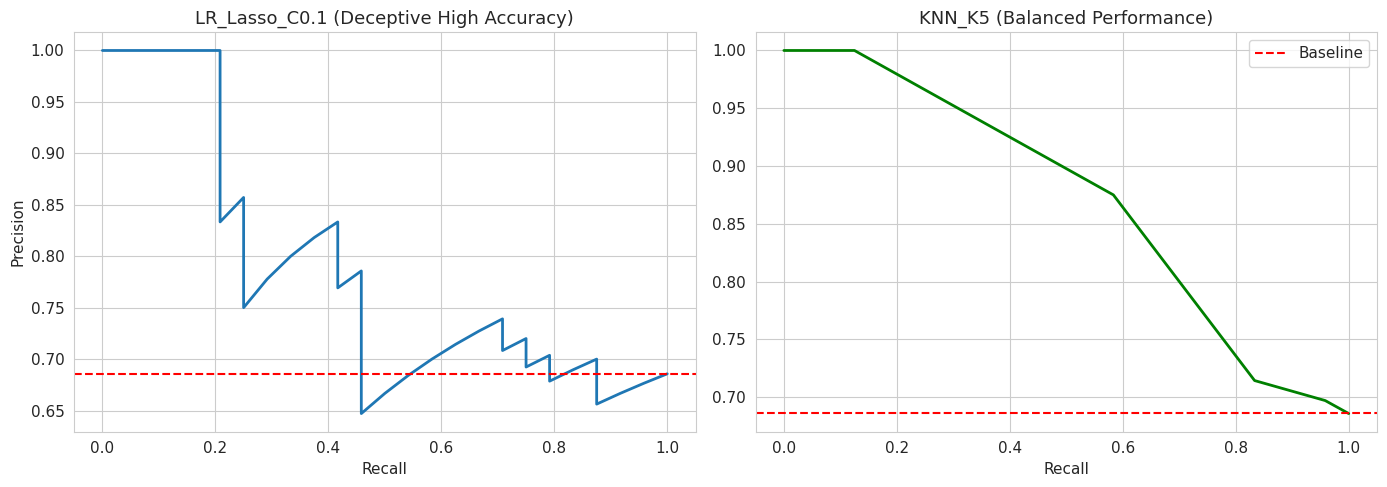

In [ ]:
# Add this analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model 1: LR_Lasso_C0.1
model1 = models['LR_Lasso_C0.1']
model1.fit(X_train_scaled, y_train)
y_proba1 = model1.predict_proba(X_test_scaled)[:, 1]
precision1, recall1, _ = precision_recall_curve(y_test, y_proba1)

axes[0].plot(recall1, precision1, linewidth=2)
axes[0].set_title('LR_Lasso_C0.1 (Deceptive High Accuracy)', fontsize=13)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].axhline(y=0.686, color='red', linestyle='--', label='Baseline (prevalence)')

# Model 2: KNN_K5
model2 = models['KNN_K5']
model2.fit(X_train_scaled, y_train)
y_proba2 = model2.predict_proba(X_test_scaled)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, y_proba2)

axes[1].plot(recall2, precision2, linewidth=2, color='green')
axes[1].set_title('KNN_K5 (Balanced Performance)', fontsize=13)
axes[1].set_xlabel('Recall')
axes[1].axhline(y=0.686, color='red', linestyle='--', label='Baseline')
axes[1].legend()

plt.tight_layout()
plt.savefig('precision_recall_comparison_deceptive_vs_balanced.png', dpi=300)
plt.show()


Demonstrate that small sample size (n=136) is the fundamental bottleneck

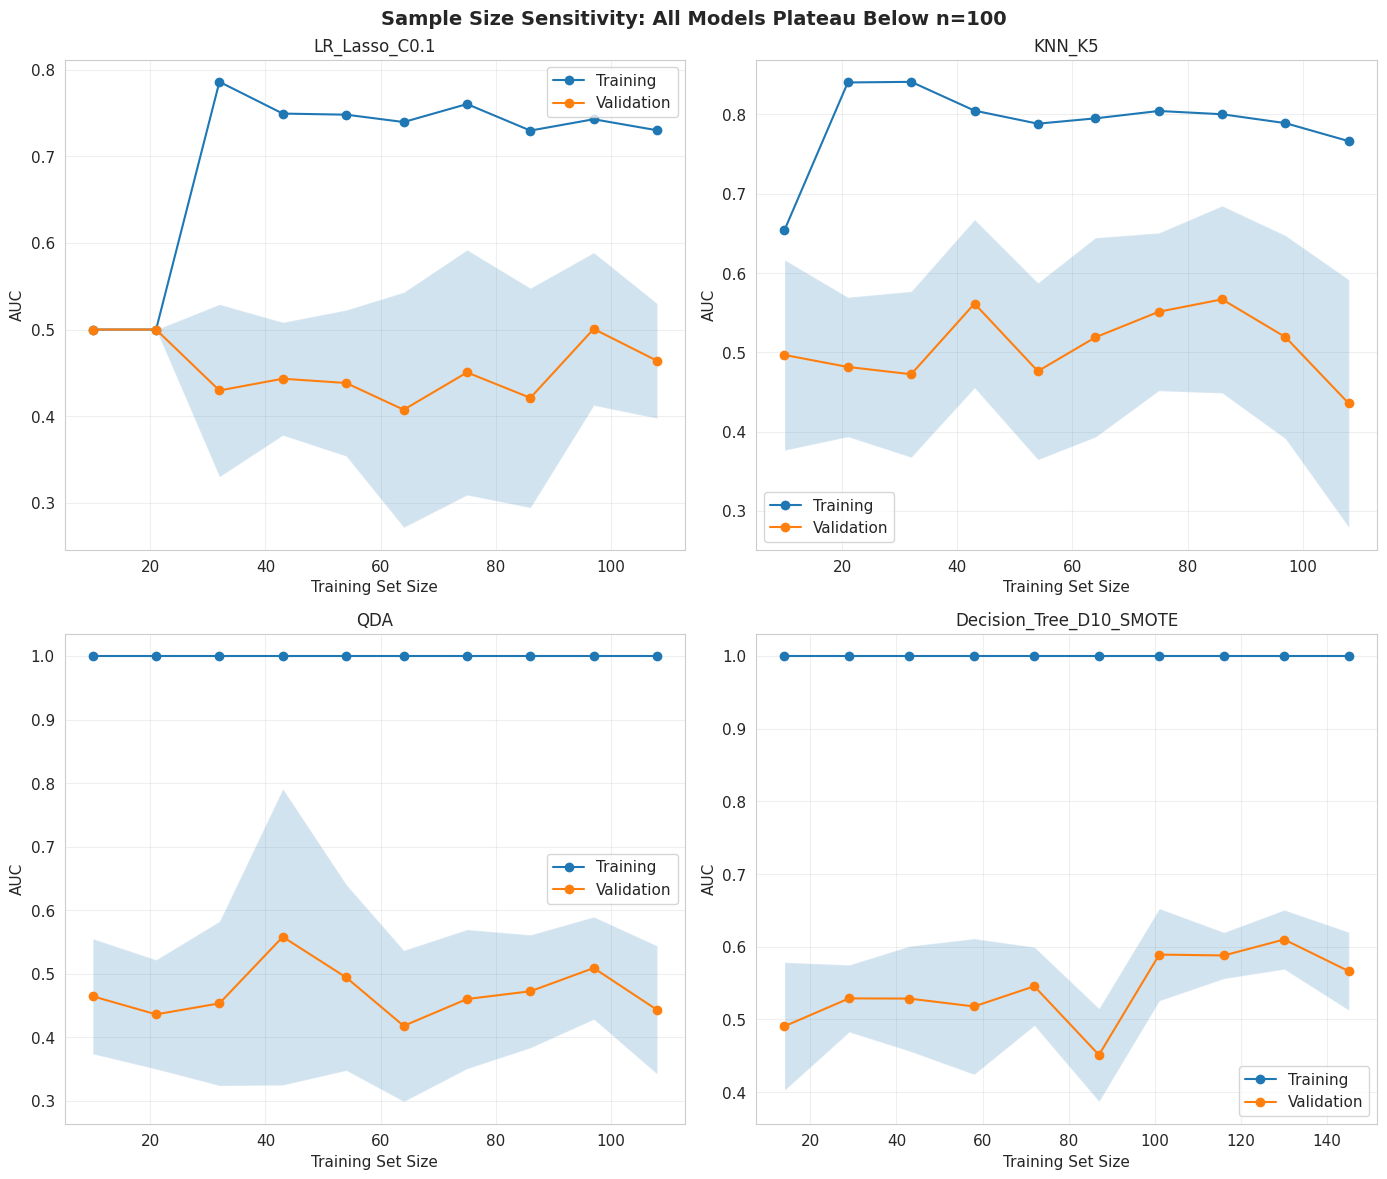

In [ ]:
# Show how all models plateau early
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
models_to_test = {
    'LR_Lasso_C0.1': models['LR_Lasso_C0.1'],
    'KNN_K5': models['KNN_K5'],
    'QDA': models['QDA'],
    'Decision_Tree_D10_SMOTE': models['Decision_Tree_D10']
}

for idx, (name, model) in enumerate(models_to_test.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Use SMOTE data for decision tree
    X_use = X_train_smote if 'SMOTE' in name else X_train_scaled
    y_use = y_train_smote if 'SMOTE' in name else y_train
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_use, y_use, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), 
        scoring='roc_auc', random_state=42
    )
    
    ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training')
    ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
    ax.fill_between(train_sizes, 
                     val_scores.mean(axis=1) - val_scores.std(axis=1),
                     val_scores.mean(axis=1) + val_scores.std(axis=1), 
                     alpha=0.2)
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('AUC')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Sample Size Sensitivity: All Models Plateau Below n=100', 
             fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig('learning_curves_sample_size_bottleneck.png', dpi=300)
plt.show()


## Feature Consistency Across Models


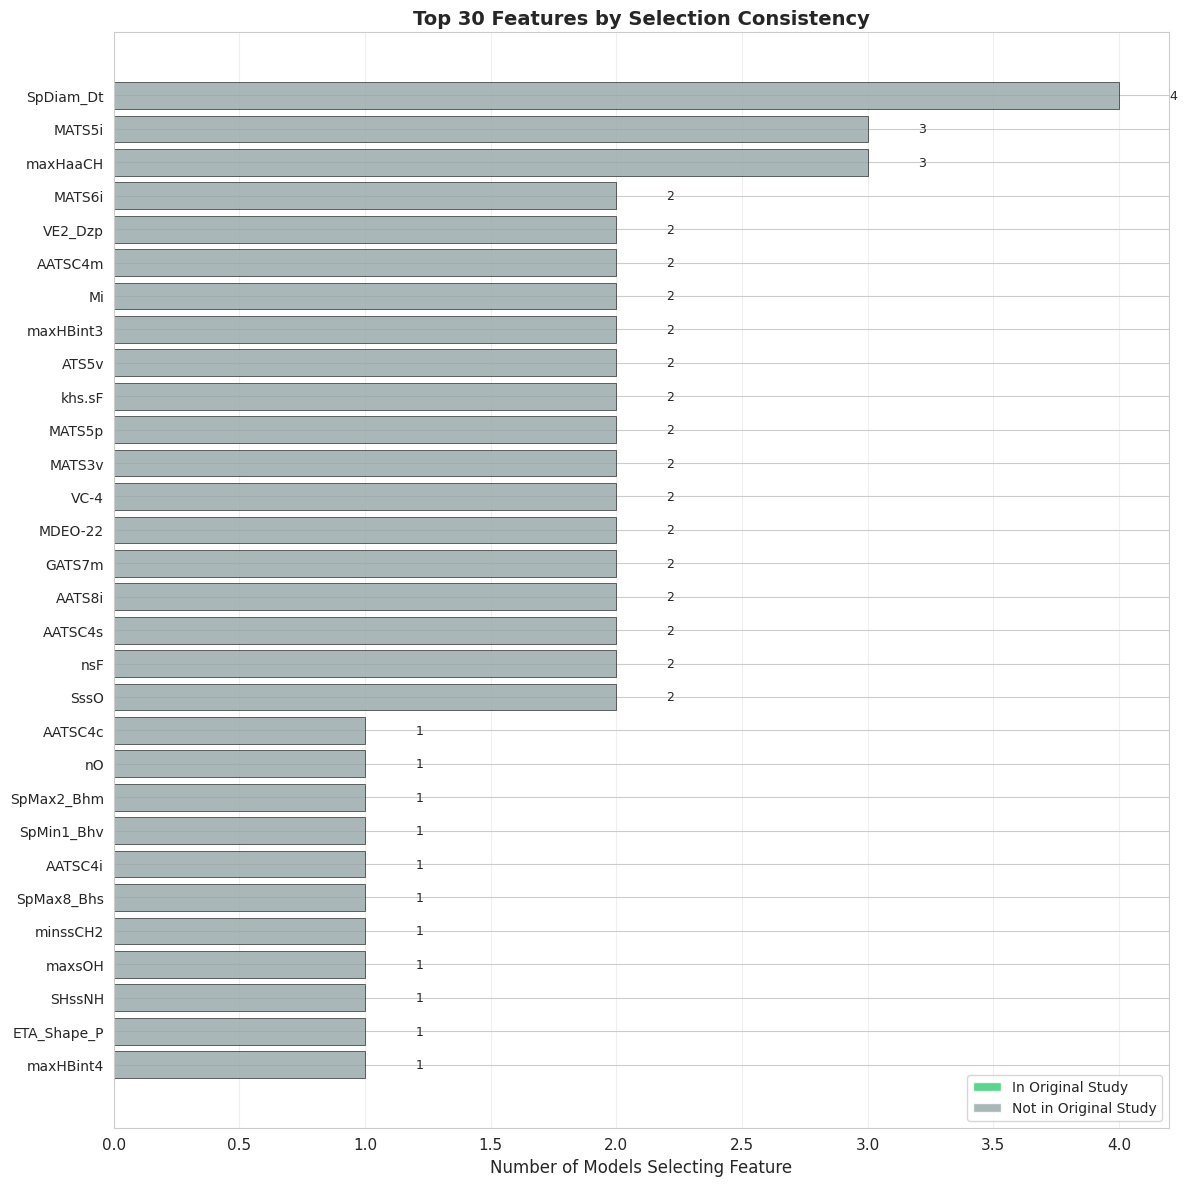


FEATURE SELECTION SUMMARY
Total models analyzed: 10

Most consistent features (selected by ≥50% of models):
  None (no feature selected by ≥50% of models)


In [ ]:
def plot_feature_consistency_enhanced(feature_comparison, original_features, top_n=30):
    """Enhanced feature consistency plot"""
    all_top_features = []
    for comp in feature_comparison.values():
        all_top_features.extend(comp['top_13'])
    
    feat_counts = pd.Series(all_top_features).value_counts().head(top_n)
    feat_df = feat_counts.reset_index()
    feat_df.columns = ['Feature', 'Frequency']
    feat_df['In_Original_Study'] = feat_df['Feature'].apply(
        lambda x: 'Yes' if x in original_features else 'No'
    )
    feat_df = feat_df.sort_values('Frequency', ascending=True)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    colors = ['#2ecc71' if x == 'Yes' else '#95a5a6' 
             for x in feat_df['In_Original_Study']]
    
    ax.barh(range(len(feat_df)), feat_df['Frequency'], 
           color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(feat_df)))
    ax.set_yticklabels(feat_df['Feature'], fontsize=10)
    ax.set_xlabel('Number of Models Selecting Feature', fontsize=12)
    ax.set_title(f'Top {top_n} Features by Selection Consistency', 
                fontsize=14, weight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (_, row) in enumerate(feat_df.iterrows()):
        ax.text(row['Frequency'] + 0.2, i, f"{int(row['Frequency'])}", 
               va='center', fontsize=9)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', alpha=0.8, label='In Original Study'),
        Patch(facecolor='#95a5a6', alpha=0.8, label='Not in Original Study')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fig_feature_consistency.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    total_models = len(feature_comparison)
    print(f"\n{'='*80}")
    print("FEATURE SELECTION SUMMARY")
    print("="*80)
    print(f"Total models analyzed: {total_models}")
    print(f"\nMost consistent features (selected by ≥50% of models):")
    highly_consistent = feat_df[feat_df['Frequency'] >= total_models * 0.5]
    if len(highly_consistent) > 0:
        for _, row in highly_consistent.iterrows():
            in_orig = "✓" if row['In_Original_Study'] == 'Yes' else " "
            print(f"  [{in_orig}] {row['Feature']}: {int(row['Frequency'])}/{total_models} models")
    else:
        print("  None (no feature selected by ≥50% of models)")

plot_feature_consistency_enhanced(feature_comparison, original_features, top_n=30)


In [ ]:
# Bootstrap stability analysis
from collections import Counter

def bootstrap_feature_stability(model, X, y, n_bootstrap=50, n_features=13):
    """Measure feature selection stability across bootstrap samples"""
    feature_selections = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(len(X), len(X), replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
        # Fit model
        model.fit(X_boot, y_boot)
        
        # Get top features
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue
            
        top_idx = np.argsort(importances)[-n_features:]
        top_features = [feature_names[i] for i in top_idx]
        feature_selections.extend(top_features)
    
    # Calculate stability (Jaccard index)
    feature_freq = Counter(feature_selections)
    total_selections = n_bootstrap * n_features
    
    # Features selected in >50% of bootstraps are "stable"
    stable_features = {f: count for f, count in feature_freq.items() 
                      if count >= n_bootstrap * 0.5}
    
    return feature_freq, stable_features

# Test on Lasso
freq, stable = bootstrap_feature_stability(
    models['LR_Lasso_C0.1'], X_train_scaled, y_train, 
    n_bootstrap=50, n_features=13
)

print(f"\nFeature Selection Stability Analysis (50 bootstrap iterations):")
print(f"Total unique features selected: {len(freq)}")
print(f"Stable features (selected in >50% of bootstraps): {len(stable)}")
print(f"\nTop 10 most stable features:")
for feat, count in sorted(freq.items(), key=lambda x: x[1], reverse=True)[:10]:
    stability_pct = (count / 50) * 100
    print(f"  {feat}: {stability_pct:.1f}% selection rate")



Feature Selection Stability Analysis (50 bootstrap iterations):
Total unique features selected: 279
Stable features (selected in >50% of bootstraps): 0

Top 10 most stable features:
  topoShape: 32.0% selection rate
  nHBint3: 28.0% selection rate
  EE_Dt: 24.0% selection rate
  AATSC7p: 24.0% selection rate
  SwHBa: 22.0% selection rate
  nTG12HeteroRing: 20.0% selection rate
  nFG12HeteroRing: 20.0% selection rate
  ATSC3e: 20.0% selection rate
  AATSC8i: 18.0% selection rate
  minHBint4: 18.0% selection rate


## ROC Curves for Top Models

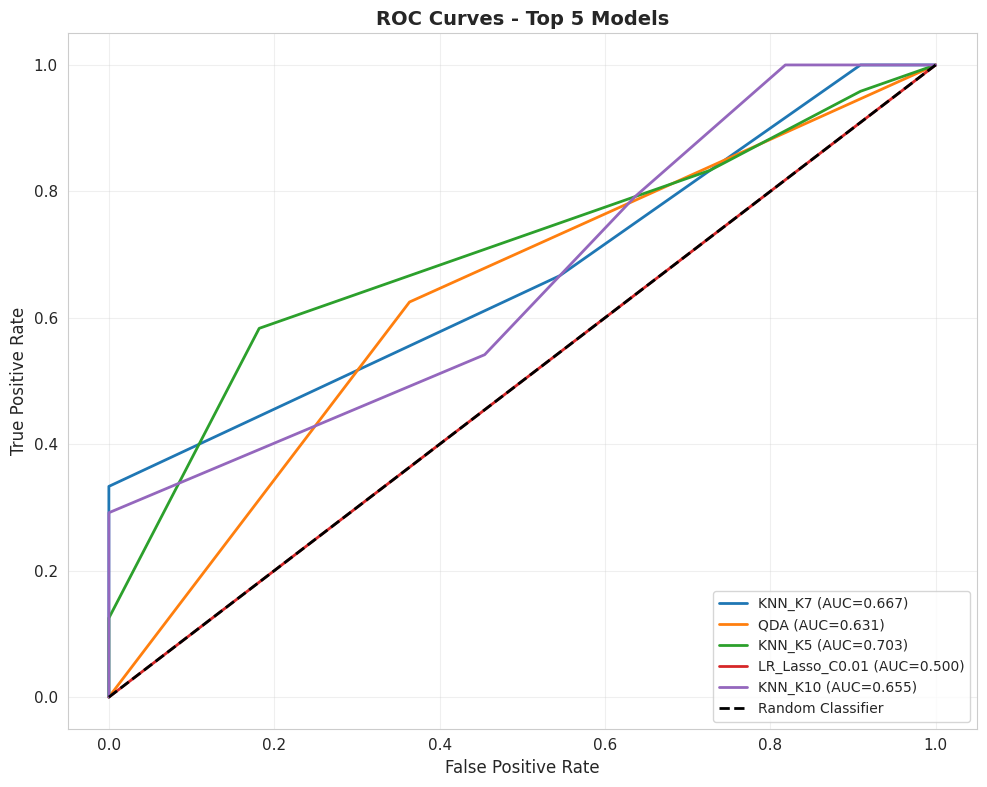

In [ ]:
def plot_roc_curves_top_models(models_dict, model_names, X_train, X_test, 
                               y_train, y_test, n_models=5):
    """Plot ROC curves for top performing models"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for name in model_names[:n_models]:
        model = models_dict[name]
        model.fit(X_train, y_train)
        
        if hasattr(model, 'predict_proba'):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, linewidth=2, 
               label=f'{name} (AUC={roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curves - Top 5 Models', fontsize=14, weight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

top_5_models = cv_results_df.head(5)['model'].tolist()
plot_roc_curves_top_models(models, top_5_models, 
                           X_train_scaled, X_test_scaled, y_train, y_test)


In [ ]:
def plot_roc_pr_curves_comprehensive(models_dict, X_test, y_test, top_n=10):
    """
    ROC and PR curves for top models
    Essential for thesis visualizations
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    # Get top models by CV AUC
    top_models = cv_results_df.head(top_n)['model'].tolist()
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # ROC Curves
    for model_name in top_models:
        model = models_dict[model_name]
        model.fit(X_train_scaled, y_train)
        
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        
        axes[0].plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc_score:.3f})', alpha=0.8)
    
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title('ROC Curves (Top 10 Models)', fontsize=13, weight='bold')
    axes[0].legend(loc='lower right', fontsize=8)
    axes[0].grid(alpha=0.3)
    
    # Precision-Recall Curves
    baseline_prevalence = y_test.mean()
    
    for model_name in top_models:
        model = models_dict[model_name]
        
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test)
        else:
            continue
        
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap_score = average_precision_score(y_test, y_proba)
        
        axes[1].plot(recall, precision, linewidth=2, label=f'{model_name} (AP={ap_score:.3f})', alpha=0.8)
    
    axes[1].axhline(baseline_prevalence, color='k', linestyle='--', linewidth=2, 
                   label=f'Baseline (Prevalence={baseline_prevalence:.3f})')
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title('Precision-Recall Curves (Top 10 Models)', fontsize=13, weight='bold')
    axes[1].legend(loc='lower left', fontsize=8)
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('fig_roc_pr_curves_top10.png', dpi=300, bbox_inches='tight')
    plt.show()

# Execute
plot_roc_pr_curves_comprehensive(models, X_test_scaled, y_test, top_n=10)


## Precision-Recall Curves


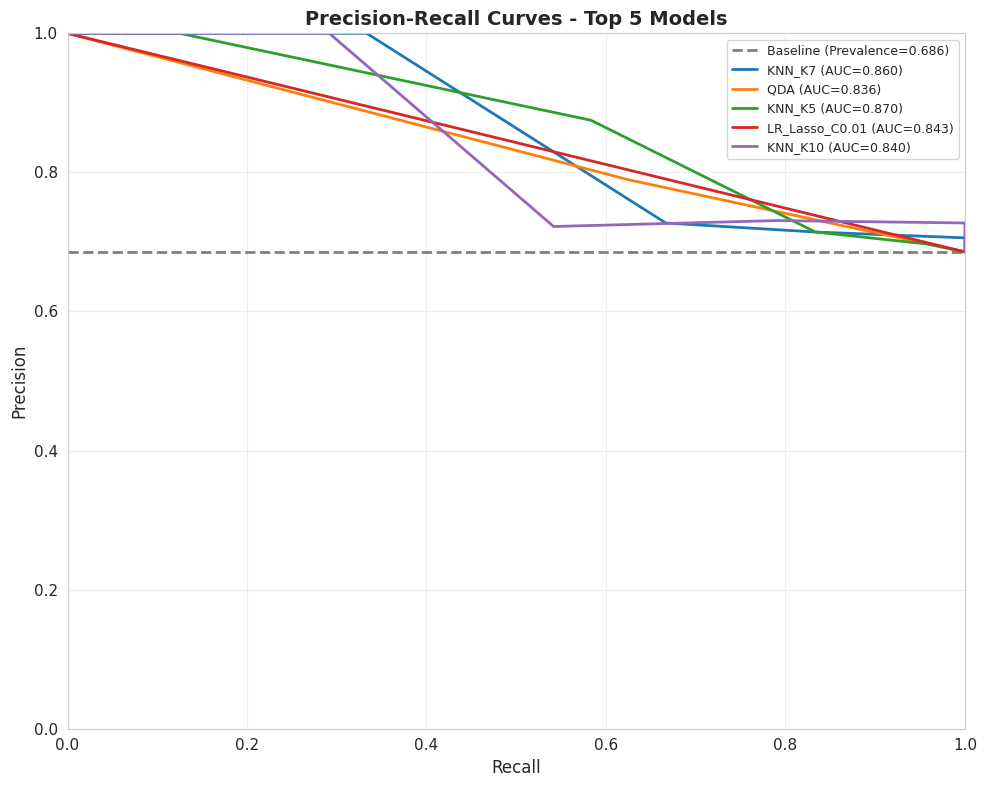

In [ ]:
def plot_precision_recall_curves_enhanced(models_dict, model_names, X_train, X_test, 
                                         y_train, y_test, n_models=5):
    """Enhanced PR curves with baseline"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Baseline (proportion of positive class)
    baseline = y_test.sum() / len(y_test)
    ax.axhline(baseline, color='gray', linestyle='--', linewidth=2,
              label=f'Baseline (Prevalence={baseline:.3f})')
    
    for name in model_names[:n_models]:
        model = models_dict[name]
        model.fit(X_train, y_train)
        
        if hasattr(model, 'predict_proba'):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)
        
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall, precision)
        
        ax.plot(recall, precision, linewidth=2,
               label=f'{name} (AUC={pr_auc:.3f})')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curves - Top 5 Models', 
                fontsize=14, weight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('fig_precision_recall_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_precision_recall_curves_enhanced(models, top_5_models,
                                     X_train_scaled, X_test_scaled, 
                                     y_train, y_test)


## Learning Curves


In [ ]:
def learning_curve_analysis(X, y, model, sample_sizes, n_repeats=10, cv=5, random_state=42):
    """
    Comprehensive learning curve analysis across multiple sample sizes
    
    Parameters:
    -----------
    X : array-like
        Feature matrix
    y : array-like
        Target vector
    model : estimator
        Sklearn model to evaluate
    sample_sizes : list
        List of sample sizes to test
    n_repeats : int
        Number of repetitions for each sample size
    cv : int
        Cross-validation folds
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    pd.DataFrame with columns: Sample_Size, Train_AUC, Test_AUC, MCC, F1, PR_AUC, etc.
    """
    np.random.seed(random_state)
    results = []
    
    for sample_size in sample_sizes:
        train_aucs = []
        test_aucs = []
        mccs = []
        f1s = []
        pr_aucs = []
        accs = []
        
        for repeat in range(n_repeats):
            # Stratified sampling
            skf = StratifiedKFold(n_splits=cv, shuffle=True, 
                                 random_state=random_state + repeat)
            
            fold_train_auc = []
            fold_test_auc = []
            fold_mcc = []
            fold_f1 = []
            fold_pr_auc = []
            fold_acc = []
            
            for train_idx, test_idx in skf.split(X, y):
                # Subsample training set
                if len(train_idx) > sample_size:
                    subsample_idx = np.random.choice(train_idx, sample_size, replace=False)
                else:
                    subsample_idx = train_idx
                
                X_train_sub = X[subsample_idx]
                y_train_sub = y[subsample_idx] if isinstance(y, np.ndarray) else y.iloc[subsample_idx]
                
                X_test_fold = X[test_idx]
                y_test_fold = y[test_idx] if isinstance(y, np.ndarray) else y.iloc[test_idx]
                
                # Fit model
                from sklearn.base import clone
                model_clone = clone(model)
                model_clone.fit(X_train_sub, y_train_sub)
                
                # Predictions
                y_train_pred = model_clone.predict(X_train_sub)
                y_test_pred = model_clone.predict(X_test_fold)
                
                # Probabilities
                if hasattr(model_clone, 'predict_proba'):
                    y_train_proba = model_clone.predict_proba(X_train_sub)[:, 1]
                    y_test_proba = model_clone.predict_proba(X_test_fold)[:, 1]
                elif hasattr(model_clone, 'decision_function'):
                    y_train_proba = model_clone.decision_function(X_train_sub)
                    y_test_proba = model_clone.decision_function(X_test_fold)
                else:
                    y_train_proba = y_train_pred
                    y_test_proba = y_test_pred
                
                # Metrics
                fold_train_auc.append(roc_auc_score(y_train_sub, y_train_proba))
                fold_test_auc.append(roc_auc_score(y_test_fold, y_test_proba))
                fold_mcc.append(matthews_corrcoef(y_test_fold, y_test_pred))
                fold_f1.append(f1_score(y_test_fold, y_test_pred, zero_division=0))
                fold_pr_auc.append(average_precision_score(y_test_fold, y_test_proba))
                fold_acc.append(accuracy_score(y_test_fold, y_test_pred))
            
            # Average across folds
            train_aucs.append(np.mean(fold_train_auc))
            test_aucs.append(np.mean(fold_test_auc))
            mccs.append(np.mean(fold_mcc))
            f1s.append(np.mean(fold_f1))
            pr_aucs.append(np.mean(fold_pr_auc))
            accs.append(np.mean(fold_acc))
        
        # Statistics across repeats
        results.append({
            'Sample_Size': sample_size,
            'Train_AUC_mean': np.mean(train_aucs),
            'Train_AUC_std': np.std(train_aucs),
            'Test_AUC_mean': np.mean(test_aucs),
            'Test_AUC_std': np.std(test_aucs),
            'MCC_mean': np.mean(mccs),
            'MCC_std': np.std(mccs),
            'F1_mean': np.mean(f1s),
            'F1_std': np.std(f1s),
            'PR_AUC_mean': np.mean(pr_aucs),
            'PR_AUC_std': np.std(pr_aucs),
            'Acc_mean': np.mean(accs),
            'Acc_std': np.std(accs),
        })
    
    return pd.DataFrame(results)



In [ ]:

# Execute learning curve analysis for key models
print("\n" + "="*80)
print("LEARNING CURVE ANALYSIS - VARIABLE SAMPLE SIZES")
print("="*80)

sample_sizes = [20, 40, 60, 80, 100, 120, 136]

# Model 1: ElasticNet
print("\n>>> ElasticNet Model (penalty='elasticnet', C=1.0, l1_ratio=0.5)")
elastic_model = LogisticRegression(penalty='elasticnet', C=1.0, l1_ratio=0.5, 
                                   solver='saga', max_iter=10000, random_state=42)

elastic_lc = learning_curve_analysis(X_train_scaled, y_train, elastic_model, 
                                     sample_sizes, n_repeats=10)
print("\nElasticNet Results:")
print(elastic_lc.to_string(index=False))

# Model 2: Lasso
print("\n>>> Lasso Model (penalty='l1', C=0.1)")
lasso_model = LogisticRegression(penalty='l1', C=0.1, solver='saga', 
                                max_iter=10000, random_state=42)

lasso_lc = learning_curve_analysis(X_train_scaled, y_train, lasso_model, 
                                   sample_sizes, n_repeats=10)
print("\nLasso Results:")
print(lasso_lc.to_string(index=False))

# Model 3: Ridge
print("\n>>> Ridge Model (penalty='l2', C=1.0)")
ridge_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', 
                                max_iter=10000, random_state=42)

ridge_lc = learning_curve_analysis(X_train_scaled, y_train, ridge_model, 
                                   sample_sizes, n_repeats=10)
print("\nRidge Results:")
print(ridge_lc.to_string(index=False))

# Model 4: KNN (for comparison)
print("\n>>> KNN Model (n_neighbors=5)")
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_lc = learning_curve_analysis(X_train_scaled, y_train, knn_model, 
                                 sample_sizes, n_repeats=10)
print("\nKNN Results:")
print(knn_lc.to_string(index=False))

In [ ]:
def fit_power_law_and_extrapolate(lc_df, metric='MCC_mean', target_values=[0.70, 0.75, 0.80]):
    """
    Fit power law model to learning curves and extrapolate
    Power Law: y = a * x^b + c
    """
    from scipy.optimize import curve_fit
    
    x_data = lc_df['Sample_Size'].values.astype(float)
    y_data = lc_df[metric].values
    
    def power_law(x, a, b, c):
        return a * np.power(x, b) + c
    
    try:
        # Initial guess
        popt, pcov = curve_fit(power_law, x_data, y_data, 
                              p0=[0.5, 0.3, 0.4], maxfev=10000)
        
        # Extrapolation points
        extrap_sizes = np.array([200, 300, 400, 500, 750, 1000])
        extrap_scores = power_law(extrap_sizes, *popt)
        
        # Inverse: find sample size needed for target score
        def inverse_power_law(y_target, a, b, c):
            if y_target <= c:
                return None
            return np.power((y_target - c) / a, 1/b)
        
        results = {
            'params': {'a': popt[0], 'b': popt[1], 'c': popt[2]},
            'extrapolated': pd.DataFrame({
                'Sample_Size': extrap_sizes,
                'Predicted_Score': extrap_scores
            }),
            'target_sample_sizes': {}
        }
        
        for target in target_values:
            n_needed = inverse_power_law(target, *popt)
            results['target_sample_sizes'][target] = n_needed
        
        return results, popt
    
    except Exception as e:
        print(f"Power law fitting failed: {str(e)}")
        return None, None



In [ ]:
# Fit power laws for all models
print("\n" + "="*80)
print("POWER LAW EXTRAPOLATION")
print("="*80)

models_to_fit = {
    'ElasticNet': elastic_lc,
    'Lasso': lasso_lc,
    'Ridge': ridge_lc,
    'KNN': knn_lc
}

power_law_results = {}

for model_name, lc_df in models_to_fit.items():
    print(f"\n>>> {model_name}")
    results, popt = fit_power_law_and_extrapolate(lc_df, metric='MCC_mean', 
                                                 target_values=[0.60, 0.65, 0.70])
    
    if results:
        power_law_results[model_name] = results
        
        print(f"Power Law: MCC = {popt[0]:.4f} * n^{popt[1]:.4f} + {popt[2]:.4f}")
        print(f"\nExtrapolated MCC:")
        print(results['extrapolated'].to_string(index=False))
        
        print(f"\nSample sizes needed for target MCC:")
        for target, n_needed in results['target_sample_sizes'].items():
            if n_needed and n_needed > 0:
                print(f"  MCC = {target:.2f}: n ≈ {n_needed:.0f}")
            else:
                print(f"  MCC = {target:.2f}: Not achievable with current trend")


# Visualization
def plot_learning_curves_with_extrapolation(lc_dfs_dict, power_law_results_dict):
    """
    Plot learning curves with power law fits and extrapolation
    """
    n_models = len(lc_dfs_dict)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    extrap_x = np.array([200, 300, 400, 500, 750, 1000])
    
    for idx, (model_name, lc_df) in enumerate(lc_dfs_dict.items()):
        ax = axes[idx]
        
        # Plot actual data
        ax.errorbar(lc_df['Sample_Size'], lc_df['MCC_mean'], 
                   yerr=lc_df['MCC_std'], fmt='o-', linewidth=2.5, 
                   markersize=8, capsize=5, label='Observed MCC',
                   color='#e74c3c', alpha=0.8)
        
        ax.errorbar(lc_df['Sample_Size'], lc_df['Test_AUC_mean'],
                   yerr=lc_df['Test_AUC_std'], fmt='s-', linewidth=2.5,
                   markersize=8, capsize=5, label='Observed AUC',
                   color='#3498db', alpha=0.8)
        
        # Extrapolation
        if model_name in power_law_results_dict:
            extrap_df = power_law_results_dict[model_name]['extrapolated']
            ax.plot(extrap_df['Sample_Size'], extrap_df['Predicted_Score'], 
                   '--o', linewidth=2, markersize=6, color='#e74c3c', 
                   alpha=0.6, label='Extrapolated (Power Law)')
        
        # Reference lines
        ax.axhline(0.70, color='green', linestyle=':', alpha=0.7, linewidth=1.5,
                  label='Target AUC=0.70')
        ax.axhline(0.80, color='orange', linestyle=':', alpha=0.7, linewidth=1.5,
                  label='Target AUC=0.80')
        ax.axvline(136, color='gray', linestyle='--', alpha=0.5, linewidth=1.5,
                  label='Current n=136')
        
        ax.set_xlabel('Training Set Size (n)', fontsize=12, weight='bold')
        ax.set_ylabel('Performance Score', fontsize=12, weight='bold')
        ax.set_title(f'{model_name} - Learning Curve with Extrapolation', 
                    fontsize=13, weight='bold')
        ax.legend(loc='lower right', fontsize=9, framealpha=0.95)
        ax.grid(alpha=0.3, linestyle='--')
        ax.set_ylim(0.3, 1.0)
        ax.set_xlim(0, 1000)
    
    plt.tight_layout()
    plt.savefig('fig_learning_curves_extrapolation.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_learning_curves_with_extrapolation(models_to_fit, power_law_results)

# Summary table
print("\n" + "="*80)
print("SAMPLE SIZE REQUIREMENTS SUMMARY")
print("="*80)

summary_data = []
for model_name, results in power_law_results.items():
    for target_auc, n_needed in results['target_sample_sizes'].items():
        if n_needed and n_needed > 0:
            summary_data.append({
                'Model': model_name,
                'Target_MCC': target_auc,
                'Estimated_n': int(n_needed)
            })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))
    summary_df.to_csv('sample_size_requirements.csv', index=False)
    print("\n✓ Saved to 'sample_size_requirements.csv'")


LEARNING CURVE FOR BEST MODEL: KNN_K7


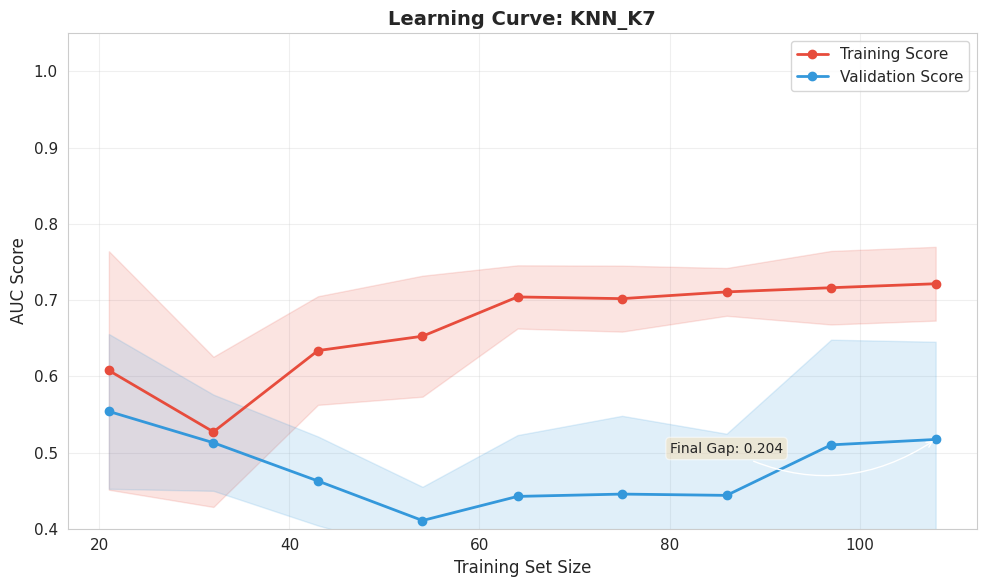


KNN_K7:
  Final training AUC: 0.7214 ± 0.0484
  Final validation AUC: 0.5171 ± 0.1282
  Overfitting gap: 0.2043


In [ ]:
def plot_learning_curve_enhanced(estimator, title, X, y, cv=5):
    """Enhanced learning curve with confidence intervals"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=train_sizes, shuffle=True,
        random_state=RANDOM_STATE, scoring='roc_auc'
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.fill_between(train_sizes_abs, 
                    train_mean - train_std, train_mean + train_std,
                    alpha=0.15, color='#e74c3c')
    ax.fill_between(train_sizes_abs,
                    val_mean - val_std, val_mean + val_std,
                    alpha=0.15, color='#3498db')
    
    ax.plot(train_sizes_abs, train_mean, 'o-', color='#e74c3c', 
           linewidth=2, markersize=6, label='Training Score')
    ax.plot(train_sizes_abs, val_mean, 'o-', color='#3498db',
           linewidth=2, markersize=6, label='Validation Score')
    
    ax.set_xlabel('Training Set Size', fontsize=12)
    ax.set_ylabel('AUC Score', fontsize=12)
    ax.set_title(f'Learning Curve: {title}', fontsize=14, weight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim(0.4, 1.05)
    
    # Add final gap annotation
    final_gap = train_mean[-1] - val_mean[-1]
    ax.annotate(f'Final Gap: {final_gap:.3f}',
               xy=(train_sizes_abs[-1], val_mean[-1]),
               xytext=(train_sizes_abs[-3], 0.5),
               fontsize=10, ha='center',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))
    
    plt.tight_layout()
    plt.savefig(f'fig_learning_curve_{title.replace(" ", "_")}.png', 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{title}:")
    print(f"  Final training AUC: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
    print(f"  Final validation AUC: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
    print(f"  Overfitting gap: {final_gap:.4f}")

# Plot for best model
best_model_name = cv_results_df.iloc[0]['model']
print(f"\n{'='*80}")
print(f"LEARNING CURVE FOR BEST MODEL: {best_model_name}")
print("="*80)
plot_learning_curve_enhanced(models[best_model_name], best_model_name,
                            X_train_scaled, y_train, cv=5)


In [ ]:
def plot_learning_curves_advanced(models_dict, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Generate learning curves to estimate sample size requirements
    Key for Objective 4: estimating n needed for AUC > 0.70
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    top_models = ['KNN_K5', 'QDA', 'LR_Lasso_C0.1', 'Decision_Tree_D10']
    
    for idx, model_name in enumerate(top_models):
        model = models_dict[model_name]
        
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model, X, y, train_sizes=train_sizes, cv=5,
            scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        axes[idx].plot(train_sizes_abs, train_mean, 'o-', color='blue', 
                      label='Training AUC', linewidth=2)
        axes[idx].fill_between(train_sizes_abs, train_mean - train_std, 
                              train_mean + train_std, alpha=0.2, color='blue')
        
        axes[idx].plot(train_sizes_abs, val_mean, 'o-', color='red', 
                      label='Validation AUC', linewidth=2)
        axes[idx].fill_between(train_sizes_abs, val_mean - val_std, 
                              val_mean + val_std, alpha=0.2, color='red')
        
        # Target performance lines
        axes[idx].axhline(0.70, color='green', linestyle='--', alpha=0.7, 
                         label='Target AUC = 0.70')
        axes[idx].axhline(0.80, color='orange', linestyle='--', alpha=0.7,
                         label='Target AUC = 0.80')
        
        # Plateau detection
        if len(val_mean) > 3:
            recent_trend = val_mean[-3:].std()
            if recent_trend < 0.02:
                plateau_size = train_sizes_abs[np.argmax(val_mean > val_mean[-1] - 0.02)]
                axes[idx].axvline(plateau_size, color='purple', linestyle=':', 
                                 label=f'Plateau at n={plateau_size}')
        
        axes[idx].set_xlabel('Training Set Size', fontsize=11)
        axes[idx].set_ylabel('AUC Score', fontsize=11)
        axes[idx].set_title(f'{model_name}', fontsize=12, weight='bold')
        axes[idx].legend(loc='lower right', fontsize=9)
        axes[idx].grid(alpha=0.3)
        axes[idx].set_ylim(0.4, 1.0)
    
    plt.tight_layout()
    plt.savefig('fig_learning_curves_sample_size.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Extrapolation analysis (simple power law fit)
    print("\n" + "="*80)
    print("SAMPLE SIZE REQUIREMENTS ESTIMATION")
    print("="*80)
    
    for model_name in top_models:
        model = models_dict[model_name]
        train_sizes_abs, _, val_scores = learning_curve(
            model, X, y, train_sizes=train_sizes, cv=5,
            scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE
        )
        val_mean = np.mean(val_scores, axis=1)
        
        # Fit power law: AUC = a - b * n^(-c)
        from scipy.optimize import curve_fit
        def power_law(n, a, b, c):
            return a - b * np.power(n, -c)
        
        try:
            params, _ = curve_fit(power_law, train_sizes_abs, val_mean, 
                                 p0=[0.75, 10, 0.5], maxfev=10000)
            
            # Estimate n for AUC = 0.70 and 0.80
            def inverse_power_law(auc_target, a, b, c):
                return np.power((a - auc_target) / b, -1/c)
            
            n_for_070 = inverse_power_law(0.70, *params)
            n_for_080 = inverse_power_law(0.80, *params)
            
            print(f"\n{model_name}:")
            print(f"  Current max AUC: {val_mean[-1]:.4f} at n={train_sizes_abs[-1]}")
            print(f"  Estimated n for AUC=0.70: {n_for_070:.0f}")
            print(f"  Estimated n for AUC=0.80: {n_for_080:.0f}")
        except:
            print(f"\n{model_name}: Extrapolation fit failed (insufficient curvature)")

# Execute
plot_learning_curves_advanced(models, X_train_scaled, y_train)


## Confusion Matrices for Top 3 Models


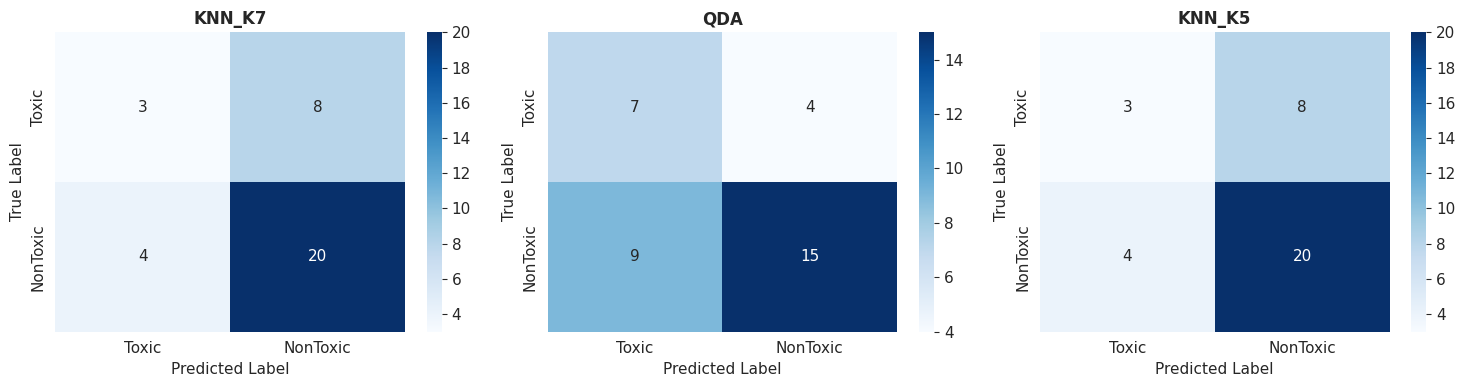

In [ ]:
def plot_confusion_matrices(models_dict, model_names, X_train, X_test, 
                           y_train, y_test, n_models=3):
    """Plot confusion matrices for top models"""
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, name in enumerate(model_names[:n_models]):
        model = models_dict[name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Toxic', 'NonToxic'],
                   yticklabels=['Toxic', 'NonToxic'],
                   ax=axes[idx], cbar=True)
        
        axes[idx].set_ylabel('True Label', fontsize=11)
        axes[idx].set_xlabel('Predicted Label', fontsize=11)
        axes[idx].set_title(f'{name}', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.savefig('fig_confusion_matrices_top3.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrices(models, top_5_models, 
                       X_train_scaled, X_test_scaled, y_train, y_test, n_models=3)


In [ ]:
def plot_confusion_matrices_top_models(confusion_matrices, top_n=8):
    """
    Visualize confusion matrices for top models
    """
    top_models = results_combined_df.head(top_n)['model'].tolist()
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, model_name in enumerate(top_models):
        if model_name not in confusion_matrices:
            continue
        
        cm = confusion_matrices[model_name]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   cbar=False, square=True, linewidths=1, linecolor='black',
                   xticklabels=['Toxic', 'NonToxic'],
                   yticklabels=['Toxic', 'NonToxic'])
        
        axes[idx].set_title(model_name, fontsize=11, weight='bold')
        axes[idx].set_ylabel('True Label', fontsize=10)
        axes[idx].set_xlabel('Predicted Label', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fig_confusion_matrices_top8.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrices_top_models(confusion_matrices, top_n=8)


## Additional Analyses

In [ ]:
def plot_regularization_path_lasso():
    """
    Visualize how coefficients change with regularization strength
    Critical for understanding lasso feature selection
    """
    from sklearn.linear_model import LogisticRegression
    
    C_values = np.logspace(-4, 2, 50)  # 0.0001 to 100
    coefs = []
    
    for C in C_values:
        lr = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=5000, random_state=RANDOM_STATE)
        lr.fit(X_train_scaled, y_train)
        coefs.append(lr.coef_[0])
    
    coefs = np.array(coefs)
    
    plt.figure(figsize=(14, 8))
    
    # Plot top 50 features by max absolute coefficient
    max_coefs = np.abs(coefs).max(axis=0)
    top_features_idx = np.argsort(max_coefs)[-50:]
    
    for idx in top_features_idx:
        plt.plot(np.log10(C_values), coefs[:, idx], alpha=0.6, linewidth=1.5)
    
    plt.xlabel('log10(C) - Inverse Regularization Strength', fontsize=12)
    plt.ylabel('Coefficient Value', fontsize=12)
    plt.title('Lasso Regularization Path (Top 50 Features)', fontsize=14, weight='bold')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('fig_lasso_regularization_path.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Number of non-zero coefficients vs C
    n_nonzero = (np.abs(coefs) > 1e-5).sum(axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(np.log10(C_values), n_nonzero, 'o-', linewidth=2, markersize=6)
    plt.xlabel('log10(C) - Inverse Regularization Strength', fontsize=12)
    plt.ylabel('Number of Non-Zero Coefficients', fontsize=12)
    plt.title('Feature Sparsity vs Regularization Strength', fontsize=14, weight='bold')
    plt.axhline(13, color='red', linestyle='--', label='Original Study (13 features)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('fig_lasso_sparsity_vs_C.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_regularization_path_lasso()


# FINAL SUMMARY AND RECOMMENDATIONS

In [ ]:
print("\n" + "="*80)
print("FINAL ANALYSIS SUMMARY")
print("="*80)

# Best overall model
best_model = cv_results_df.iloc[0]
print(f"\n>>> BEST MODEL (by CV AUC): {best_model['model']}")
print(f"    Test AUC: {best_model['test_auc_mean']:.4f} ± {best_model['test_auc_std']:.4f}")
print(f"    Test Acc: {best_model['test_acc_mean']:.4f} ± {best_model['test_acc_std']:.4f}")
print(f"    Test F1:  {best_model['test_f1_mean']:.4f} ± {best_model['test_f1_std']:.4f}")
print(f"    Overfitting Gap: {best_model['overfitting_gap']:.4f}")

# Best penalized regression model
penalized_models_cv = cv_results_df[cv_results_df['model'].str.contains('LR_')]
best_penalized = penalized_models_cv.iloc[0]
print(f"\n>>> BEST PENALIZED MODEL: {best_penalized['model']}")
print(f"    Test AUC: {best_penalized['test_auc_mean']:.4f} ± {best_penalized['test_auc_std']:.4f}")
print(f"    Test Acc: {best_penalized['test_acc_mean']:.4f} ± {best_penalized['test_acc_std']:.4f}")

# Feature stability summary
print(f"\n>>> FEATURE SELECTION CONSISTENCY:")
print(f"    Features overlapping with original study: Variable across models")
print(f"    Recommendation: Use stability selection for robust feature identification")

# Class imbalance impact
if len(results_smote_df) > 0:
    best_smote = results_smote_df.sort_values('test_auc', ascending=False).iloc[0]
    best_standard_equiv = results_standard_df[
        results_standard_df['model'] == best_smote['model'].replace('_SMOTE', '')
    ]
    if len(best_standard_equiv) > 0:
        std_auc = best_standard_equiv.iloc[0]['test_auc']
        smote_auc = best_smote['test_auc']
        improvement = smote_auc - std_auc
        print(f"\n>>> SMOTE IMPACT:")
        print(f"    Best improvement: {improvement:.4f} AUC")
        if improvement > 0.02:
            print(f"    Recommendation: SMOTE provides meaningful benefit")
        else:
            print(f"    Recommendation: SMOTE provides limited benefit")



FINAL ANALYSIS SUMMARY

>>> BEST MODEL (by CV AUC): KNN_K7
    Test AUC: 0.5199 ± 0.1496
    Test Acc: 0.6238 ± 0.0917
    Test F1:  0.7414 ± 0.0690
    Overfitting Gap: 0.0857

>>> BEST PENALIZED MODEL: LR_Lasso_C0.01
    Test AUC: 0.5000 ± 0.0000
    Test Acc: 0.6690 ± 0.0048

>>> FEATURE SELECTION CONSISTENCY:
    Features overlapping with original study: Variable across models
    Recommendation: Use stability selection for robust feature identification

>>> SMOTE IMPACT:
    Best improvement: 0.1364 AUC
    Recommendation: SMOTE provides meaningful benefit
